# AE_VAE_GAN_CAAE

## Описание задачи

В рамках подготовки к докладу 30.01.2020 рассмотреть следующие архитектуры AE, VAE, GAN, CAAE. В результате получить визуализацию обучения всех 4 моделей

Dataset: MNIST

### import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist_2, plot_mnist_4
import numpy as np
import os

%matplotlib inline

### local utils

In [2]:
weights_dir = '/Users/a18157079/Desktop/Experiments/weights/'

## Make Nets and run models

### AE

Автокодировщики - нейронные сети для задачи unsupervised learning, где входы являются предиктом для выхода.

#### Root settings

In [3]:
root_folder = 'AE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

mnist_tanh = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 2))
fixed_data, _ = next(iter(test_loader))

#### Model

In [4]:
from models.AE import AE

model_AE_16 = AE(16)
model_AE_32 = AE(32)
model_AE_64 = AE(64)


# models = {'16': model_AE_16, '32': model_AE_32, '64': model_AE_64}
models = {'64': model_AE_64}
rho = 1e-5
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

#### Train

In [5]:
def train(epochs, models, log=None):
    train_size = len(train_loader.sampler)
    # запустим data loader (загрузчик)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data) + rho*F.l1_loss(model.encode(data.view(-1, 28*28)),
                                                                   target=torch.zeros_like(model.encode(data.view(-1, 28*28))), 
                                                                   size_average=False)
            #F.l1_loss(data.view(-1, 784), output)  # l1-loss
            loss.backward()
            model.optim.step()
        
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
        else:
            batch_idx += 1
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            if log is not None:
                for k in models:
                    log[k].append((models[k]._loss, models[k]._rho_loss))
            print(line + losses)
        
        
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
            
    for k in models:
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data).view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            # fixed_gen = models[k].decode(fixed_z).data.numpy()
            plot_mnist_4(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            # plot_mnist_4(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)
    

#### Train

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/50000 (0%)]	Losses 64: 0.991311
Train Epoch: 1 [100/50000 (0%)]	Losses 64: 0.986502
Train Epoch: 1 [150/50000 (0%)]	Losses 64: 0.959186
Train Epoch: 1 [200/50000 (0%)]	Losses 64: 0.948347
Train Epoch: 1 [250/50000 (0%)]	Losses 64: 0.942259
Train Epoch: 1 [300/50000 (1%)]	Losses 64: 0.927912
Train Epoch: 1 [350/50000 (1%)]	Losses 64: 0.921501
Train Epoch: 1 [400/50000 (1%)]	Losses 64: 0.908418
Train Epoch: 1 [450/50000 (1%)]	Losses 64: 0.906290
Train Epoch: 1 [500/50000 (1%)]	Losses 64: 0.892072
Train Epoch: 1 [550/50000 (1%)]	Losses 64: 0.887442
Train Epoch: 1 [600/50000 (1%)]	Losses 64: 0.882737
Train Epoch: 1 [650/50000 (1%)]	Losses 64: 0.879018
Train Epoch: 1 [700/50000 (1%)]	Losses 64: 0.874447
Train Epoch: 1 [750/50000 (2%)]	Losses 64: 0.865650
Train Epoch: 1 [800/50000 (2%)]	Losses 64: 0.863636
Train Epoch: 1 [850/50000 (2%)]	Losses 64: 0.855257
Train Epoch: 1 [900/50000 (2%)]	Losses 64: 0.848718
Train Epoch: 1 [950/50000 (2%)]	Losses 64: 0.851940
Train Epoch: 1

Train Epoch: 1 [8600/50000 (17%)]	Losses 64: 0.338033
Train Epoch: 1 [8650/50000 (17%)]	Losses 64: 0.342800
Train Epoch: 1 [8700/50000 (17%)]	Losses 64: 0.334334
Train Epoch: 1 [8750/50000 (18%)]	Losses 64: 0.344884
Train Epoch: 1 [8800/50000 (18%)]	Losses 64: 0.338752
Train Epoch: 1 [8850/50000 (18%)]	Losses 64: 0.332804
Train Epoch: 1 [8900/50000 (18%)]	Losses 64: 0.338045
Train Epoch: 1 [8950/50000 (18%)]	Losses 64: 0.330171
Train Epoch: 1 [9000/50000 (18%)]	Losses 64: 0.337172
Train Epoch: 1 [9050/50000 (18%)]	Losses 64: 0.329835
Train Epoch: 1 [9100/50000 (18%)]	Losses 64: 0.322032
Train Epoch: 1 [9150/50000 (18%)]	Losses 64: 0.327023
Train Epoch: 1 [9200/50000 (18%)]	Losses 64: 0.348127
Train Epoch: 1 [9250/50000 (18%)]	Losses 64: 0.317211
Train Epoch: 1 [9300/50000 (19%)]	Losses 64: 0.332928
Train Epoch: 1 [9350/50000 (19%)]	Losses 64: 0.325736
Train Epoch: 1 [9400/50000 (19%)]	Losses 64: 0.333330
Train Epoch: 1 [9450/50000 (19%)]	Losses 64: 0.332198
Train Epoch: 1 [9500/50000 (

Train Epoch: 1 [16950/50000 (34%)]	Losses 64: 0.271705
Train Epoch: 1 [17000/50000 (34%)]	Losses 64: 0.292660
Train Epoch: 1 [17050/50000 (34%)]	Losses 64: 0.286882
Train Epoch: 1 [17100/50000 (34%)]	Losses 64: 0.270366
Train Epoch: 1 [17150/50000 (34%)]	Losses 64: 0.293478
Train Epoch: 1 [17200/50000 (34%)]	Losses 64: 0.288012
Train Epoch: 1 [17250/50000 (34%)]	Losses 64: 0.286941
Train Epoch: 1 [17300/50000 (35%)]	Losses 64: 0.268783
Train Epoch: 1 [17350/50000 (35%)]	Losses 64: 0.281798
Train Epoch: 1 [17400/50000 (35%)]	Losses 64: 0.268765
Train Epoch: 1 [17450/50000 (35%)]	Losses 64: 0.276442
Train Epoch: 1 [17500/50000 (35%)]	Losses 64: 0.299531
Train Epoch: 1 [17550/50000 (35%)]	Losses 64: 0.272687
Train Epoch: 1 [17600/50000 (35%)]	Losses 64: 0.282473
Train Epoch: 1 [17650/50000 (35%)]	Losses 64: 0.266956
Train Epoch: 1 [17700/50000 (35%)]	Losses 64: 0.284323
Train Epoch: 1 [17750/50000 (36%)]	Losses 64: 0.270940
Train Epoch: 1 [17800/50000 (36%)]	Losses 64: 0.274425
Train Epoc

Train Epoch: 1 [24600/50000 (49%)]	Losses 64: 0.271626
Train Epoch: 1 [24650/50000 (49%)]	Losses 64: 0.274262
Train Epoch: 1 [24700/50000 (49%)]	Losses 64: 0.254777
Train Epoch: 1 [24750/50000 (50%)]	Losses 64: 0.252691
Train Epoch: 1 [24800/50000 (50%)]	Losses 64: 0.257912
Train Epoch: 1 [24850/50000 (50%)]	Losses 64: 0.266538
Train Epoch: 1 [24900/50000 (50%)]	Losses 64: 0.259807
Train Epoch: 1 [24950/50000 (50%)]	Losses 64: 0.285759
Train Epoch: 1 [25000/50000 (50%)]	Losses 64: 0.256814
Train Epoch: 1 [25050/50000 (50%)]	Losses 64: 0.248268
Train Epoch: 1 [25100/50000 (50%)]	Losses 64: 0.265913
Train Epoch: 1 [25150/50000 (50%)]	Losses 64: 0.251847
Train Epoch: 1 [25200/50000 (50%)]	Losses 64: 0.264965
Train Epoch: 1 [25250/50000 (50%)]	Losses 64: 0.253254
Train Epoch: 1 [25300/50000 (51%)]	Losses 64: 0.270707
Train Epoch: 1 [25350/50000 (51%)]	Losses 64: 0.257172
Train Epoch: 1 [25400/50000 (51%)]	Losses 64: 0.271539
Train Epoch: 1 [25450/50000 (51%)]	Losses 64: 0.266270
Train Epoc

Train Epoch: 1 [32150/50000 (64%)]	Losses 64: 0.252911
Train Epoch: 1 [32200/50000 (64%)]	Losses 64: 0.262373
Train Epoch: 1 [32250/50000 (64%)]	Losses 64: 0.240101
Train Epoch: 1 [32300/50000 (65%)]	Losses 64: 0.238786
Train Epoch: 1 [32350/50000 (65%)]	Losses 64: 0.250419
Train Epoch: 1 [32400/50000 (65%)]	Losses 64: 0.257524
Train Epoch: 1 [32450/50000 (65%)]	Losses 64: 0.255828
Train Epoch: 1 [32500/50000 (65%)]	Losses 64: 0.248897
Train Epoch: 1 [32550/50000 (65%)]	Losses 64: 0.248691
Train Epoch: 1 [32600/50000 (65%)]	Losses 64: 0.239861
Train Epoch: 1 [32650/50000 (65%)]	Losses 64: 0.234840
Train Epoch: 1 [32700/50000 (65%)]	Losses 64: 0.261260
Train Epoch: 1 [32750/50000 (66%)]	Losses 64: 0.259729
Train Epoch: 1 [32800/50000 (66%)]	Losses 64: 0.228357
Train Epoch: 1 [32850/50000 (66%)]	Losses 64: 0.240172
Train Epoch: 1 [32900/50000 (66%)]	Losses 64: 0.254785
Train Epoch: 1 [32950/50000 (66%)]	Losses 64: 0.243718
Train Epoch: 1 [33000/50000 (66%)]	Losses 64: 0.242893
Train Epoc

Train Epoch: 1 [39850/50000 (80%)]	Losses 64: 0.238062
Train Epoch: 1 [39900/50000 (80%)]	Losses 64: 0.224434
Train Epoch: 1 [39950/50000 (80%)]	Losses 64: 0.243751
Train Epoch: 1 [40000/50000 (80%)]	Losses 64: 0.236255
Train Epoch: 1 [40000/50000 (80%)]	Losses 64: 0.237867
Train Epoch: 1 [40100/50000 (80%)]	Losses 64: 0.235746
Train Epoch: 1 [40150/50000 (80%)]	Losses 64: 0.232606
Train Epoch: 1 [40200/50000 (80%)]	Losses 64: 0.233891
Train Epoch: 1 [40250/50000 (80%)]	Losses 64: 0.237544
Train Epoch: 1 [40300/50000 (81%)]	Losses 64: 0.240001
Train Epoch: 1 [40350/50000 (81%)]	Losses 64: 0.231027
Train Epoch: 1 [40400/50000 (81%)]	Losses 64: 0.244855
Train Epoch: 1 [40450/50000 (81%)]	Losses 64: 0.225159
Train Epoch: 1 [40500/50000 (81%)]	Losses 64: 0.245681
Train Epoch: 1 [40550/50000 (81%)]	Losses 64: 0.236873
Train Epoch: 1 [40600/50000 (81%)]	Losses 64: 0.236662
Train Epoch: 1 [40650/50000 (81%)]	Losses 64: 0.237479
Train Epoch: 1 [40700/50000 (81%)]	Losses 64: 0.249804
Train Epoc

Train Epoch: 1 [47500/50000 (95%)]	Losses 64: 0.230135
Train Epoch: 1 [47550/50000 (95%)]	Losses 64: 0.215911
Train Epoch: 1 [47600/50000 (95%)]	Losses 64: 0.233775
Train Epoch: 1 [47650/50000 (95%)]	Losses 64: 0.237045
Train Epoch: 1 [47700/50000 (95%)]	Losses 64: 0.225952
Train Epoch: 1 [47750/50000 (96%)]	Losses 64: 0.243184
Train Epoch: 1 [47800/50000 (96%)]	Losses 64: 0.220395
Train Epoch: 1 [47850/50000 (96%)]	Losses 64: 0.226785
Train Epoch: 1 [47900/50000 (96%)]	Losses 64: 0.218613
Train Epoch: 1 [47950/50000 (96%)]	Losses 64: 0.219363
Train Epoch: 1 [48000/50000 (96%)]	Losses 64: 0.227898
Train Epoch: 1 [48050/50000 (96%)]	Losses 64: 0.213562
Train Epoch: 1 [48100/50000 (96%)]	Losses 64: 0.225865
Train Epoch: 1 [48150/50000 (96%)]	Losses 64: 0.219517
Train Epoch: 1 [48200/50000 (96%)]	Losses 64: 0.227755
Train Epoch: 1 [48250/50000 (96%)]	Losses 64: 0.238398
Train Epoch: 1 [48300/50000 (97%)]	Losses 64: 0.216293
Train Epoch: 1 [48350/50000 (97%)]	Losses 64: 0.227799
Train Epoc

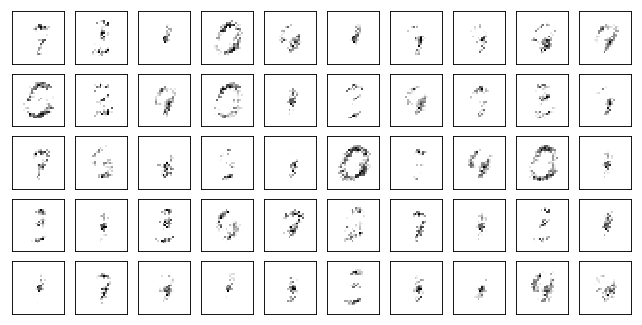

Test set:
64: loss: 0.2200	pho_loss: nan

Train Epoch: 2 [0/50000 (0%)]	Losses 64: 0.213092
Train Epoch: 2 [100/50000 (0%)]	Losses 64: 0.227186
Train Epoch: 2 [150/50000 (0%)]	Losses 64: 0.215194
Train Epoch: 2 [200/50000 (0%)]	Losses 64: 0.232495
Train Epoch: 2 [250/50000 (0%)]	Losses 64: 0.215770
Train Epoch: 2 [300/50000 (1%)]	Losses 64: 0.235473
Train Epoch: 2 [350/50000 (1%)]	Losses 64: 0.230212
Train Epoch: 2 [400/50000 (1%)]	Losses 64: 0.218381
Train Epoch: 2 [450/50000 (1%)]	Losses 64: 0.216207
Train Epoch: 2 [500/50000 (1%)]	Losses 64: 0.234440
Train Epoch: 2 [550/50000 (1%)]	Losses 64: 0.228566
Train Epoch: 2 [600/50000 (1%)]	Losses 64: 0.226973
Train Epoch: 2 [650/50000 (1%)]	Losses 64: 0.216219
Train Epoch: 2 [700/50000 (1%)]	Losses 64: 0.234037
Train Epoch: 2 [750/50000 (2%)]	Losses 64: 0.215855
Train Epoch: 2 [800/50000 (2%)]	Losses 64: 0.221434
Train Epoch: 2 [850/50000 (2%)]	Losses 64: 0.227488
Train Epoch: 2 [900/50000 (2%)]	Losses 64: 0.207052
Train Epoch: 2 [950/5000

Train Epoch: 2 [7750/50000 (16%)]	Losses 64: 0.199854
Train Epoch: 2 [7800/50000 (16%)]	Losses 64: 0.211381
Train Epoch: 2 [7850/50000 (16%)]	Losses 64: 0.220965
Train Epoch: 2 [7900/50000 (16%)]	Losses 64: 0.197470
Train Epoch: 2 [7950/50000 (16%)]	Losses 64: 0.202588
Train Epoch: 2 [8000/50000 (16%)]	Losses 64: 0.201786
Train Epoch: 2 [8050/50000 (16%)]	Losses 64: 0.193412
Train Epoch: 2 [8100/50000 (16%)]	Losses 64: 0.206131
Train Epoch: 2 [8150/50000 (16%)]	Losses 64: 0.205117
Train Epoch: 2 [8200/50000 (16%)]	Losses 64: 0.204516
Train Epoch: 2 [8250/50000 (16%)]	Losses 64: 0.188916
Train Epoch: 2 [8300/50000 (17%)]	Losses 64: 0.188069
Train Epoch: 2 [8350/50000 (17%)]	Losses 64: 0.210566
Train Epoch: 2 [8400/50000 (17%)]	Losses 64: 0.201343
Train Epoch: 2 [8450/50000 (17%)]	Losses 64: 0.202849
Train Epoch: 2 [8500/50000 (17%)]	Losses 64: 0.200566
Train Epoch: 2 [8550/50000 (17%)]	Losses 64: 0.209874
Train Epoch: 2 [8600/50000 (17%)]	Losses 64: 0.201277
Train Epoch: 2 [8650/50000 (

Train Epoch: 2 [15450/50000 (31%)]	Losses 64: 0.195948
Train Epoch: 2 [15500/50000 (31%)]	Losses 64: 0.191149
Train Epoch: 2 [15550/50000 (31%)]	Losses 64: 0.201499
Train Epoch: 2 [15600/50000 (31%)]	Losses 64: 0.200132
Train Epoch: 2 [15650/50000 (31%)]	Losses 64: 0.198185
Train Epoch: 2 [15700/50000 (31%)]	Losses 64: 0.172933
Train Epoch: 2 [15750/50000 (32%)]	Losses 64: 0.190399
Train Epoch: 2 [15800/50000 (32%)]	Losses 64: 0.189160
Train Epoch: 2 [15850/50000 (32%)]	Losses 64: 0.196342
Train Epoch: 2 [15900/50000 (32%)]	Losses 64: 0.188183
Train Epoch: 2 [15950/50000 (32%)]	Losses 64: 0.197216
Train Epoch: 2 [16000/50000 (32%)]	Losses 64: 0.197038
Train Epoch: 2 [16050/50000 (32%)]	Losses 64: 0.186929
Train Epoch: 2 [16100/50000 (32%)]	Losses 64: 0.193667
Train Epoch: 2 [16150/50000 (32%)]	Losses 64: 0.197353
Train Epoch: 2 [16200/50000 (32%)]	Losses 64: 0.187198
Train Epoch: 2 [16250/50000 (32%)]	Losses 64: 0.186809
Train Epoch: 2 [16300/50000 (33%)]	Losses 64: 0.193558
Train Epoc

Train Epoch: 2 [23150/50000 (46%)]	Losses 64: 0.189531
Train Epoch: 2 [23200/50000 (46%)]	Losses 64: 0.184783
Train Epoch: 2 [23250/50000 (46%)]	Losses 64: 0.189503
Train Epoch: 2 [23300/50000 (47%)]	Losses 64: 0.181352
Train Epoch: 2 [23350/50000 (47%)]	Losses 64: 0.174867
Train Epoch: 2 [23400/50000 (47%)]	Losses 64: 0.186642
Train Epoch: 2 [23450/50000 (47%)]	Losses 64: 0.178894
Train Epoch: 2 [23500/50000 (47%)]	Losses 64: 0.179972
Train Epoch: 2 [23550/50000 (47%)]	Losses 64: 0.191569
Train Epoch: 2 [23600/50000 (47%)]	Losses 64: 0.190765
Train Epoch: 2 [23650/50000 (47%)]	Losses 64: 0.173584
Train Epoch: 2 [23700/50000 (47%)]	Losses 64: 0.165704
Train Epoch: 2 [23750/50000 (48%)]	Losses 64: 0.177039
Train Epoch: 2 [23800/50000 (48%)]	Losses 64: 0.174918
Train Epoch: 2 [23850/50000 (48%)]	Losses 64: 0.178440
Train Epoch: 2 [23900/50000 (48%)]	Losses 64: 0.187115
Train Epoch: 2 [23950/50000 (48%)]	Losses 64: 0.183672
Train Epoch: 2 [24000/50000 (48%)]	Losses 64: 0.178252
Train Epoc

Train Epoch: 2 [30850/50000 (62%)]	Losses 64: 0.165640
Train Epoch: 2 [30900/50000 (62%)]	Losses 64: 0.186214
Train Epoch: 2 [30950/50000 (62%)]	Losses 64: 0.166500
Train Epoch: 2 [31000/50000 (62%)]	Losses 64: 0.169558
Train Epoch: 2 [31050/50000 (62%)]	Losses 64: 0.174951
Train Epoch: 2 [31100/50000 (62%)]	Losses 64: 0.175715
Train Epoch: 2 [31150/50000 (62%)]	Losses 64: 0.160751
Train Epoch: 2 [31200/50000 (62%)]	Losses 64: 0.159910
Train Epoch: 2 [31250/50000 (62%)]	Losses 64: 0.182085
Train Epoch: 2 [31300/50000 (63%)]	Losses 64: 0.172131
Train Epoch: 2 [31350/50000 (63%)]	Losses 64: 0.177370
Train Epoch: 2 [31400/50000 (63%)]	Losses 64: 0.163592
Train Epoch: 2 [31450/50000 (63%)]	Losses 64: 0.175064
Train Epoch: 2 [31500/50000 (63%)]	Losses 64: 0.171546
Train Epoch: 2 [31550/50000 (63%)]	Losses 64: 0.158815
Train Epoch: 2 [31600/50000 (63%)]	Losses 64: 0.177761
Train Epoch: 2 [31650/50000 (63%)]	Losses 64: 0.176621
Train Epoch: 2 [31700/50000 (63%)]	Losses 64: 0.181385
Train Epoc

Train Epoch: 2 [38550/50000 (77%)]	Losses 64: 0.150066
Train Epoch: 2 [38600/50000 (77%)]	Losses 64: 0.151849
Train Epoch: 2 [38650/50000 (77%)]	Losses 64: 0.170171
Train Epoch: 2 [38700/50000 (77%)]	Losses 64: 0.160520
Train Epoch: 2 [38750/50000 (78%)]	Losses 64: 0.169622
Train Epoch: 2 [38800/50000 (78%)]	Losses 64: 0.149273
Train Epoch: 2 [38850/50000 (78%)]	Losses 64: 0.167715
Train Epoch: 2 [38900/50000 (78%)]	Losses 64: 0.159256
Train Epoch: 2 [38950/50000 (78%)]	Losses 64: 0.165348
Train Epoch: 2 [39000/50000 (78%)]	Losses 64: 0.167791
Train Epoch: 2 [39050/50000 (78%)]	Losses 64: 0.164151
Train Epoch: 2 [39100/50000 (78%)]	Losses 64: 0.162502
Train Epoch: 2 [39150/50000 (78%)]	Losses 64: 0.166967
Train Epoch: 2 [39200/50000 (78%)]	Losses 64: 0.154728
Train Epoch: 2 [39250/50000 (78%)]	Losses 64: 0.163756
Train Epoch: 2 [39300/50000 (79%)]	Losses 64: 0.164654
Train Epoch: 2 [39350/50000 (79%)]	Losses 64: 0.161685
Train Epoch: 2 [39400/50000 (79%)]	Losses 64: 0.155432
Train Epoc

Train Epoch: 2 [46200/50000 (92%)]	Losses 64: 0.157167
Train Epoch: 2 [46250/50000 (92%)]	Losses 64: 0.139054
Train Epoch: 2 [46300/50000 (93%)]	Losses 64: 0.152639
Train Epoch: 2 [46350/50000 (93%)]	Losses 64: 0.156398
Train Epoch: 2 [46400/50000 (93%)]	Losses 64: 0.144953
Train Epoch: 2 [46450/50000 (93%)]	Losses 64: 0.169901
Train Epoch: 2 [46500/50000 (93%)]	Losses 64: 0.157001
Train Epoch: 2 [46550/50000 (93%)]	Losses 64: 0.156786
Train Epoch: 2 [46600/50000 (93%)]	Losses 64: 0.149608
Train Epoch: 2 [46650/50000 (93%)]	Losses 64: 0.160258
Train Epoch: 2 [46700/50000 (93%)]	Losses 64: 0.154602
Train Epoch: 2 [46750/50000 (94%)]	Losses 64: 0.158941
Train Epoch: 2 [46800/50000 (94%)]	Losses 64: 0.151022
Train Epoch: 2 [46850/50000 (94%)]	Losses 64: 0.168411
Train Epoch: 2 [46900/50000 (94%)]	Losses 64: 0.152982
Train Epoch: 2 [46950/50000 (94%)]	Losses 64: 0.148875
Train Epoch: 2 [47000/50000 (94%)]	Losses 64: 0.146198
Train Epoch: 2 [47050/50000 (94%)]	Losses 64: 0.154908
Train Epoc

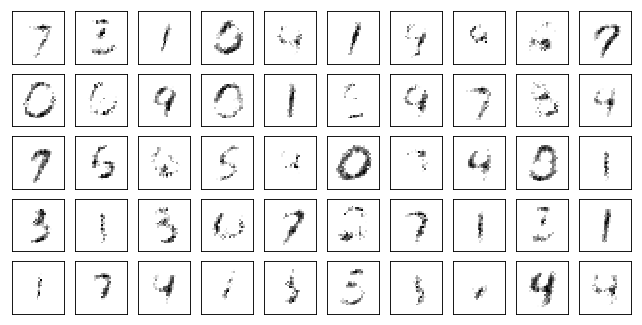

Test set:
64: loss: 0.1520	pho_loss: nan

Train Epoch: 3 [0/50000 (0%)]	Losses 64: 0.144104
Train Epoch: 3 [100/50000 (0%)]	Losses 64: 0.153111
Train Epoch: 3 [150/50000 (0%)]	Losses 64: 0.168396
Train Epoch: 3 [200/50000 (0%)]	Losses 64: 0.155619
Train Epoch: 3 [250/50000 (0%)]	Losses 64: 0.161766
Train Epoch: 3 [300/50000 (1%)]	Losses 64: 0.142606
Train Epoch: 3 [350/50000 (1%)]	Losses 64: 0.145633
Train Epoch: 3 [400/50000 (1%)]	Losses 64: 0.150700
Train Epoch: 3 [450/50000 (1%)]	Losses 64: 0.153990
Train Epoch: 3 [500/50000 (1%)]	Losses 64: 0.141582
Train Epoch: 3 [550/50000 (1%)]	Losses 64: 0.151650
Train Epoch: 3 [600/50000 (1%)]	Losses 64: 0.160855
Train Epoch: 3 [650/50000 (1%)]	Losses 64: 0.145622
Train Epoch: 3 [700/50000 (1%)]	Losses 64: 0.153366
Train Epoch: 3 [750/50000 (2%)]	Losses 64: 0.153375
Train Epoch: 3 [800/50000 (2%)]	Losses 64: 0.148186
Train Epoch: 3 [850/50000 (2%)]	Losses 64: 0.140226
Train Epoch: 3 [900/50000 (2%)]	Losses 64: 0.150809
Train Epoch: 3 [950/5000

Train Epoch: 3 [7700/50000 (15%)]	Losses 64: 0.155781
Train Epoch: 3 [7750/50000 (16%)]	Losses 64: 0.136382
Train Epoch: 3 [7800/50000 (16%)]	Losses 64: 0.141711
Train Epoch: 3 [7850/50000 (16%)]	Losses 64: 0.143936
Train Epoch: 3 [7900/50000 (16%)]	Losses 64: 0.137927
Train Epoch: 3 [7950/50000 (16%)]	Losses 64: 0.143790
Train Epoch: 3 [8000/50000 (16%)]	Losses 64: 0.145835
Train Epoch: 3 [8050/50000 (16%)]	Losses 64: 0.149994
Train Epoch: 3 [8100/50000 (16%)]	Losses 64: 0.142411
Train Epoch: 3 [8150/50000 (16%)]	Losses 64: 0.148275
Train Epoch: 3 [8200/50000 (16%)]	Losses 64: 0.137382
Train Epoch: 3 [8250/50000 (16%)]	Losses 64: 0.135354
Train Epoch: 3 [8300/50000 (17%)]	Losses 64: 0.155551
Train Epoch: 3 [8350/50000 (17%)]	Losses 64: 0.146163
Train Epoch: 3 [8400/50000 (17%)]	Losses 64: 0.133500
Train Epoch: 3 [8450/50000 (17%)]	Losses 64: 0.142425
Train Epoch: 3 [8500/50000 (17%)]	Losses 64: 0.150313
Train Epoch: 3 [8550/50000 (17%)]	Losses 64: 0.139039
Train Epoch: 3 [8600/50000 (

Train Epoch: 3 [15450/50000 (31%)]	Losses 64: 0.137197
Train Epoch: 3 [15500/50000 (31%)]	Losses 64: 0.143633
Train Epoch: 3 [15550/50000 (31%)]	Losses 64: 0.139549
Train Epoch: 3 [15600/50000 (31%)]	Losses 64: 0.135131
Train Epoch: 3 [15650/50000 (31%)]	Losses 64: 0.125269
Train Epoch: 3 [15700/50000 (31%)]	Losses 64: 0.144264
Train Epoch: 3 [15750/50000 (32%)]	Losses 64: 0.138120
Train Epoch: 3 [15800/50000 (32%)]	Losses 64: 0.141768
Train Epoch: 3 [15850/50000 (32%)]	Losses 64: 0.145280
Train Epoch: 3 [15900/50000 (32%)]	Losses 64: 0.132492
Train Epoch: 3 [15950/50000 (32%)]	Losses 64: 0.138598
Train Epoch: 3 [16000/50000 (32%)]	Losses 64: 0.147452
Train Epoch: 3 [16050/50000 (32%)]	Losses 64: 0.136568
Train Epoch: 3 [16100/50000 (32%)]	Losses 64: 0.135375
Train Epoch: 3 [16150/50000 (32%)]	Losses 64: 0.133554
Train Epoch: 3 [16200/50000 (32%)]	Losses 64: 0.147635
Train Epoch: 3 [16250/50000 (32%)]	Losses 64: 0.137860
Train Epoch: 3 [16300/50000 (33%)]	Losses 64: 0.138583
Train Epoc

Train Epoch: 3 [23250/50000 (46%)]	Losses 64: 0.129831
Train Epoch: 3 [23300/50000 (47%)]	Losses 64: 0.119369
Train Epoch: 3 [23350/50000 (47%)]	Losses 64: 0.128818
Train Epoch: 3 [23400/50000 (47%)]	Losses 64: 0.135240
Train Epoch: 3 [23450/50000 (47%)]	Losses 64: 0.133979
Train Epoch: 3 [23500/50000 (47%)]	Losses 64: 0.132941
Train Epoch: 3 [23550/50000 (47%)]	Losses 64: 0.129266
Train Epoch: 3 [23600/50000 (47%)]	Losses 64: 0.126816
Train Epoch: 3 [23650/50000 (47%)]	Losses 64: 0.126989
Train Epoch: 3 [23700/50000 (47%)]	Losses 64: 0.141221
Train Epoch: 3 [23750/50000 (48%)]	Losses 64: 0.131814
Train Epoch: 3 [23800/50000 (48%)]	Losses 64: 0.123967
Train Epoch: 3 [23850/50000 (48%)]	Losses 64: 0.133709
Train Epoch: 3 [23900/50000 (48%)]	Losses 64: 0.126073
Train Epoch: 3 [23950/50000 (48%)]	Losses 64: 0.127630
Train Epoch: 3 [24000/50000 (48%)]	Losses 64: 0.130211
Train Epoch: 3 [24050/50000 (48%)]	Losses 64: 0.134621
Train Epoch: 3 [24100/50000 (48%)]	Losses 64: 0.127791
Train Epoc

Train Epoch: 3 [30950/50000 (62%)]	Losses 64: 0.117978
Train Epoch: 3 [31000/50000 (62%)]	Losses 64: 0.130496
Train Epoch: 3 [31050/50000 (62%)]	Losses 64: 0.129047
Train Epoch: 3 [31100/50000 (62%)]	Losses 64: 0.124330
Train Epoch: 3 [31150/50000 (62%)]	Losses 64: 0.132994
Train Epoch: 3 [31200/50000 (62%)]	Losses 64: 0.126835
Train Epoch: 3 [31250/50000 (62%)]	Losses 64: 0.123347
Train Epoch: 3 [31300/50000 (63%)]	Losses 64: 0.120112
Train Epoch: 3 [31350/50000 (63%)]	Losses 64: 0.116587
Train Epoch: 3 [31400/50000 (63%)]	Losses 64: 0.125667
Train Epoch: 3 [31450/50000 (63%)]	Losses 64: 0.122428
Train Epoch: 3 [31500/50000 (63%)]	Losses 64: 0.130176
Train Epoch: 3 [31550/50000 (63%)]	Losses 64: 0.126715
Train Epoch: 3 [31600/50000 (63%)]	Losses 64: 0.118374
Train Epoch: 3 [31650/50000 (63%)]	Losses 64: 0.117544
Train Epoch: 3 [31700/50000 (63%)]	Losses 64: 0.133584
Train Epoch: 3 [31750/50000 (64%)]	Losses 64: 0.126179
Train Epoch: 3 [31800/50000 (64%)]	Losses 64: 0.132916
Train Epoc

Train Epoch: 3 [38650/50000 (77%)]	Losses 64: 0.116219
Train Epoch: 3 [38700/50000 (77%)]	Losses 64: 0.122511
Train Epoch: 3 [38750/50000 (78%)]	Losses 64: 0.124355
Train Epoch: 3 [38800/50000 (78%)]	Losses 64: 0.127247
Train Epoch: 3 [38850/50000 (78%)]	Losses 64: 0.119727
Train Epoch: 3 [38900/50000 (78%)]	Losses 64: 0.121329
Train Epoch: 3 [38950/50000 (78%)]	Losses 64: 0.127059
Train Epoch: 3 [39000/50000 (78%)]	Losses 64: 0.124526
Train Epoch: 3 [39050/50000 (78%)]	Losses 64: 0.115978
Train Epoch: 3 [39100/50000 (78%)]	Losses 64: 0.111081
Train Epoch: 3 [39150/50000 (78%)]	Losses 64: 0.130241
Train Epoch: 3 [39200/50000 (78%)]	Losses 64: 0.118047
Train Epoch: 3 [39250/50000 (78%)]	Losses 64: 0.127859
Train Epoch: 3 [39300/50000 (79%)]	Losses 64: 0.118217
Train Epoch: 3 [39350/50000 (79%)]	Losses 64: 0.120037
Train Epoch: 3 [39400/50000 (79%)]	Losses 64: 0.124695
Train Epoch: 3 [39450/50000 (79%)]	Losses 64: 0.112905
Train Epoch: 3 [39500/50000 (79%)]	Losses 64: 0.126237
Train Epoc

Train Epoch: 3 [46400/50000 (93%)]	Losses 64: 0.113225
Train Epoch: 3 [46450/50000 (93%)]	Losses 64: 0.119282
Train Epoch: 3 [46500/50000 (93%)]	Losses 64: 0.120900
Train Epoch: 3 [46550/50000 (93%)]	Losses 64: 0.122991
Train Epoch: 3 [46600/50000 (93%)]	Losses 64: 0.112791
Train Epoch: 3 [46650/50000 (93%)]	Losses 64: 0.123924
Train Epoch: 3 [46700/50000 (93%)]	Losses 64: 0.112496
Train Epoch: 3 [46750/50000 (94%)]	Losses 64: 0.119292
Train Epoch: 3 [46800/50000 (94%)]	Losses 64: 0.121788
Train Epoch: 3 [46850/50000 (94%)]	Losses 64: 0.121986
Train Epoch: 3 [46900/50000 (94%)]	Losses 64: 0.114887
Train Epoch: 3 [46950/50000 (94%)]	Losses 64: 0.122251
Train Epoch: 3 [47000/50000 (94%)]	Losses 64: 0.109621
Train Epoch: 3 [47050/50000 (94%)]	Losses 64: 0.124790
Train Epoch: 3 [47100/50000 (94%)]	Losses 64: 0.119501
Train Epoch: 3 [47150/50000 (94%)]	Losses 64: 0.118472
Train Epoch: 3 [47200/50000 (94%)]	Losses 64: 0.124020
Train Epoch: 3 [47250/50000 (94%)]	Losses 64: 0.108976
Train Epoc

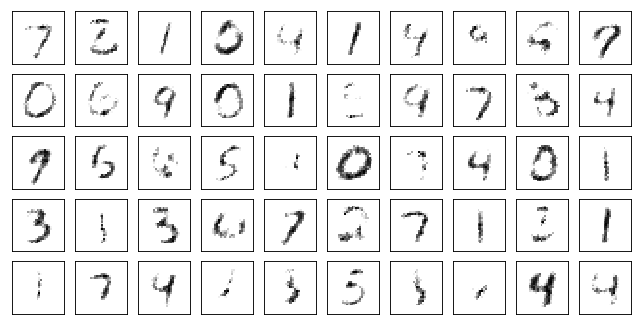

Test set:
64: loss: 0.1165	pho_loss: nan

Train Epoch: 4 [0/50000 (0%)]	Losses 64: 0.102791
Train Epoch: 4 [100/50000 (0%)]	Losses 64: 0.113727
Train Epoch: 4 [150/50000 (0%)]	Losses 64: 0.115767
Train Epoch: 4 [200/50000 (0%)]	Losses 64: 0.115330
Train Epoch: 4 [250/50000 (0%)]	Losses 64: 0.116840
Train Epoch: 4 [300/50000 (1%)]	Losses 64: 0.118844
Train Epoch: 4 [350/50000 (1%)]	Losses 64: 0.113600
Train Epoch: 4 [400/50000 (1%)]	Losses 64: 0.117358
Train Epoch: 4 [450/50000 (1%)]	Losses 64: 0.109150
Train Epoch: 4 [500/50000 (1%)]	Losses 64: 0.118046
Train Epoch: 4 [550/50000 (1%)]	Losses 64: 0.113074
Train Epoch: 4 [600/50000 (1%)]	Losses 64: 0.107961
Train Epoch: 4 [650/50000 (1%)]	Losses 64: 0.114523
Train Epoch: 4 [700/50000 (1%)]	Losses 64: 0.120434
Train Epoch: 4 [750/50000 (2%)]	Losses 64: 0.119081
Train Epoch: 4 [800/50000 (2%)]	Losses 64: 0.120533
Train Epoch: 4 [850/50000 (2%)]	Losses 64: 0.117836
Train Epoch: 4 [900/50000 (2%)]	Losses 64: 0.123201
Train Epoch: 4 [950/5000

Train Epoch: 4 [8750/50000 (18%)]	Losses 64: 0.118975
Train Epoch: 4 [8800/50000 (18%)]	Losses 64: 0.108619
Train Epoch: 4 [8850/50000 (18%)]	Losses 64: 0.120532
Train Epoch: 4 [8900/50000 (18%)]	Losses 64: 0.111879
Train Epoch: 4 [8950/50000 (18%)]	Losses 64: 0.109964
Train Epoch: 4 [9000/50000 (18%)]	Losses 64: 0.104782
Train Epoch: 4 [9050/50000 (18%)]	Losses 64: 0.121858
Train Epoch: 4 [9100/50000 (18%)]	Losses 64: 0.112720
Train Epoch: 4 [9150/50000 (18%)]	Losses 64: 0.112411
Train Epoch: 4 [9200/50000 (18%)]	Losses 64: 0.117119
Train Epoch: 4 [9250/50000 (18%)]	Losses 64: 0.112515
Train Epoch: 4 [9300/50000 (19%)]	Losses 64: 0.105280
Train Epoch: 4 [9350/50000 (19%)]	Losses 64: 0.115592
Train Epoch: 4 [9400/50000 (19%)]	Losses 64: 0.107749
Train Epoch: 4 [9450/50000 (19%)]	Losses 64: 0.111150
Train Epoch: 4 [9500/50000 (19%)]	Losses 64: 0.105760
Train Epoch: 4 [9550/50000 (19%)]	Losses 64: 0.109350
Train Epoch: 4 [9600/50000 (19%)]	Losses 64: 0.105138
Train Epoch: 4 [9650/50000 (

Train Epoch: 4 [16500/50000 (33%)]	Losses 64: 0.111545
Train Epoch: 4 [16550/50000 (33%)]	Losses 64: 0.109516
Train Epoch: 4 [16600/50000 (33%)]	Losses 64: 0.111773
Train Epoch: 4 [16650/50000 (33%)]	Losses 64: 0.104766
Train Epoch: 4 [16700/50000 (33%)]	Losses 64: 0.100565
Train Epoch: 4 [16750/50000 (34%)]	Losses 64: 0.107564
Train Epoch: 4 [16800/50000 (34%)]	Losses 64: 0.102422
Train Epoch: 4 [16850/50000 (34%)]	Losses 64: 0.110747
Train Epoch: 4 [16900/50000 (34%)]	Losses 64: 0.103483
Train Epoch: 4 [16950/50000 (34%)]	Losses 64: 0.114978
Train Epoch: 4 [17000/50000 (34%)]	Losses 64: 0.101823
Train Epoch: 4 [17050/50000 (34%)]	Losses 64: 0.113513
Train Epoch: 4 [17100/50000 (34%)]	Losses 64: 0.104330
Train Epoch: 4 [17150/50000 (34%)]	Losses 64: 0.115640
Train Epoch: 4 [17200/50000 (34%)]	Losses 64: 0.113479
Train Epoch: 4 [17250/50000 (34%)]	Losses 64: 0.118150
Train Epoch: 4 [17300/50000 (35%)]	Losses 64: 0.107027
Train Epoch: 4 [17350/50000 (35%)]	Losses 64: 0.104132
Train Epoc

Train Epoch: 4 [24100/50000 (48%)]	Losses 64: 0.099628
Train Epoch: 4 [24150/50000 (48%)]	Losses 64: 0.107620
Train Epoch: 4 [24200/50000 (48%)]	Losses 64: 0.100260
Train Epoch: 4 [24250/50000 (48%)]	Losses 64: 0.098875
Train Epoch: 4 [24300/50000 (49%)]	Losses 64: 0.098923
Train Epoch: 4 [24350/50000 (49%)]	Losses 64: 0.093756
Train Epoch: 4 [24400/50000 (49%)]	Losses 64: 0.107737
Train Epoch: 4 [24450/50000 (49%)]	Losses 64: 0.112392
Train Epoch: 4 [24500/50000 (49%)]	Losses 64: 0.110353
Train Epoch: 4 [24550/50000 (49%)]	Losses 64: 0.101700
Train Epoch: 4 [24600/50000 (49%)]	Losses 64: 0.107263
Train Epoch: 4 [24650/50000 (49%)]	Losses 64: 0.106850
Train Epoch: 4 [24700/50000 (49%)]	Losses 64: 0.111082
Train Epoch: 4 [24750/50000 (50%)]	Losses 64: 0.102839
Train Epoch: 4 [24800/50000 (50%)]	Losses 64: 0.111772
Train Epoch: 4 [24850/50000 (50%)]	Losses 64: 0.102840
Train Epoch: 4 [24900/50000 (50%)]	Losses 64: 0.100639
Train Epoch: 4 [24950/50000 (50%)]	Losses 64: 0.098347
Train Epoc

Train Epoch: 4 [31800/50000 (64%)]	Losses 64: 0.106079
Train Epoch: 4 [31850/50000 (64%)]	Losses 64: 0.099477
Train Epoch: 4 [31900/50000 (64%)]	Losses 64: 0.103952
Train Epoch: 4 [31950/50000 (64%)]	Losses 64: 0.100409
Train Epoch: 4 [32000/50000 (64%)]	Losses 64: 0.103200
Train Epoch: 4 [32050/50000 (64%)]	Losses 64: 0.102580
Train Epoch: 4 [32100/50000 (64%)]	Losses 64: 0.105116
Train Epoch: 4 [32150/50000 (64%)]	Losses 64: 0.095563
Train Epoch: 4 [32200/50000 (64%)]	Losses 64: 0.093171
Train Epoch: 4 [32250/50000 (64%)]	Losses 64: 0.105340
Train Epoch: 4 [32300/50000 (65%)]	Losses 64: 0.102545
Train Epoch: 4 [32350/50000 (65%)]	Losses 64: 0.102433
Train Epoch: 4 [32400/50000 (65%)]	Losses 64: 0.098736
Train Epoch: 4 [32450/50000 (65%)]	Losses 64: 0.108838
Train Epoch: 4 [32500/50000 (65%)]	Losses 64: 0.094050
Train Epoch: 4 [32550/50000 (65%)]	Losses 64: 0.106441
Train Epoch: 4 [32600/50000 (65%)]	Losses 64: 0.102753
Train Epoch: 4 [32650/50000 (65%)]	Losses 64: 0.105731
Train Epoc

Train Epoch: 4 [39500/50000 (79%)]	Losses 64: 0.082717
Train Epoch: 4 [39550/50000 (79%)]	Losses 64: 0.099055
Train Epoch: 4 [39600/50000 (79%)]	Losses 64: 0.096433
Train Epoch: 4 [39650/50000 (79%)]	Losses 64: 0.095704
Train Epoch: 4 [39700/50000 (79%)]	Losses 64: 0.099680
Train Epoch: 4 [39750/50000 (80%)]	Losses 64: 0.096099
Train Epoch: 4 [39800/50000 (80%)]	Losses 64: 0.104125
Train Epoch: 4 [39850/50000 (80%)]	Losses 64: 0.098343
Train Epoch: 4 [39900/50000 (80%)]	Losses 64: 0.089031
Train Epoch: 4 [39950/50000 (80%)]	Losses 64: 0.098382
Train Epoch: 4 [40000/50000 (80%)]	Losses 64: 0.097756
Train Epoch: 4 [40000/50000 (80%)]	Losses 64: 0.101854
Train Epoch: 4 [40100/50000 (80%)]	Losses 64: 0.091944
Train Epoch: 4 [40150/50000 (80%)]	Losses 64: 0.090814
Train Epoch: 4 [40200/50000 (80%)]	Losses 64: 0.096886
Train Epoch: 4 [40250/50000 (80%)]	Losses 64: 0.104173
Train Epoch: 4 [40300/50000 (81%)]	Losses 64: 0.096999
Train Epoch: 4 [40350/50000 (81%)]	Losses 64: 0.093601
Train Epoc

Train Epoch: 4 [47050/50000 (94%)]	Losses 64: 0.083847
Train Epoch: 4 [47100/50000 (94%)]	Losses 64: 0.097926
Train Epoch: 4 [47150/50000 (94%)]	Losses 64: 0.100807
Train Epoch: 4 [47200/50000 (94%)]	Losses 64: 0.088271
Train Epoch: 4 [47250/50000 (94%)]	Losses 64: 0.097308
Train Epoch: 4 [47300/50000 (95%)]	Losses 64: 0.093402
Train Epoch: 4 [47350/50000 (95%)]	Losses 64: 0.095752
Train Epoch: 4 [47400/50000 (95%)]	Losses 64: 0.086511
Train Epoch: 4 [47450/50000 (95%)]	Losses 64: 0.096408
Train Epoch: 4 [47500/50000 (95%)]	Losses 64: 0.093562
Train Epoch: 4 [47550/50000 (95%)]	Losses 64: 0.104819
Train Epoch: 4 [47600/50000 (95%)]	Losses 64: 0.091609
Train Epoch: 4 [47650/50000 (95%)]	Losses 64: 0.093936
Train Epoch: 4 [47700/50000 (95%)]	Losses 64: 0.098235
Train Epoch: 4 [47750/50000 (96%)]	Losses 64: 0.093962
Train Epoch: 4 [47800/50000 (96%)]	Losses 64: 0.090085
Train Epoch: 4 [47850/50000 (96%)]	Losses 64: 0.089255
Train Epoch: 4 [47900/50000 (96%)]	Losses 64: 0.093015
Train Epoc

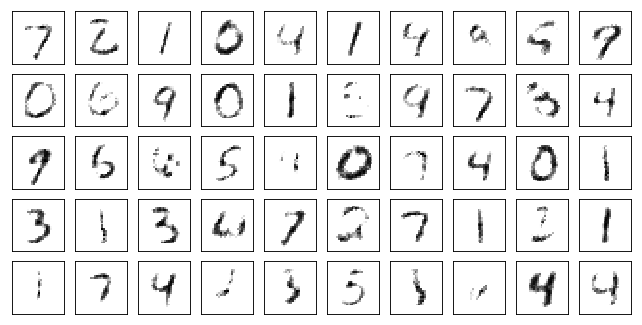

Test set:
64: loss: 0.0939	pho_loss: nan

Train Epoch: 5 [0/50000 (0%)]	Losses 64: 0.097238
Train Epoch: 5 [100/50000 (0%)]	Losses 64: 0.109020
Train Epoch: 5 [150/50000 (0%)]	Losses 64: 0.090195
Train Epoch: 5 [200/50000 (0%)]	Losses 64: 0.090940
Train Epoch: 5 [250/50000 (0%)]	Losses 64: 0.095400
Train Epoch: 5 [300/50000 (1%)]	Losses 64: 0.090786
Train Epoch: 5 [350/50000 (1%)]	Losses 64: 0.088170
Train Epoch: 5 [400/50000 (1%)]	Losses 64: 0.097305
Train Epoch: 5 [450/50000 (1%)]	Losses 64: 0.095683
Train Epoch: 5 [500/50000 (1%)]	Losses 64: 0.098081
Train Epoch: 5 [550/50000 (1%)]	Losses 64: 0.089981
Train Epoch: 5 [600/50000 (1%)]	Losses 64: 0.092116
Train Epoch: 5 [650/50000 (1%)]	Losses 64: 0.082128
Train Epoch: 5 [700/50000 (1%)]	Losses 64: 0.092539
Train Epoch: 5 [750/50000 (2%)]	Losses 64: 0.089588
Train Epoch: 5 [800/50000 (2%)]	Losses 64: 0.097682
Train Epoch: 5 [850/50000 (2%)]	Losses 64: 0.096994
Train Epoch: 5 [900/50000 (2%)]	Losses 64: 0.090276
Train Epoch: 5 [950/5000

Train Epoch: 5 [8750/50000 (18%)]	Losses 64: 0.087862
Train Epoch: 5 [8800/50000 (18%)]	Losses 64: 0.092445
Train Epoch: 5 [8850/50000 (18%)]	Losses 64: 0.086132
Train Epoch: 5 [8900/50000 (18%)]	Losses 64: 0.089921
Train Epoch: 5 [8950/50000 (18%)]	Losses 64: 0.102201
Train Epoch: 5 [9000/50000 (18%)]	Losses 64: 0.084531
Train Epoch: 5 [9050/50000 (18%)]	Losses 64: 0.088292
Train Epoch: 5 [9100/50000 (18%)]	Losses 64: 0.092443
Train Epoch: 5 [9150/50000 (18%)]	Losses 64: 0.091118
Train Epoch: 5 [9200/50000 (18%)]	Losses 64: 0.095056
Train Epoch: 5 [9250/50000 (18%)]	Losses 64: 0.097367
Train Epoch: 5 [9300/50000 (19%)]	Losses 64: 0.092341
Train Epoch: 5 [9350/50000 (19%)]	Losses 64: 0.085048
Train Epoch: 5 [9400/50000 (19%)]	Losses 64: 0.098403
Train Epoch: 5 [9450/50000 (19%)]	Losses 64: 0.095299
Train Epoch: 5 [9500/50000 (19%)]	Losses 64: 0.095254
Train Epoch: 5 [9550/50000 (19%)]	Losses 64: 0.095032
Train Epoch: 5 [9600/50000 (19%)]	Losses 64: 0.095164
Train Epoch: 5 [9650/50000 (

Train Epoch: 5 [16450/50000 (33%)]	Losses 64: 0.083636
Train Epoch: 5 [16500/50000 (33%)]	Losses 64: 0.084623
Train Epoch: 5 [16550/50000 (33%)]	Losses 64: 0.088367
Train Epoch: 5 [16600/50000 (33%)]	Losses 64: 0.088302
Train Epoch: 5 [16650/50000 (33%)]	Losses 64: 0.084289
Train Epoch: 5 [16700/50000 (33%)]	Losses 64: 0.080935
Train Epoch: 5 [16750/50000 (34%)]	Losses 64: 0.089700
Train Epoch: 5 [16800/50000 (34%)]	Losses 64: 0.084335
Train Epoch: 5 [16850/50000 (34%)]	Losses 64: 0.085281
Train Epoch: 5 [16900/50000 (34%)]	Losses 64: 0.091325
Train Epoch: 5 [16950/50000 (34%)]	Losses 64: 0.082124
Train Epoch: 5 [17000/50000 (34%)]	Losses 64: 0.085386
Train Epoch: 5 [17050/50000 (34%)]	Losses 64: 0.088113
Train Epoch: 5 [17100/50000 (34%)]	Losses 64: 0.085316
Train Epoch: 5 [17150/50000 (34%)]	Losses 64: 0.088563
Train Epoch: 5 [17200/50000 (34%)]	Losses 64: 0.088348
Train Epoch: 5 [17250/50000 (34%)]	Losses 64: 0.094656
Train Epoch: 5 [17300/50000 (35%)]	Losses 64: 0.088711
Train Epoc

Train Epoch: 5 [24150/50000 (48%)]	Losses 64: 0.082325
Train Epoch: 5 [24200/50000 (48%)]	Losses 64: 0.080647
Train Epoch: 5 [24250/50000 (48%)]	Losses 64: 0.084761
Train Epoch: 5 [24300/50000 (49%)]	Losses 64: 0.082350
Train Epoch: 5 [24350/50000 (49%)]	Losses 64: 0.085892
Train Epoch: 5 [24400/50000 (49%)]	Losses 64: 0.088141
Train Epoch: 5 [24450/50000 (49%)]	Losses 64: 0.095417
Train Epoch: 5 [24500/50000 (49%)]	Losses 64: 0.096782
Train Epoch: 5 [24550/50000 (49%)]	Losses 64: 0.086920
Train Epoch: 5 [24600/50000 (49%)]	Losses 64: 0.088127
Train Epoch: 5 [24650/50000 (49%)]	Losses 64: 0.085248
Train Epoch: 5 [24700/50000 (49%)]	Losses 64: 0.082953
Train Epoch: 5 [24750/50000 (50%)]	Losses 64: 0.086210
Train Epoch: 5 [24800/50000 (50%)]	Losses 64: 0.083702
Train Epoch: 5 [24850/50000 (50%)]	Losses 64: 0.083947
Train Epoch: 5 [24900/50000 (50%)]	Losses 64: 0.081129
Train Epoch: 5 [24950/50000 (50%)]	Losses 64: 0.092103
Train Epoch: 5 [25000/50000 (50%)]	Losses 64: 0.079016
Train Epoc

Train Epoch: 5 [31700/50000 (63%)]	Losses 64: 0.083098
Train Epoch: 5 [31750/50000 (64%)]	Losses 64: 0.087403
Train Epoch: 5 [31800/50000 (64%)]	Losses 64: 0.079688
Train Epoch: 5 [31850/50000 (64%)]	Losses 64: 0.081032
Train Epoch: 5 [31900/50000 (64%)]	Losses 64: 0.083339
Train Epoch: 5 [31950/50000 (64%)]	Losses 64: 0.078978
Train Epoch: 5 [32000/50000 (64%)]	Losses 64: 0.081039
Train Epoch: 5 [32050/50000 (64%)]	Losses 64: 0.074697
Train Epoch: 5 [32100/50000 (64%)]	Losses 64: 0.078649
Train Epoch: 5 [32150/50000 (64%)]	Losses 64: 0.082000
Train Epoch: 5 [32200/50000 (64%)]	Losses 64: 0.095392
Train Epoch: 5 [32250/50000 (64%)]	Losses 64: 0.084420
Train Epoch: 5 [32300/50000 (65%)]	Losses 64: 0.081538
Train Epoch: 5 [32350/50000 (65%)]	Losses 64: 0.084631
Train Epoch: 5 [32400/50000 (65%)]	Losses 64: 0.087563
Train Epoch: 5 [32450/50000 (65%)]	Losses 64: 0.083096
Train Epoch: 5 [32500/50000 (65%)]	Losses 64: 0.081143
Train Epoch: 5 [32550/50000 (65%)]	Losses 64: 0.078875
Train Epoc

Train Epoch: 5 [39400/50000 (79%)]	Losses 64: 0.087959
Train Epoch: 5 [39450/50000 (79%)]	Losses 64: 0.072872
Train Epoch: 5 [39500/50000 (79%)]	Losses 64: 0.085113
Train Epoch: 5 [39550/50000 (79%)]	Losses 64: 0.081495
Train Epoch: 5 [39600/50000 (79%)]	Losses 64: 0.078876
Train Epoch: 5 [39650/50000 (79%)]	Losses 64: 0.071669
Train Epoch: 5 [39700/50000 (79%)]	Losses 64: 0.077903
Train Epoch: 5 [39750/50000 (80%)]	Losses 64: 0.080762
Train Epoch: 5 [39800/50000 (80%)]	Losses 64: 0.083146
Train Epoch: 5 [39850/50000 (80%)]	Losses 64: 0.074482
Train Epoch: 5 [39900/50000 (80%)]	Losses 64: 0.074041
Train Epoch: 5 [39950/50000 (80%)]	Losses 64: 0.082133
Train Epoch: 5 [40000/50000 (80%)]	Losses 64: 0.083270
Train Epoch: 5 [40000/50000 (80%)]	Losses 64: 0.078717
Train Epoch: 5 [40100/50000 (80%)]	Losses 64: 0.079492
Train Epoch: 5 [40150/50000 (80%)]	Losses 64: 0.081786
Train Epoch: 5 [40200/50000 (80%)]	Losses 64: 0.069638
Train Epoch: 5 [40250/50000 (80%)]	Losses 64: 0.084758
Train Epoc

Train Epoch: 5 [47050/50000 (94%)]	Losses 64: 0.079106
Train Epoch: 5 [47100/50000 (94%)]	Losses 64: 0.078077
Train Epoch: 5 [47150/50000 (94%)]	Losses 64: 0.067648
Train Epoch: 5 [47200/50000 (94%)]	Losses 64: 0.074836
Train Epoch: 5 [47250/50000 (94%)]	Losses 64: 0.077418
Train Epoch: 5 [47300/50000 (95%)]	Losses 64: 0.078882
Train Epoch: 5 [47350/50000 (95%)]	Losses 64: 0.087957
Train Epoch: 5 [47400/50000 (95%)]	Losses 64: 0.077471
Train Epoch: 5 [47450/50000 (95%)]	Losses 64: 0.085632
Train Epoch: 5 [47500/50000 (95%)]	Losses 64: 0.075208
Train Epoch: 5 [47550/50000 (95%)]	Losses 64: 0.074451
Train Epoch: 5 [47600/50000 (95%)]	Losses 64: 0.065162
Train Epoch: 5 [47650/50000 (95%)]	Losses 64: 0.079379
Train Epoch: 5 [47700/50000 (95%)]	Losses 64: 0.076431
Train Epoch: 5 [47750/50000 (96%)]	Losses 64: 0.076113
Train Epoch: 5 [47800/50000 (96%)]	Losses 64: 0.079428
Train Epoch: 5 [47850/50000 (96%)]	Losses 64: 0.077920
Train Epoch: 5 [47900/50000 (96%)]	Losses 64: 0.073444
Train Epoc

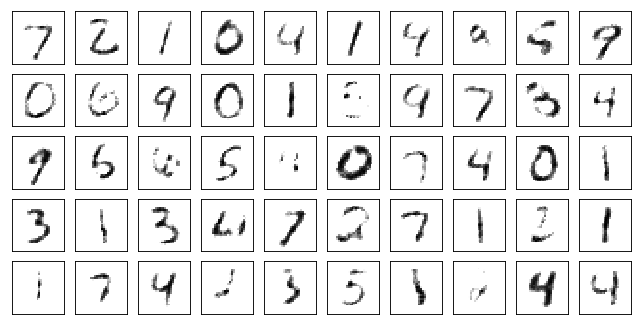

Test set:
64: loss: 0.0783	pho_loss: nan

Train Epoch: 6 [0/50000 (0%)]	Losses 64: 0.074211
Train Epoch: 6 [100/50000 (0%)]	Losses 64: 0.073742
Train Epoch: 6 [150/50000 (0%)]	Losses 64: 0.082837
Train Epoch: 6 [200/50000 (0%)]	Losses 64: 0.075346
Train Epoch: 6 [250/50000 (0%)]	Losses 64: 0.082830
Train Epoch: 6 [300/50000 (1%)]	Losses 64: 0.078018
Train Epoch: 6 [350/50000 (1%)]	Losses 64: 0.081839
Train Epoch: 6 [400/50000 (1%)]	Losses 64: 0.068583
Train Epoch: 6 [450/50000 (1%)]	Losses 64: 0.077603
Train Epoch: 6 [500/50000 (1%)]	Losses 64: 0.078848
Train Epoch: 6 [550/50000 (1%)]	Losses 64: 0.075319
Train Epoch: 6 [600/50000 (1%)]	Losses 64: 0.075680
Train Epoch: 6 [650/50000 (1%)]	Losses 64: 0.077700
Train Epoch: 6 [700/50000 (1%)]	Losses 64: 0.090912
Train Epoch: 6 [750/50000 (2%)]	Losses 64: 0.084155
Train Epoch: 6 [800/50000 (2%)]	Losses 64: 0.079079
Train Epoch: 6 [850/50000 (2%)]	Losses 64: 0.080186
Train Epoch: 6 [900/50000 (2%)]	Losses 64: 0.085434
Train Epoch: 6 [950/5000

Train Epoch: 6 [8800/50000 (18%)]	Losses 64: 0.077787
Train Epoch: 6 [8850/50000 (18%)]	Losses 64: 0.072515
Train Epoch: 6 [8900/50000 (18%)]	Losses 64: 0.076800
Train Epoch: 6 [8950/50000 (18%)]	Losses 64: 0.081299
Train Epoch: 6 [9000/50000 (18%)]	Losses 64: 0.079344
Train Epoch: 6 [9050/50000 (18%)]	Losses 64: 0.070611
Train Epoch: 6 [9100/50000 (18%)]	Losses 64: 0.075491
Train Epoch: 6 [9150/50000 (18%)]	Losses 64: 0.072248
Train Epoch: 6 [9200/50000 (18%)]	Losses 64: 0.080834
Train Epoch: 6 [9250/50000 (18%)]	Losses 64: 0.072508
Train Epoch: 6 [9300/50000 (19%)]	Losses 64: 0.076718
Train Epoch: 6 [9350/50000 (19%)]	Losses 64: 0.069417
Train Epoch: 6 [9400/50000 (19%)]	Losses 64: 0.072761
Train Epoch: 6 [9450/50000 (19%)]	Losses 64: 0.074881
Train Epoch: 6 [9500/50000 (19%)]	Losses 64: 0.067429
Train Epoch: 6 [9550/50000 (19%)]	Losses 64: 0.077151
Train Epoch: 6 [9600/50000 (19%)]	Losses 64: 0.074791
Train Epoch: 6 [9650/50000 (19%)]	Losses 64: 0.072238
Train Epoch: 6 [9700/50000 (

Train Epoch: 6 [16550/50000 (33%)]	Losses 64: 0.074999
Train Epoch: 6 [16600/50000 (33%)]	Losses 64: 0.064708
Train Epoch: 6 [16650/50000 (33%)]	Losses 64: 0.068641
Train Epoch: 6 [16700/50000 (33%)]	Losses 64: 0.078690
Train Epoch: 6 [16750/50000 (34%)]	Losses 64: 0.072072
Train Epoch: 6 [16800/50000 (34%)]	Losses 64: 0.067383
Train Epoch: 6 [16850/50000 (34%)]	Losses 64: 0.070063
Train Epoch: 6 [16900/50000 (34%)]	Losses 64: 0.066606
Train Epoch: 6 [16950/50000 (34%)]	Losses 64: 0.065985
Train Epoch: 6 [17000/50000 (34%)]	Losses 64: 0.076619
Train Epoch: 6 [17050/50000 (34%)]	Losses 64: 0.078603
Train Epoch: 6 [17100/50000 (34%)]	Losses 64: 0.081635
Train Epoch: 6 [17150/50000 (34%)]	Losses 64: 0.072378
Train Epoch: 6 [17200/50000 (34%)]	Losses 64: 0.075382
Train Epoch: 6 [17250/50000 (34%)]	Losses 64: 0.072268
Train Epoch: 6 [17300/50000 (35%)]	Losses 64: 0.073836
Train Epoch: 6 [17350/50000 (35%)]	Losses 64: 0.075089
Train Epoch: 6 [17400/50000 (35%)]	Losses 64: 0.070487
Train Epoc

Train Epoch: 6 [24300/50000 (49%)]	Losses 64: 0.071803
Train Epoch: 6 [24350/50000 (49%)]	Losses 64: 0.077564
Train Epoch: 6 [24400/50000 (49%)]	Losses 64: 0.067885
Train Epoch: 6 [24450/50000 (49%)]	Losses 64: 0.070210
Train Epoch: 6 [24500/50000 (49%)]	Losses 64: 0.070830
Train Epoch: 6 [24550/50000 (49%)]	Losses 64: 0.069996
Train Epoch: 6 [24600/50000 (49%)]	Losses 64: 0.071615
Train Epoch: 6 [24650/50000 (49%)]	Losses 64: 0.075270
Train Epoch: 6 [24700/50000 (49%)]	Losses 64: 0.071983
Train Epoch: 6 [24750/50000 (50%)]	Losses 64: 0.073966
Train Epoch: 6 [24800/50000 (50%)]	Losses 64: 0.073359
Train Epoch: 6 [24850/50000 (50%)]	Losses 64: 0.064884
Train Epoch: 6 [24900/50000 (50%)]	Losses 64: 0.072336
Train Epoch: 6 [24950/50000 (50%)]	Losses 64: 0.073339
Train Epoch: 6 [25000/50000 (50%)]	Losses 64: 0.071781
Train Epoch: 6 [25050/50000 (50%)]	Losses 64: 0.073469
Train Epoch: 6 [25100/50000 (50%)]	Losses 64: 0.067562
Train Epoch: 6 [25150/50000 (50%)]	Losses 64: 0.071583
Train Epoc

Train Epoch: 6 [32500/50000 (65%)]	Losses 64: 0.067991
Train Epoch: 6 [32550/50000 (65%)]	Losses 64: 0.068090
Train Epoch: 6 [32600/50000 (65%)]	Losses 64: 0.068823
Train Epoch: 6 [32650/50000 (65%)]	Losses 64: 0.067094
Train Epoch: 6 [32700/50000 (65%)]	Losses 64: 0.069250
Train Epoch: 6 [32750/50000 (66%)]	Losses 64: 0.068982
Train Epoch: 6 [32800/50000 (66%)]	Losses 64: 0.071456
Train Epoch: 6 [32850/50000 (66%)]	Losses 64: 0.068346
Train Epoch: 6 [32900/50000 (66%)]	Losses 64: 0.067992
Train Epoch: 6 [32950/50000 (66%)]	Losses 64: 0.075887
Train Epoch: 6 [33000/50000 (66%)]	Losses 64: 0.064546
Train Epoch: 6 [33050/50000 (66%)]	Losses 64: 0.067081
Train Epoch: 6 [33100/50000 (66%)]	Losses 64: 0.069513
Train Epoch: 6 [33150/50000 (66%)]	Losses 64: 0.067719
Train Epoch: 6 [33200/50000 (66%)]	Losses 64: 0.072405
Train Epoch: 6 [33250/50000 (66%)]	Losses 64: 0.070182
Train Epoch: 6 [33300/50000 (67%)]	Losses 64: 0.068310
Train Epoch: 6 [33350/50000 (67%)]	Losses 64: 0.073411
Train Epoc

Train Epoch: 6 [40200/50000 (80%)]	Losses 64: 0.069444
Train Epoch: 6 [40250/50000 (80%)]	Losses 64: 0.073896
Train Epoch: 6 [40300/50000 (81%)]	Losses 64: 0.071635
Train Epoch: 6 [40350/50000 (81%)]	Losses 64: 0.073900
Train Epoch: 6 [40400/50000 (81%)]	Losses 64: 0.068085
Train Epoch: 6 [40450/50000 (81%)]	Losses 64: 0.065255
Train Epoch: 6 [40500/50000 (81%)]	Losses 64: 0.068703
Train Epoch: 6 [40550/50000 (81%)]	Losses 64: 0.063785
Train Epoch: 6 [40600/50000 (81%)]	Losses 64: 0.068624
Train Epoch: 6 [40650/50000 (81%)]	Losses 64: 0.067441
Train Epoch: 6 [40700/50000 (81%)]	Losses 64: 0.069996
Train Epoch: 6 [40750/50000 (82%)]	Losses 64: 0.064365
Train Epoch: 6 [40800/50000 (82%)]	Losses 64: 0.070259
Train Epoch: 6 [40850/50000 (82%)]	Losses 64: 0.071155
Train Epoch: 6 [40900/50000 (82%)]	Losses 64: 0.063426
Train Epoch: 6 [40950/50000 (82%)]	Losses 64: 0.072245
Train Epoch: 6 [41000/50000 (82%)]	Losses 64: 0.066972
Train Epoch: 6 [41050/50000 (82%)]	Losses 64: 0.066963
Train Epoc

Train Epoch: 6 [47850/50000 (96%)]	Losses 64: 0.068717
Train Epoch: 6 [47900/50000 (96%)]	Losses 64: 0.064526
Train Epoch: 6 [47950/50000 (96%)]	Losses 64: 0.074823
Train Epoch: 6 [48000/50000 (96%)]	Losses 64: 0.067051
Train Epoch: 6 [48050/50000 (96%)]	Losses 64: 0.057662
Train Epoch: 6 [48100/50000 (96%)]	Losses 64: 0.066165
Train Epoch: 6 [48150/50000 (96%)]	Losses 64: 0.064407
Train Epoch: 6 [48200/50000 (96%)]	Losses 64: 0.063434
Train Epoch: 6 [48250/50000 (96%)]	Losses 64: 0.060675
Train Epoch: 6 [48300/50000 (97%)]	Losses 64: 0.065922
Train Epoch: 6 [48350/50000 (97%)]	Losses 64: 0.065993
Train Epoch: 6 [48400/50000 (97%)]	Losses 64: 0.064628
Train Epoch: 6 [48450/50000 (97%)]	Losses 64: 0.069742
Train Epoch: 6 [48500/50000 (97%)]	Losses 64: 0.065181
Train Epoch: 6 [48550/50000 (97%)]	Losses 64: 0.067872
Train Epoch: 6 [48600/50000 (97%)]	Losses 64: 0.063184
Train Epoch: 6 [48650/50000 (97%)]	Losses 64: 0.078140
Train Epoch: 6 [48700/50000 (97%)]	Losses 64: 0.063015
Train Epoc

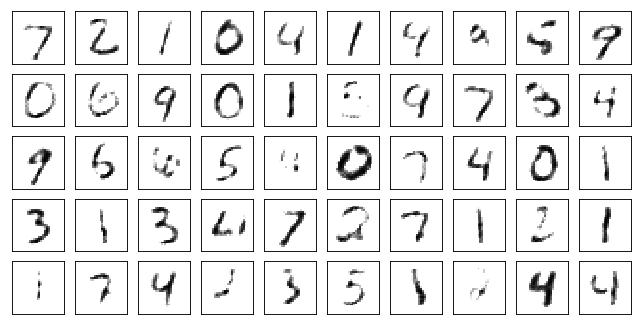

Test set:
64: loss: 0.0668	pho_loss: nan

Train Epoch: 7 [0/50000 (0%)]	Losses 64: 0.068921
Train Epoch: 7 [100/50000 (0%)]	Losses 64: 0.063550
Train Epoch: 7 [150/50000 (0%)]	Losses 64: 0.075263
Train Epoch: 7 [200/50000 (0%)]	Losses 64: 0.065149
Train Epoch: 7 [250/50000 (0%)]	Losses 64: 0.068426
Train Epoch: 7 [300/50000 (1%)]	Losses 64: 0.070683
Train Epoch: 7 [350/50000 (1%)]	Losses 64: 0.066243
Train Epoch: 7 [400/50000 (1%)]	Losses 64: 0.065373
Train Epoch: 7 [450/50000 (1%)]	Losses 64: 0.068510
Train Epoch: 7 [500/50000 (1%)]	Losses 64: 0.069984
Train Epoch: 7 [550/50000 (1%)]	Losses 64: 0.066983
Train Epoch: 7 [600/50000 (1%)]	Losses 64: 0.064258
Train Epoch: 7 [650/50000 (1%)]	Losses 64: 0.061932
Train Epoch: 7 [700/50000 (1%)]	Losses 64: 0.066322
Train Epoch: 7 [750/50000 (2%)]	Losses 64: 0.060836
Train Epoch: 7 [800/50000 (2%)]	Losses 64: 0.063189
Train Epoch: 7 [850/50000 (2%)]	Losses 64: 0.068489
Train Epoch: 7 [900/50000 (2%)]	Losses 64: 0.063353
Train Epoch: 7 [950/5000

Train Epoch: 7 [8750/50000 (18%)]	Losses 64: 0.065645
Train Epoch: 7 [8800/50000 (18%)]	Losses 64: 0.075790
Train Epoch: 7 [8850/50000 (18%)]	Losses 64: 0.069418
Train Epoch: 7 [8900/50000 (18%)]	Losses 64: 0.067170
Train Epoch: 7 [8950/50000 (18%)]	Losses 64: 0.061127
Train Epoch: 7 [9000/50000 (18%)]	Losses 64: 0.065957
Train Epoch: 7 [9050/50000 (18%)]	Losses 64: 0.066944
Train Epoch: 7 [9100/50000 (18%)]	Losses 64: 0.060931
Train Epoch: 7 [9150/50000 (18%)]	Losses 64: 0.061879
Train Epoch: 7 [9200/50000 (18%)]	Losses 64: 0.070171
Train Epoch: 7 [9250/50000 (18%)]	Losses 64: 0.067898
Train Epoch: 7 [9300/50000 (19%)]	Losses 64: 0.059328
Train Epoch: 7 [9350/50000 (19%)]	Losses 64: 0.066381
Train Epoch: 7 [9400/50000 (19%)]	Losses 64: 0.066919
Train Epoch: 7 [9450/50000 (19%)]	Losses 64: 0.070387
Train Epoch: 7 [9500/50000 (19%)]	Losses 64: 0.061157
Train Epoch: 7 [9550/50000 (19%)]	Losses 64: 0.064731
Train Epoch: 7 [9600/50000 (19%)]	Losses 64: 0.071703
Train Epoch: 7 [9650/50000 (

Train Epoch: 7 [16500/50000 (33%)]	Losses 64: 0.060676
Train Epoch: 7 [16550/50000 (33%)]	Losses 64: 0.071771
Train Epoch: 7 [16600/50000 (33%)]	Losses 64: 0.058508
Train Epoch: 7 [16650/50000 (33%)]	Losses 64: 0.054522
Train Epoch: 7 [16700/50000 (33%)]	Losses 64: 0.062607
Train Epoch: 7 [16750/50000 (34%)]	Losses 64: 0.064056
Train Epoch: 7 [16800/50000 (34%)]	Losses 64: 0.055900
Train Epoch: 7 [16850/50000 (34%)]	Losses 64: 0.064020
Train Epoch: 7 [16900/50000 (34%)]	Losses 64: 0.056979
Train Epoch: 7 [16950/50000 (34%)]	Losses 64: 0.060695
Train Epoch: 7 [17000/50000 (34%)]	Losses 64: 0.060918
Train Epoch: 7 [17050/50000 (34%)]	Losses 64: 0.059510
Train Epoch: 7 [17100/50000 (34%)]	Losses 64: 0.068665
Train Epoch: 7 [17150/50000 (34%)]	Losses 64: 0.073409
Train Epoch: 7 [17200/50000 (34%)]	Losses 64: 0.066444
Train Epoch: 7 [17250/50000 (34%)]	Losses 64: 0.054787
Train Epoch: 7 [17300/50000 (35%)]	Losses 64: 0.068857
Train Epoch: 7 [17350/50000 (35%)]	Losses 64: 0.067849
Train Epoc

Train Epoch: 7 [24200/50000 (48%)]	Losses 64: 0.063243
Train Epoch: 7 [24250/50000 (48%)]	Losses 64: 0.057347
Train Epoch: 7 [24300/50000 (49%)]	Losses 64: 0.061907
Train Epoch: 7 [24350/50000 (49%)]	Losses 64: 0.064686
Train Epoch: 7 [24400/50000 (49%)]	Losses 64: 0.055824
Train Epoch: 7 [24450/50000 (49%)]	Losses 64: 0.061203
Train Epoch: 7 [24500/50000 (49%)]	Losses 64: 0.055370
Train Epoch: 7 [24550/50000 (49%)]	Losses 64: 0.064853
Train Epoch: 7 [24600/50000 (49%)]	Losses 64: 0.064801
Train Epoch: 7 [24650/50000 (49%)]	Losses 64: 0.067501
Train Epoch: 7 [24700/50000 (49%)]	Losses 64: 0.063223
Train Epoch: 7 [24750/50000 (50%)]	Losses 64: 0.061586
Train Epoch: 7 [24800/50000 (50%)]	Losses 64: 0.053960
Train Epoch: 7 [24850/50000 (50%)]	Losses 64: 0.064951
Train Epoch: 7 [24900/50000 (50%)]	Losses 64: 0.059320
Train Epoch: 7 [24950/50000 (50%)]	Losses 64: 0.060424
Train Epoch: 7 [25000/50000 (50%)]	Losses 64: 0.060619
Train Epoch: 7 [25050/50000 (50%)]	Losses 64: 0.056524
Train Epoc

Train Epoch: 7 [31900/50000 (64%)]	Losses 64: 0.063312
Train Epoch: 7 [31950/50000 (64%)]	Losses 64: 0.068436
Train Epoch: 7 [32000/50000 (64%)]	Losses 64: 0.064330
Train Epoch: 7 [32050/50000 (64%)]	Losses 64: 0.062887
Train Epoch: 7 [32100/50000 (64%)]	Losses 64: 0.060161
Train Epoch: 7 [32150/50000 (64%)]	Losses 64: 0.057959
Train Epoch: 7 [32200/50000 (64%)]	Losses 64: 0.060875
Train Epoch: 7 [32250/50000 (64%)]	Losses 64: 0.054719
Train Epoch: 7 [32300/50000 (65%)]	Losses 64: 0.055465
Train Epoch: 7 [32350/50000 (65%)]	Losses 64: 0.061302
Train Epoch: 7 [32400/50000 (65%)]	Losses 64: 0.062693
Train Epoch: 7 [32450/50000 (65%)]	Losses 64: 0.061655
Train Epoch: 7 [32500/50000 (65%)]	Losses 64: 0.057703
Train Epoch: 7 [32550/50000 (65%)]	Losses 64: 0.063342
Train Epoch: 7 [32600/50000 (65%)]	Losses 64: 0.057801
Train Epoch: 7 [32650/50000 (65%)]	Losses 64: 0.061860
Train Epoch: 7 [32700/50000 (65%)]	Losses 64: 0.066740
Train Epoch: 7 [32750/50000 (66%)]	Losses 64: 0.061207
Train Epoc

Train Epoch: 7 [39550/50000 (79%)]	Losses 64: 0.057299
Train Epoch: 7 [39600/50000 (79%)]	Losses 64: 0.060260
Train Epoch: 7 [39650/50000 (79%)]	Losses 64: 0.067153
Train Epoch: 7 [39700/50000 (79%)]	Losses 64: 0.061752
Train Epoch: 7 [39750/50000 (80%)]	Losses 64: 0.066120
Train Epoch: 7 [39800/50000 (80%)]	Losses 64: 0.053919
Train Epoch: 7 [39850/50000 (80%)]	Losses 64: 0.056709
Train Epoch: 7 [39900/50000 (80%)]	Losses 64: 0.063900
Train Epoch: 7 [39950/50000 (80%)]	Losses 64: 0.052066
Train Epoch: 7 [40000/50000 (80%)]	Losses 64: 0.060052
Train Epoch: 7 [40000/50000 (80%)]	Losses 64: 0.060138
Train Epoch: 7 [40100/50000 (80%)]	Losses 64: 0.056057
Train Epoch: 7 [40150/50000 (80%)]	Losses 64: 0.063304
Train Epoch: 7 [40200/50000 (80%)]	Losses 64: 0.062300
Train Epoch: 7 [40250/50000 (80%)]	Losses 64: 0.058507
Train Epoch: 7 [40300/50000 (81%)]	Losses 64: 0.065208
Train Epoch: 7 [40350/50000 (81%)]	Losses 64: 0.055527
Train Epoch: 7 [40400/50000 (81%)]	Losses 64: 0.053590
Train Epoc

Train Epoch: 7 [47200/50000 (94%)]	Losses 64: 0.058831
Train Epoch: 7 [47250/50000 (94%)]	Losses 64: 0.058870
Train Epoch: 7 [47300/50000 (95%)]	Losses 64: 0.067816
Train Epoch: 7 [47350/50000 (95%)]	Losses 64: 0.059163
Train Epoch: 7 [47400/50000 (95%)]	Losses 64: 0.055051
Train Epoch: 7 [47450/50000 (95%)]	Losses 64: 0.053679
Train Epoch: 7 [47500/50000 (95%)]	Losses 64: 0.061498
Train Epoch: 7 [47550/50000 (95%)]	Losses 64: 0.060159
Train Epoch: 7 [47600/50000 (95%)]	Losses 64: 0.061440
Train Epoch: 7 [47650/50000 (95%)]	Losses 64: 0.055523
Train Epoch: 7 [47700/50000 (95%)]	Losses 64: 0.058438
Train Epoch: 7 [47750/50000 (96%)]	Losses 64: 0.051320
Train Epoch: 7 [47800/50000 (96%)]	Losses 64: 0.054030
Train Epoch: 7 [47850/50000 (96%)]	Losses 64: 0.057169
Train Epoch: 7 [47900/50000 (96%)]	Losses 64: 0.056001
Train Epoch: 7 [47950/50000 (96%)]	Losses 64: 0.059460
Train Epoch: 7 [48000/50000 (96%)]	Losses 64: 0.057935
Train Epoch: 7 [48050/50000 (96%)]	Losses 64: 0.059150
Train Epoc

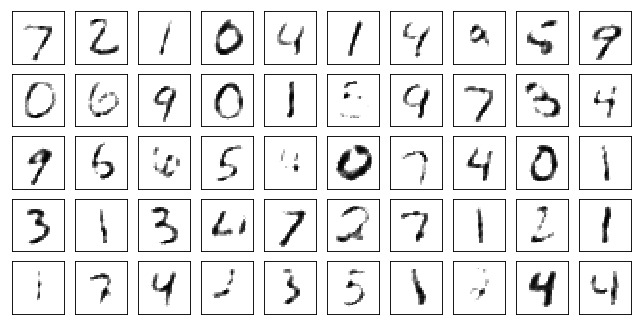

Test set:
64: loss: 0.0586	pho_loss: nan

Train Epoch: 8 [0/50000 (0%)]	Losses 64: 0.062837
Train Epoch: 8 [100/50000 (0%)]	Losses 64: 0.053825
Train Epoch: 8 [150/50000 (0%)]	Losses 64: 0.060013
Train Epoch: 8 [200/50000 (0%)]	Losses 64: 0.052950
Train Epoch: 8 [250/50000 (0%)]	Losses 64: 0.062345
Train Epoch: 8 [300/50000 (1%)]	Losses 64: 0.051682
Train Epoch: 8 [350/50000 (1%)]	Losses 64: 0.049694
Train Epoch: 8 [400/50000 (1%)]	Losses 64: 0.054262
Train Epoch: 8 [450/50000 (1%)]	Losses 64: 0.053917
Train Epoch: 8 [500/50000 (1%)]	Losses 64: 0.056586
Train Epoch: 8 [550/50000 (1%)]	Losses 64: 0.052479
Train Epoch: 8 [600/50000 (1%)]	Losses 64: 0.057460
Train Epoch: 8 [650/50000 (1%)]	Losses 64: 0.053745
Train Epoch: 8 [700/50000 (1%)]	Losses 64: 0.059348
Train Epoch: 8 [750/50000 (2%)]	Losses 64: 0.055899
Train Epoch: 8 [800/50000 (2%)]	Losses 64: 0.058732
Train Epoch: 8 [850/50000 (2%)]	Losses 64: 0.058788
Train Epoch: 8 [900/50000 (2%)]	Losses 64: 0.057526
Train Epoch: 8 [950/5000

Train Epoch: 8 [7750/50000 (16%)]	Losses 64: 0.055236
Train Epoch: 8 [7800/50000 (16%)]	Losses 64: 0.055979
Train Epoch: 8 [7850/50000 (16%)]	Losses 64: 0.059115
Train Epoch: 8 [7900/50000 (16%)]	Losses 64: 0.061862
Train Epoch: 8 [7950/50000 (16%)]	Losses 64: 0.060553
Train Epoch: 8 [8000/50000 (16%)]	Losses 64: 0.063480
Train Epoch: 8 [8050/50000 (16%)]	Losses 64: 0.050497
Train Epoch: 8 [8100/50000 (16%)]	Losses 64: 0.058806
Train Epoch: 8 [8150/50000 (16%)]	Losses 64: 0.056107
Train Epoch: 8 [8200/50000 (16%)]	Losses 64: 0.060120
Train Epoch: 8 [8250/50000 (16%)]	Losses 64: 0.052755
Train Epoch: 8 [8300/50000 (17%)]	Losses 64: 0.056785
Train Epoch: 8 [8350/50000 (17%)]	Losses 64: 0.058078
Train Epoch: 8 [8400/50000 (17%)]	Losses 64: 0.061026
Train Epoch: 8 [8450/50000 (17%)]	Losses 64: 0.056045
Train Epoch: 8 [8500/50000 (17%)]	Losses 64: 0.051341
Train Epoch: 8 [8550/50000 (17%)]	Losses 64: 0.060922
Train Epoch: 8 [8600/50000 (17%)]	Losses 64: 0.058785
Train Epoch: 8 [8650/50000 (

Train Epoch: 8 [15300/50000 (31%)]	Losses 64: 0.052988
Train Epoch: 8 [15350/50000 (31%)]	Losses 64: 0.053593
Train Epoch: 8 [15400/50000 (31%)]	Losses 64: 0.053012
Train Epoch: 8 [15450/50000 (31%)]	Losses 64: 0.058139
Train Epoch: 8 [15500/50000 (31%)]	Losses 64: 0.057021
Train Epoch: 8 [15550/50000 (31%)]	Losses 64: 0.059831
Train Epoch: 8 [15600/50000 (31%)]	Losses 64: 0.056530
Train Epoch: 8 [15650/50000 (31%)]	Losses 64: 0.059663
Train Epoch: 8 [15700/50000 (31%)]	Losses 64: 0.052897
Train Epoch: 8 [15750/50000 (32%)]	Losses 64: 0.056411
Train Epoch: 8 [15800/50000 (32%)]	Losses 64: 0.062636
Train Epoch: 8 [15850/50000 (32%)]	Losses 64: 0.053899
Train Epoch: 8 [15900/50000 (32%)]	Losses 64: 0.057566
Train Epoch: 8 [15950/50000 (32%)]	Losses 64: 0.049545
Train Epoch: 8 [16000/50000 (32%)]	Losses 64: 0.054020
Train Epoch: 8 [16050/50000 (32%)]	Losses 64: 0.060673
Train Epoch: 8 [16100/50000 (32%)]	Losses 64: 0.050046
Train Epoch: 8 [16150/50000 (32%)]	Losses 64: 0.053443
Train Epoc

Train Epoch: 8 [22750/50000 (46%)]	Losses 64: 0.056151
Train Epoch: 8 [22800/50000 (46%)]	Losses 64: 0.060044
Train Epoch: 8 [22850/50000 (46%)]	Losses 64: 0.053871
Train Epoch: 8 [22900/50000 (46%)]	Losses 64: 0.052678
Train Epoch: 8 [22950/50000 (46%)]	Losses 64: 0.058668
Train Epoch: 8 [23000/50000 (46%)]	Losses 64: 0.060474
Train Epoch: 8 [23050/50000 (46%)]	Losses 64: 0.063963
Train Epoch: 8 [23100/50000 (46%)]	Losses 64: 0.059372
Train Epoch: 8 [23150/50000 (46%)]	Losses 64: 0.059522
Train Epoch: 8 [23200/50000 (46%)]	Losses 64: 0.047924
Train Epoch: 8 [23250/50000 (46%)]	Losses 64: 0.056961
Train Epoch: 8 [23300/50000 (47%)]	Losses 64: 0.055120
Train Epoch: 8 [23350/50000 (47%)]	Losses 64: 0.053451
Train Epoch: 8 [23400/50000 (47%)]	Losses 64: 0.056288
Train Epoch: 8 [23450/50000 (47%)]	Losses 64: 0.057801
Train Epoch: 8 [23500/50000 (47%)]	Losses 64: 0.056325
Train Epoch: 8 [23550/50000 (47%)]	Losses 64: 0.050933
Train Epoch: 8 [23600/50000 (47%)]	Losses 64: 0.052900
Train Epoc

Train Epoch: 8 [30350/50000 (61%)]	Losses 64: 0.059680
Train Epoch: 8 [30400/50000 (61%)]	Losses 64: 0.053598
Train Epoch: 8 [30450/50000 (61%)]	Losses 64: 0.057361
Train Epoch: 8 [30500/50000 (61%)]	Losses 64: 0.052942
Train Epoch: 8 [30550/50000 (61%)]	Losses 64: 0.045108
Train Epoch: 8 [30600/50000 (61%)]	Losses 64: 0.051125
Train Epoch: 8 [30650/50000 (61%)]	Losses 64: 0.053539
Train Epoch: 8 [30700/50000 (61%)]	Losses 64: 0.064214
Train Epoch: 8 [30750/50000 (62%)]	Losses 64: 0.050538
Train Epoch: 8 [30800/50000 (62%)]	Losses 64: 0.050603
Train Epoch: 8 [30850/50000 (62%)]	Losses 64: 0.057505
Train Epoch: 8 [30900/50000 (62%)]	Losses 64: 0.052941
Train Epoch: 8 [30950/50000 (62%)]	Losses 64: 0.052193
Train Epoch: 8 [31000/50000 (62%)]	Losses 64: 0.055970
Train Epoch: 8 [31050/50000 (62%)]	Losses 64: 0.055698
Train Epoch: 8 [31100/50000 (62%)]	Losses 64: 0.050050
Train Epoch: 8 [31150/50000 (62%)]	Losses 64: 0.051149
Train Epoch: 8 [31200/50000 (62%)]	Losses 64: 0.050003
Train Epoc

Train Epoch: 8 [38700/50000 (77%)]	Losses 64: 0.048532
Train Epoch: 8 [38750/50000 (78%)]	Losses 64: 0.055631
Train Epoch: 8 [38800/50000 (78%)]	Losses 64: 0.048363
Train Epoch: 8 [38850/50000 (78%)]	Losses 64: 0.052671
Train Epoch: 8 [38900/50000 (78%)]	Losses 64: 0.050491
Train Epoch: 8 [38950/50000 (78%)]	Losses 64: 0.050646
Train Epoch: 8 [39000/50000 (78%)]	Losses 64: 0.051244
Train Epoch: 8 [39050/50000 (78%)]	Losses 64: 0.056444
Train Epoch: 8 [39100/50000 (78%)]	Losses 64: 0.053412
Train Epoch: 8 [39150/50000 (78%)]	Losses 64: 0.057747
Train Epoch: 8 [39200/50000 (78%)]	Losses 64: 0.051569
Train Epoch: 8 [39250/50000 (78%)]	Losses 64: 0.049972
Train Epoch: 8 [39300/50000 (79%)]	Losses 64: 0.049441
Train Epoch: 8 [39350/50000 (79%)]	Losses 64: 0.054903
Train Epoch: 8 [39400/50000 (79%)]	Losses 64: 0.052031
Train Epoch: 8 [39450/50000 (79%)]	Losses 64: 0.058633
Train Epoch: 8 [39500/50000 (79%)]	Losses 64: 0.056755
Train Epoch: 8 [39550/50000 (79%)]	Losses 64: 0.053935
Train Epoc

Train Epoch: 8 [47000/50000 (94%)]	Losses 64: 0.049736
Train Epoch: 8 [47050/50000 (94%)]	Losses 64: 0.056529
Train Epoch: 8 [47100/50000 (94%)]	Losses 64: 0.053814
Train Epoch: 8 [47150/50000 (94%)]	Losses 64: 0.047173
Train Epoch: 8 [47200/50000 (94%)]	Losses 64: 0.052267
Train Epoch: 8 [47250/50000 (94%)]	Losses 64: 0.054020
Train Epoch: 8 [47300/50000 (95%)]	Losses 64: 0.050252
Train Epoch: 8 [47350/50000 (95%)]	Losses 64: 0.049801
Train Epoch: 8 [47400/50000 (95%)]	Losses 64: 0.049509
Train Epoch: 8 [47450/50000 (95%)]	Losses 64: 0.052706
Train Epoch: 8 [47500/50000 (95%)]	Losses 64: 0.051737
Train Epoch: 8 [47550/50000 (95%)]	Losses 64: 0.050283
Train Epoch: 8 [47600/50000 (95%)]	Losses 64: 0.053649
Train Epoch: 8 [47650/50000 (95%)]	Losses 64: 0.050741
Train Epoch: 8 [47700/50000 (95%)]	Losses 64: 0.051561
Train Epoch: 8 [47750/50000 (96%)]	Losses 64: 0.055381
Train Epoch: 8 [47800/50000 (96%)]	Losses 64: 0.056389
Train Epoch: 8 [47850/50000 (96%)]	Losses 64: 0.047011
Train Epoc

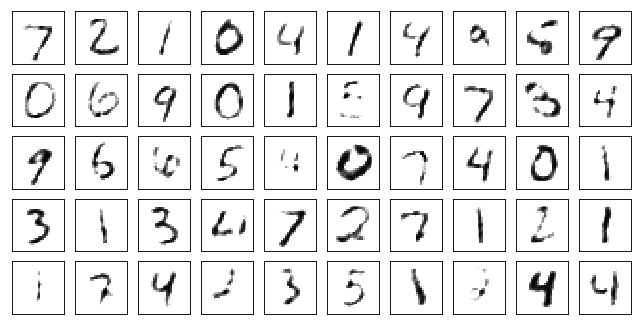

Test set:
64: loss: 0.0526	pho_loss: nan

Train Epoch: 9 [0/50000 (0%)]	Losses 64: 0.050910
Train Epoch: 9 [100/50000 (0%)]	Losses 64: 0.052326
Train Epoch: 9 [150/50000 (0%)]	Losses 64: 0.047292
Train Epoch: 9 [200/50000 (0%)]	Losses 64: 0.052696
Train Epoch: 9 [250/50000 (0%)]	Losses 64: 0.048407
Train Epoch: 9 [300/50000 (1%)]	Losses 64: 0.054355
Train Epoch: 9 [350/50000 (1%)]	Losses 64: 0.053224
Train Epoch: 9 [400/50000 (1%)]	Losses 64: 0.051339
Train Epoch: 9 [450/50000 (1%)]	Losses 64: 0.053572
Train Epoch: 9 [500/50000 (1%)]	Losses 64: 0.047560
Train Epoch: 9 [550/50000 (1%)]	Losses 64: 0.051966
Train Epoch: 9 [600/50000 (1%)]	Losses 64: 0.054648
Train Epoch: 9 [650/50000 (1%)]	Losses 64: 0.051032
Train Epoch: 9 [700/50000 (1%)]	Losses 64: 0.049317
Train Epoch: 9 [750/50000 (2%)]	Losses 64: 0.050376
Train Epoch: 9 [800/50000 (2%)]	Losses 64: 0.056996
Train Epoch: 9 [850/50000 (2%)]	Losses 64: 0.045572
Train Epoch: 9 [900/50000 (2%)]	Losses 64: 0.048385
Train Epoch: 9 [950/5000

Train Epoch: 9 [8500/50000 (17%)]	Losses 64: 0.049309
Train Epoch: 9 [8550/50000 (17%)]	Losses 64: 0.053104
Train Epoch: 9 [8600/50000 (17%)]	Losses 64: 0.057149
Train Epoch: 9 [8650/50000 (17%)]	Losses 64: 0.048108
Train Epoch: 9 [8700/50000 (17%)]	Losses 64: 0.052107
Train Epoch: 9 [8750/50000 (18%)]	Losses 64: 0.055007
Train Epoch: 9 [8800/50000 (18%)]	Losses 64: 0.049668
Train Epoch: 9 [8850/50000 (18%)]	Losses 64: 0.043644
Train Epoch: 9 [8900/50000 (18%)]	Losses 64: 0.049953
Train Epoch: 9 [8950/50000 (18%)]	Losses 64: 0.054057
Train Epoch: 9 [9000/50000 (18%)]	Losses 64: 0.050467
Train Epoch: 9 [9050/50000 (18%)]	Losses 64: 0.050611
Train Epoch: 9 [9100/50000 (18%)]	Losses 64: 0.053141
Train Epoch: 9 [9150/50000 (18%)]	Losses 64: 0.046348
Train Epoch: 9 [9200/50000 (18%)]	Losses 64: 0.056678
Train Epoch: 9 [9250/50000 (18%)]	Losses 64: 0.048739
Train Epoch: 9 [9300/50000 (19%)]	Losses 64: 0.051912
Train Epoch: 9 [9350/50000 (19%)]	Losses 64: 0.050508
Train Epoch: 9 [9400/50000 (

Train Epoch: 9 [16100/50000 (32%)]	Losses 64: 0.053234
Train Epoch: 9 [16150/50000 (32%)]	Losses 64: 0.047530
Train Epoch: 9 [16200/50000 (32%)]	Losses 64: 0.055795
Train Epoch: 9 [16250/50000 (32%)]	Losses 64: 0.049107
Train Epoch: 9 [16300/50000 (33%)]	Losses 64: 0.045603
Train Epoch: 9 [16350/50000 (33%)]	Losses 64: 0.049168
Train Epoch: 9 [16400/50000 (33%)]	Losses 64: 0.046151
Train Epoch: 9 [16450/50000 (33%)]	Losses 64: 0.047929
Train Epoch: 9 [16500/50000 (33%)]	Losses 64: 0.054951
Train Epoch: 9 [16550/50000 (33%)]	Losses 64: 0.055147
Train Epoch: 9 [16600/50000 (33%)]	Losses 64: 0.042907
Train Epoch: 9 [16650/50000 (33%)]	Losses 64: 0.047017
Train Epoch: 9 [16700/50000 (33%)]	Losses 64: 0.049028
Train Epoch: 9 [16750/50000 (34%)]	Losses 64: 0.048260
Train Epoch: 9 [16800/50000 (34%)]	Losses 64: 0.050580
Train Epoch: 9 [16850/50000 (34%)]	Losses 64: 0.053969
Train Epoch: 9 [16900/50000 (34%)]	Losses 64: 0.043911
Train Epoch: 9 [16950/50000 (34%)]	Losses 64: 0.046210
Train Epoc

Train Epoch: 9 [24350/50000 (49%)]	Losses 64: 0.048397
Train Epoch: 9 [24400/50000 (49%)]	Losses 64: 0.043131
Train Epoch: 9 [24450/50000 (49%)]	Losses 64: 0.055991
Train Epoch: 9 [24500/50000 (49%)]	Losses 64: 0.053739
Train Epoch: 9 [24550/50000 (49%)]	Losses 64: 0.045037
Train Epoch: 9 [24600/50000 (49%)]	Losses 64: 0.047426
Train Epoch: 9 [24650/50000 (49%)]	Losses 64: 0.047146
Train Epoch: 9 [24700/50000 (49%)]	Losses 64: 0.048139
Train Epoch: 9 [24750/50000 (50%)]	Losses 64: 0.052198
Train Epoch: 9 [24800/50000 (50%)]	Losses 64: 0.050927
Train Epoch: 9 [24850/50000 (50%)]	Losses 64: 0.050213
Train Epoch: 9 [24900/50000 (50%)]	Losses 64: 0.047405
Train Epoch: 9 [24950/50000 (50%)]	Losses 64: 0.048127
Train Epoch: 9 [25000/50000 (50%)]	Losses 64: 0.051843
Train Epoch: 9 [25050/50000 (50%)]	Losses 64: 0.052118
Train Epoch: 9 [25100/50000 (50%)]	Losses 64: 0.055528
Train Epoch: 9 [25150/50000 (50%)]	Losses 64: 0.047047
Train Epoch: 9 [25200/50000 (50%)]	Losses 64: 0.041877
Train Epoc

Train Epoch: 9 [32400/50000 (65%)]	Losses 64: 0.053689
Train Epoch: 9 [32450/50000 (65%)]	Losses 64: 0.045566
Train Epoch: 9 [32500/50000 (65%)]	Losses 64: 0.047173
Train Epoch: 9 [32550/50000 (65%)]	Losses 64: 0.048169
Train Epoch: 9 [32600/50000 (65%)]	Losses 64: 0.048196
Train Epoch: 9 [32650/50000 (65%)]	Losses 64: 0.047394
Train Epoch: 9 [32700/50000 (65%)]	Losses 64: 0.043267
Train Epoch: 9 [32750/50000 (66%)]	Losses 64: 0.050063
Train Epoch: 9 [32800/50000 (66%)]	Losses 64: 0.045844
Train Epoch: 9 [32850/50000 (66%)]	Losses 64: 0.045899
Train Epoch: 9 [32900/50000 (66%)]	Losses 64: 0.048470
Train Epoch: 9 [32950/50000 (66%)]	Losses 64: 0.054183
Train Epoch: 9 [33000/50000 (66%)]	Losses 64: 0.048555
Train Epoch: 9 [33050/50000 (66%)]	Losses 64: 0.045706
Train Epoch: 9 [33100/50000 (66%)]	Losses 64: 0.051950
Train Epoch: 9 [33150/50000 (66%)]	Losses 64: 0.048585
Train Epoch: 9 [33200/50000 (66%)]	Losses 64: 0.050145
Train Epoch: 9 [33250/50000 (66%)]	Losses 64: 0.048924
Train Epoc

Train Epoch: 9 [39850/50000 (80%)]	Losses 64: 0.048217
Train Epoch: 9 [39900/50000 (80%)]	Losses 64: 0.051906
Train Epoch: 9 [39950/50000 (80%)]	Losses 64: 0.047079
Train Epoch: 9 [40000/50000 (80%)]	Losses 64: 0.047583
Train Epoch: 9 [40000/50000 (80%)]	Losses 64: 0.045552
Train Epoch: 9 [40100/50000 (80%)]	Losses 64: 0.049250
Train Epoch: 9 [40150/50000 (80%)]	Losses 64: 0.051147
Train Epoch: 9 [40200/50000 (80%)]	Losses 64: 0.050939
Train Epoch: 9 [40250/50000 (80%)]	Losses 64: 0.049174
Train Epoch: 9 [40300/50000 (81%)]	Losses 64: 0.051335
Train Epoch: 9 [40350/50000 (81%)]	Losses 64: 0.044058
Train Epoch: 9 [40400/50000 (81%)]	Losses 64: 0.047918
Train Epoch: 9 [40450/50000 (81%)]	Losses 64: 0.047763
Train Epoch: 9 [40500/50000 (81%)]	Losses 64: 0.048840
Train Epoch: 9 [40550/50000 (81%)]	Losses 64: 0.047111
Train Epoch: 9 [40600/50000 (81%)]	Losses 64: 0.046550
Train Epoch: 9 [40650/50000 (81%)]	Losses 64: 0.045362
Train Epoch: 9 [40700/50000 (81%)]	Losses 64: 0.050654
Train Epoc

Train Epoch: 9 [48050/50000 (96%)]	Losses 64: 0.050863
Train Epoch: 9 [48100/50000 (96%)]	Losses 64: 0.049752
Train Epoch: 9 [48150/50000 (96%)]	Losses 64: 0.050006
Train Epoch: 9 [48200/50000 (96%)]	Losses 64: 0.047850
Train Epoch: 9 [48250/50000 (96%)]	Losses 64: 0.047079
Train Epoch: 9 [48300/50000 (97%)]	Losses 64: 0.052861
Train Epoch: 9 [48350/50000 (97%)]	Losses 64: 0.043128
Train Epoch: 9 [48400/50000 (97%)]	Losses 64: 0.046421
Train Epoch: 9 [48450/50000 (97%)]	Losses 64: 0.039391
Train Epoch: 9 [48500/50000 (97%)]	Losses 64: 0.049443
Train Epoch: 9 [48550/50000 (97%)]	Losses 64: 0.049488
Train Epoch: 9 [48600/50000 (97%)]	Losses 64: 0.049603
Train Epoch: 9 [48650/50000 (97%)]	Losses 64: 0.045772
Train Epoch: 9 [48700/50000 (97%)]	Losses 64: 0.049300
Train Epoch: 9 [48750/50000 (98%)]	Losses 64: 0.049433
Train Epoch: 9 [48800/50000 (98%)]	Losses 64: 0.045389
Train Epoch: 9 [48850/50000 (98%)]	Losses 64: 0.052861
Train Epoch: 9 [48900/50000 (98%)]	Losses 64: 0.049552
Train Epoc

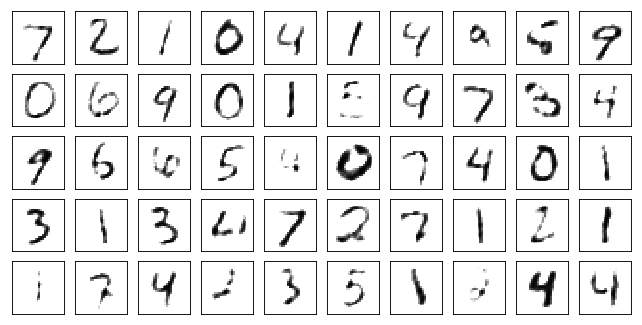

Test set:
64: loss: 0.0478	pho_loss: nan

Train Epoch: 10 [0/50000 (0%)]	Losses 64: 0.050826
Train Epoch: 10 [100/50000 (0%)]	Losses 64: 0.044140
Train Epoch: 10 [150/50000 (0%)]	Losses 64: 0.046062
Train Epoch: 10 [200/50000 (0%)]	Losses 64: 0.045568
Train Epoch: 10 [250/50000 (0%)]	Losses 64: 0.044268
Train Epoch: 10 [300/50000 (1%)]	Losses 64: 0.044842
Train Epoch: 10 [350/50000 (1%)]	Losses 64: 0.049035
Train Epoch: 10 [400/50000 (1%)]	Losses 64: 0.046253
Train Epoch: 10 [450/50000 (1%)]	Losses 64: 0.048876
Train Epoch: 10 [500/50000 (1%)]	Losses 64: 0.048358
Train Epoch: 10 [550/50000 (1%)]	Losses 64: 0.047396
Train Epoch: 10 [600/50000 (1%)]	Losses 64: 0.045543
Train Epoch: 10 [650/50000 (1%)]	Losses 64: 0.047312
Train Epoch: 10 [700/50000 (1%)]	Losses 64: 0.051276
Train Epoch: 10 [750/50000 (2%)]	Losses 64: 0.049193
Train Epoch: 10 [800/50000 (2%)]	Losses 64: 0.041029
Train Epoch: 10 [850/50000 (2%)]	Losses 64: 0.047062
Train Epoch: 10 [900/50000 (2%)]	Losses 64: 0.046259
Train 

Train Epoch: 10 [7750/50000 (16%)]	Losses 64: 0.045905
Train Epoch: 10 [7800/50000 (16%)]	Losses 64: 0.045238
Train Epoch: 10 [7850/50000 (16%)]	Losses 64: 0.047038
Train Epoch: 10 [7900/50000 (16%)]	Losses 64: 0.046843
Train Epoch: 10 [7950/50000 (16%)]	Losses 64: 0.051146
Train Epoch: 10 [8000/50000 (16%)]	Losses 64: 0.047861
Train Epoch: 10 [8050/50000 (16%)]	Losses 64: 0.042506
Train Epoch: 10 [8100/50000 (16%)]	Losses 64: 0.053571
Train Epoch: 10 [8150/50000 (16%)]	Losses 64: 0.046266
Train Epoch: 10 [8200/50000 (16%)]	Losses 64: 0.045720
Train Epoch: 10 [8250/50000 (16%)]	Losses 64: 0.045243
Train Epoch: 10 [8300/50000 (17%)]	Losses 64: 0.048720
Train Epoch: 10 [8350/50000 (17%)]	Losses 64: 0.047681
Train Epoch: 10 [8400/50000 (17%)]	Losses 64: 0.052325
Train Epoch: 10 [8450/50000 (17%)]	Losses 64: 0.047945
Train Epoch: 10 [8500/50000 (17%)]	Losses 64: 0.045517
Train Epoch: 10 [8550/50000 (17%)]	Losses 64: 0.049864
Train Epoch: 10 [8600/50000 (17%)]	Losses 64: 0.049366
Train Epoc

Train Epoch: 10 [15500/50000 (31%)]	Losses 64: 0.043361
Train Epoch: 10 [15550/50000 (31%)]	Losses 64: 0.045999
Train Epoch: 10 [15600/50000 (31%)]	Losses 64: 0.047000
Train Epoch: 10 [15650/50000 (31%)]	Losses 64: 0.041808
Train Epoch: 10 [15700/50000 (31%)]	Losses 64: 0.049074
Train Epoch: 10 [15750/50000 (32%)]	Losses 64: 0.054229
Train Epoch: 10 [15800/50000 (32%)]	Losses 64: 0.043169
Train Epoch: 10 [15850/50000 (32%)]	Losses 64: 0.045769
Train Epoch: 10 [15900/50000 (32%)]	Losses 64: 0.044091
Train Epoch: 10 [15950/50000 (32%)]	Losses 64: 0.041855
Train Epoch: 10 [16000/50000 (32%)]	Losses 64: 0.048264
Train Epoch: 10 [16050/50000 (32%)]	Losses 64: 0.051535
Train Epoch: 10 [16100/50000 (32%)]	Losses 64: 0.048275
Train Epoch: 10 [16150/50000 (32%)]	Losses 64: 0.049573
Train Epoch: 10 [16200/50000 (32%)]	Losses 64: 0.049183
Train Epoch: 10 [16250/50000 (32%)]	Losses 64: 0.042289
Train Epoch: 10 [16300/50000 (33%)]	Losses 64: 0.045145
Train Epoch: 10 [16350/50000 (33%)]	Losses 64: 0

Train Epoch: 10 [23050/50000 (46%)]	Losses 64: 0.044181
Train Epoch: 10 [23100/50000 (46%)]	Losses 64: 0.044450
Train Epoch: 10 [23150/50000 (46%)]	Losses 64: 0.045798
Train Epoch: 10 [23200/50000 (46%)]	Losses 64: 0.044459
Train Epoch: 10 [23250/50000 (46%)]	Losses 64: 0.041649
Train Epoch: 10 [23300/50000 (47%)]	Losses 64: 0.040020
Train Epoch: 10 [23350/50000 (47%)]	Losses 64: 0.048274
Train Epoch: 10 [23400/50000 (47%)]	Losses 64: 0.042910
Train Epoch: 10 [23450/50000 (47%)]	Losses 64: 0.045812
Train Epoch: 10 [23500/50000 (47%)]	Losses 64: 0.042782
Train Epoch: 10 [23550/50000 (47%)]	Losses 64: 0.045397
Train Epoch: 10 [23600/50000 (47%)]	Losses 64: 0.052294
Train Epoch: 10 [23650/50000 (47%)]	Losses 64: 0.047791
Train Epoch: 10 [23700/50000 (47%)]	Losses 64: 0.045966
Train Epoch: 10 [23750/50000 (48%)]	Losses 64: 0.047834
Train Epoch: 10 [23800/50000 (48%)]	Losses 64: 0.045685
Train Epoch: 10 [23850/50000 (48%)]	Losses 64: 0.045302
Train Epoch: 10 [23900/50000 (48%)]	Losses 64: 0

Train Epoch: 10 [31050/50000 (62%)]	Losses 64: 0.047451
Train Epoch: 10 [31100/50000 (62%)]	Losses 64: 0.044696
Train Epoch: 10 [31150/50000 (62%)]	Losses 64: 0.046000
Train Epoch: 10 [31200/50000 (62%)]	Losses 64: 0.044456
Train Epoch: 10 [31250/50000 (62%)]	Losses 64: 0.039422
Train Epoch: 10 [31300/50000 (63%)]	Losses 64: 0.048070
Train Epoch: 10 [31350/50000 (63%)]	Losses 64: 0.044459
Train Epoch: 10 [31400/50000 (63%)]	Losses 64: 0.045349
Train Epoch: 10 [31450/50000 (63%)]	Losses 64: 0.042709
Train Epoch: 10 [31500/50000 (63%)]	Losses 64: 0.045463
Train Epoch: 10 [31550/50000 (63%)]	Losses 64: 0.050089
Train Epoch: 10 [31600/50000 (63%)]	Losses 64: 0.041362
Train Epoch: 10 [31650/50000 (63%)]	Losses 64: 0.045447
Train Epoch: 10 [31700/50000 (63%)]	Losses 64: 0.046692
Train Epoch: 10 [31750/50000 (64%)]	Losses 64: 0.047059
Train Epoch: 10 [31800/50000 (64%)]	Losses 64: 0.048567
Train Epoch: 10 [31850/50000 (64%)]	Losses 64: 0.041159
Train Epoch: 10 [31900/50000 (64%)]	Losses 64: 0

Train Epoch: 10 [38800/50000 (78%)]	Losses 64: 0.045428
Train Epoch: 10 [38850/50000 (78%)]	Losses 64: 0.041785
Train Epoch: 10 [38900/50000 (78%)]	Losses 64: 0.040496
Train Epoch: 10 [38950/50000 (78%)]	Losses 64: 0.046253
Train Epoch: 10 [39000/50000 (78%)]	Losses 64: 0.045628
Train Epoch: 10 [39050/50000 (78%)]	Losses 64: 0.046376
Train Epoch: 10 [39100/50000 (78%)]	Losses 64: 0.041086
Train Epoch: 10 [39150/50000 (78%)]	Losses 64: 0.045982
Train Epoch: 10 [39200/50000 (78%)]	Losses 64: 0.039777
Train Epoch: 10 [39250/50000 (78%)]	Losses 64: 0.041472
Train Epoch: 10 [39300/50000 (79%)]	Losses 64: 0.047519
Train Epoch: 10 [39350/50000 (79%)]	Losses 64: 0.043514
Train Epoch: 10 [39400/50000 (79%)]	Losses 64: 0.040692
Train Epoch: 10 [39450/50000 (79%)]	Losses 64: 0.040013
Train Epoch: 10 [39500/50000 (79%)]	Losses 64: 0.045557
Train Epoch: 10 [39550/50000 (79%)]	Losses 64: 0.046574
Train Epoch: 10 [39600/50000 (79%)]	Losses 64: 0.047726
Train Epoch: 10 [39650/50000 (79%)]	Losses 64: 0

Train Epoch: 10 [46900/50000 (94%)]	Losses 64: 0.041937
Train Epoch: 10 [46950/50000 (94%)]	Losses 64: 0.047919
Train Epoch: 10 [47000/50000 (94%)]	Losses 64: 0.044762
Train Epoch: 10 [47050/50000 (94%)]	Losses 64: 0.047006
Train Epoch: 10 [47100/50000 (94%)]	Losses 64: 0.045115
Train Epoch: 10 [47150/50000 (94%)]	Losses 64: 0.038331
Train Epoch: 10 [47200/50000 (94%)]	Losses 64: 0.044153
Train Epoch: 10 [47250/50000 (94%)]	Losses 64: 0.043575
Train Epoch: 10 [47300/50000 (95%)]	Losses 64: 0.043216
Train Epoch: 10 [47350/50000 (95%)]	Losses 64: 0.044158
Train Epoch: 10 [47400/50000 (95%)]	Losses 64: 0.042586
Train Epoch: 10 [47450/50000 (95%)]	Losses 64: 0.042191
Train Epoch: 10 [47500/50000 (95%)]	Losses 64: 0.044739
Train Epoch: 10 [47550/50000 (95%)]	Losses 64: 0.043760
Train Epoch: 10 [47600/50000 (95%)]	Losses 64: 0.040181
Train Epoch: 10 [47650/50000 (95%)]	Losses 64: 0.051079
Train Epoch: 10 [47700/50000 (95%)]	Losses 64: 0.044671
Train Epoch: 10 [47750/50000 (96%)]	Losses 64: 0

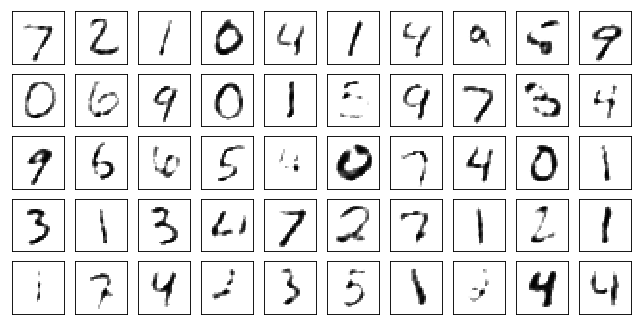

Test set:
64: loss: 0.0441	pho_loss: nan

Train Epoch: 11 [0/50000 (0%)]	Losses 64: 0.042150
Train Epoch: 11 [100/50000 (0%)]	Losses 64: 0.042340
Train Epoch: 11 [150/50000 (0%)]	Losses 64: 0.042256
Train Epoch: 11 [200/50000 (0%)]	Losses 64: 0.040203
Train Epoch: 11 [250/50000 (0%)]	Losses 64: 0.041298
Train Epoch: 11 [300/50000 (1%)]	Losses 64: 0.048305
Train Epoch: 11 [350/50000 (1%)]	Losses 64: 0.046038
Train Epoch: 11 [400/50000 (1%)]	Losses 64: 0.042466
Train Epoch: 11 [450/50000 (1%)]	Losses 64: 0.043007
Train Epoch: 11 [500/50000 (1%)]	Losses 64: 0.039766
Train Epoch: 11 [550/50000 (1%)]	Losses 64: 0.040621
Train Epoch: 11 [600/50000 (1%)]	Losses 64: 0.044221
Train Epoch: 11 [650/50000 (1%)]	Losses 64: 0.039422
Train Epoch: 11 [700/50000 (1%)]	Losses 64: 0.042375
Train Epoch: 11 [750/50000 (2%)]	Losses 64: 0.043155
Train Epoch: 11 [800/50000 (2%)]	Losses 64: 0.042444
Train Epoch: 11 [850/50000 (2%)]	Losses 64: 0.040954
Train Epoch: 11 [900/50000 (2%)]	Losses 64: 0.042025
Train 

Train Epoch: 11 [7850/50000 (16%)]	Losses 64: 0.041812
Train Epoch: 11 [7900/50000 (16%)]	Losses 64: 0.046799
Train Epoch: 11 [7950/50000 (16%)]	Losses 64: 0.042198
Train Epoch: 11 [8000/50000 (16%)]	Losses 64: 0.039125
Train Epoch: 11 [8050/50000 (16%)]	Losses 64: 0.050596
Train Epoch: 11 [8100/50000 (16%)]	Losses 64: 0.042120
Train Epoch: 11 [8150/50000 (16%)]	Losses 64: 0.046103
Train Epoch: 11 [8200/50000 (16%)]	Losses 64: 0.042936
Train Epoch: 11 [8250/50000 (16%)]	Losses 64: 0.043291
Train Epoch: 11 [8300/50000 (17%)]	Losses 64: 0.039534
Train Epoch: 11 [8350/50000 (17%)]	Losses 64: 0.041845
Train Epoch: 11 [8400/50000 (17%)]	Losses 64: 0.042923
Train Epoch: 11 [8450/50000 (17%)]	Losses 64: 0.041688
Train Epoch: 11 [8500/50000 (17%)]	Losses 64: 0.043600
Train Epoch: 11 [8550/50000 (17%)]	Losses 64: 0.044834
Train Epoch: 11 [8600/50000 (17%)]	Losses 64: 0.044083
Train Epoch: 11 [8650/50000 (17%)]	Losses 64: 0.046516
Train Epoch: 11 [8700/50000 (17%)]	Losses 64: 0.042079
Train Epoc

Train Epoch: 11 [15650/50000 (31%)]	Losses 64: 0.041889
Train Epoch: 11 [15700/50000 (31%)]	Losses 64: 0.046307
Train Epoch: 11 [15750/50000 (32%)]	Losses 64: 0.036511
Train Epoch: 11 [15800/50000 (32%)]	Losses 64: 0.038725
Train Epoch: 11 [15850/50000 (32%)]	Losses 64: 0.043194
Train Epoch: 11 [15900/50000 (32%)]	Losses 64: 0.045918
Train Epoch: 11 [15950/50000 (32%)]	Losses 64: 0.041026
Train Epoch: 11 [16000/50000 (32%)]	Losses 64: 0.043970
Train Epoch: 11 [16050/50000 (32%)]	Losses 64: 0.042247
Train Epoch: 11 [16100/50000 (32%)]	Losses 64: 0.042261
Train Epoch: 11 [16150/50000 (32%)]	Losses 64: 0.045904
Train Epoch: 11 [16200/50000 (32%)]	Losses 64: 0.040358
Train Epoch: 11 [16250/50000 (32%)]	Losses 64: 0.043576
Train Epoch: 11 [16300/50000 (33%)]	Losses 64: 0.042831
Train Epoch: 11 [16350/50000 (33%)]	Losses 64: 0.039738
Train Epoch: 11 [16400/50000 (33%)]	Losses 64: 0.040913
Train Epoch: 11 [16450/50000 (33%)]	Losses 64: 0.043717
Train Epoch: 11 [16500/50000 (33%)]	Losses 64: 0

Train Epoch: 11 [23550/50000 (47%)]	Losses 64: 0.039622
Train Epoch: 11 [23600/50000 (47%)]	Losses 64: 0.043394
Train Epoch: 11 [23650/50000 (47%)]	Losses 64: 0.045775
Train Epoch: 11 [23700/50000 (47%)]	Losses 64: 0.042844
Train Epoch: 11 [23750/50000 (48%)]	Losses 64: 0.045122
Train Epoch: 11 [23800/50000 (48%)]	Losses 64: 0.038974
Train Epoch: 11 [23850/50000 (48%)]	Losses 64: 0.037754
Train Epoch: 11 [23900/50000 (48%)]	Losses 64: 0.037683
Train Epoch: 11 [23950/50000 (48%)]	Losses 64: 0.041425
Train Epoch: 11 [24000/50000 (48%)]	Losses 64: 0.045076
Train Epoch: 11 [24050/50000 (48%)]	Losses 64: 0.044208
Train Epoch: 11 [24100/50000 (48%)]	Losses 64: 0.037236
Train Epoch: 11 [24150/50000 (48%)]	Losses 64: 0.040406
Train Epoch: 11 [24200/50000 (48%)]	Losses 64: 0.043921
Train Epoch: 11 [24250/50000 (48%)]	Losses 64: 0.043975
Train Epoch: 11 [24300/50000 (49%)]	Losses 64: 0.039861
Train Epoch: 11 [24350/50000 (49%)]	Losses 64: 0.041241
Train Epoch: 11 [24400/50000 (49%)]	Losses 64: 0

Train Epoch: 11 [31400/50000 (63%)]	Losses 64: 0.039933
Train Epoch: 11 [31450/50000 (63%)]	Losses 64: 0.040932
Train Epoch: 11 [31500/50000 (63%)]	Losses 64: 0.044689
Train Epoch: 11 [31550/50000 (63%)]	Losses 64: 0.045003
Train Epoch: 11 [31600/50000 (63%)]	Losses 64: 0.038041
Train Epoch: 11 [31650/50000 (63%)]	Losses 64: 0.046456
Train Epoch: 11 [31700/50000 (63%)]	Losses 64: 0.037659
Train Epoch: 11 [31750/50000 (64%)]	Losses 64: 0.041371
Train Epoch: 11 [31800/50000 (64%)]	Losses 64: 0.038645
Train Epoch: 11 [31850/50000 (64%)]	Losses 64: 0.040239
Train Epoch: 11 [31900/50000 (64%)]	Losses 64: 0.044531
Train Epoch: 11 [31950/50000 (64%)]	Losses 64: 0.040017
Train Epoch: 11 [32000/50000 (64%)]	Losses 64: 0.040127
Train Epoch: 11 [32050/50000 (64%)]	Losses 64: 0.041476
Train Epoch: 11 [32100/50000 (64%)]	Losses 64: 0.044227
Train Epoch: 11 [32150/50000 (64%)]	Losses 64: 0.039577
Train Epoch: 11 [32200/50000 (64%)]	Losses 64: 0.046233
Train Epoch: 11 [32250/50000 (64%)]	Losses 64: 0

Train Epoch: 11 [39550/50000 (79%)]	Losses 64: 0.042563
Train Epoch: 11 [39600/50000 (79%)]	Losses 64: 0.041017
Train Epoch: 11 [39650/50000 (79%)]	Losses 64: 0.042248
Train Epoch: 11 [39700/50000 (79%)]	Losses 64: 0.037481
Train Epoch: 11 [39750/50000 (80%)]	Losses 64: 0.041903
Train Epoch: 11 [39800/50000 (80%)]	Losses 64: 0.042151
Train Epoch: 11 [39850/50000 (80%)]	Losses 64: 0.044419
Train Epoch: 11 [39900/50000 (80%)]	Losses 64: 0.040632
Train Epoch: 11 [39950/50000 (80%)]	Losses 64: 0.045477
Train Epoch: 11 [40000/50000 (80%)]	Losses 64: 0.039907
Train Epoch: 11 [40000/50000 (80%)]	Losses 64: 0.041930
Train Epoch: 11 [40100/50000 (80%)]	Losses 64: 0.043105
Train Epoch: 11 [40150/50000 (80%)]	Losses 64: 0.036460
Train Epoch: 11 [40200/50000 (80%)]	Losses 64: 0.039798
Train Epoch: 11 [40250/50000 (80%)]	Losses 64: 0.038321
Train Epoch: 11 [40300/50000 (81%)]	Losses 64: 0.045843
Train Epoch: 11 [40350/50000 (81%)]	Losses 64: 0.040667
Train Epoch: 11 [40400/50000 (81%)]	Losses 64: 0

Train Epoch: 11 [47350/50000 (95%)]	Losses 64: 0.040019
Train Epoch: 11 [47400/50000 (95%)]	Losses 64: 0.043146
Train Epoch: 11 [47450/50000 (95%)]	Losses 64: 0.037594
Train Epoch: 11 [47500/50000 (95%)]	Losses 64: 0.043397
Train Epoch: 11 [47550/50000 (95%)]	Losses 64: 0.040894
Train Epoch: 11 [47600/50000 (95%)]	Losses 64: 0.041012
Train Epoch: 11 [47650/50000 (95%)]	Losses 64: 0.040758
Train Epoch: 11 [47700/50000 (95%)]	Losses 64: 0.040314
Train Epoch: 11 [47750/50000 (96%)]	Losses 64: 0.041875
Train Epoch: 11 [47800/50000 (96%)]	Losses 64: 0.036824
Train Epoch: 11 [47850/50000 (96%)]	Losses 64: 0.042131
Train Epoch: 11 [47900/50000 (96%)]	Losses 64: 0.039117
Train Epoch: 11 [47950/50000 (96%)]	Losses 64: 0.038194
Train Epoch: 11 [48000/50000 (96%)]	Losses 64: 0.040210
Train Epoch: 11 [48050/50000 (96%)]	Losses 64: 0.039164
Train Epoch: 11 [48100/50000 (96%)]	Losses 64: 0.041816
Train Epoch: 11 [48150/50000 (96%)]	Losses 64: 0.045781
Train Epoch: 11 [48200/50000 (96%)]	Losses 64: 0

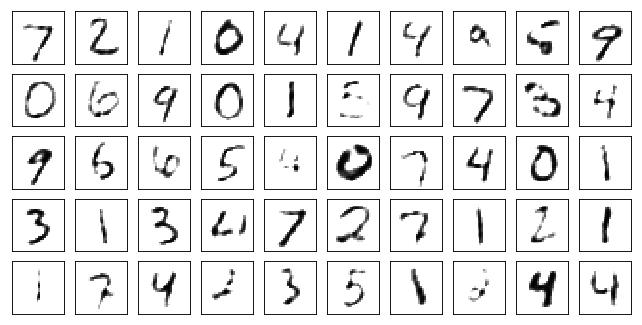

Test set:
64: loss: 0.0411	pho_loss: nan

Train Epoch: 12 [0/50000 (0%)]	Losses 64: 0.039552
Train Epoch: 12 [100/50000 (0%)]	Losses 64: 0.040142
Train Epoch: 12 [150/50000 (0%)]	Losses 64: 0.040849
Train Epoch: 12 [200/50000 (0%)]	Losses 64: 0.040565
Train Epoch: 12 [250/50000 (0%)]	Losses 64: 0.038633
Train Epoch: 12 [300/50000 (1%)]	Losses 64: 0.046218
Train Epoch: 12 [350/50000 (1%)]	Losses 64: 0.040455
Train Epoch: 12 [400/50000 (1%)]	Losses 64: 0.037385
Train Epoch: 12 [450/50000 (1%)]	Losses 64: 0.040409
Train Epoch: 12 [500/50000 (1%)]	Losses 64: 0.038558
Train Epoch: 12 [550/50000 (1%)]	Losses 64: 0.044477
Train Epoch: 12 [600/50000 (1%)]	Losses 64: 0.043067
Train Epoch: 12 [650/50000 (1%)]	Losses 64: 0.036364
Train Epoch: 12 [700/50000 (1%)]	Losses 64: 0.041507
Train Epoch: 12 [750/50000 (2%)]	Losses 64: 0.040540
Train Epoch: 12 [800/50000 (2%)]	Losses 64: 0.042686
Train Epoch: 12 [850/50000 (2%)]	Losses 64: 0.042512
Train Epoch: 12 [900/50000 (2%)]	Losses 64: 0.037739
Train 

Train Epoch: 12 [8600/50000 (17%)]	Losses 64: 0.041677
Train Epoch: 12 [8650/50000 (17%)]	Losses 64: 0.039773
Train Epoch: 12 [8700/50000 (17%)]	Losses 64: 0.036595
Train Epoch: 12 [8750/50000 (18%)]	Losses 64: 0.041131
Train Epoch: 12 [8800/50000 (18%)]	Losses 64: 0.042430
Train Epoch: 12 [8850/50000 (18%)]	Losses 64: 0.039912
Train Epoch: 12 [8900/50000 (18%)]	Losses 64: 0.041579
Train Epoch: 12 [8950/50000 (18%)]	Losses 64: 0.037370
Train Epoch: 12 [9000/50000 (18%)]	Losses 64: 0.038047
Train Epoch: 12 [9050/50000 (18%)]	Losses 64: 0.038306
Train Epoch: 12 [9100/50000 (18%)]	Losses 64: 0.040043
Train Epoch: 12 [9150/50000 (18%)]	Losses 64: 0.045913
Train Epoch: 12 [9200/50000 (18%)]	Losses 64: 0.043009
Train Epoch: 12 [9250/50000 (18%)]	Losses 64: 0.037667
Train Epoch: 12 [9300/50000 (19%)]	Losses 64: 0.037929
Train Epoch: 12 [9350/50000 (19%)]	Losses 64: 0.037139
Train Epoch: 12 [9400/50000 (19%)]	Losses 64: 0.042174
Train Epoch: 12 [9450/50000 (19%)]	Losses 64: 0.038039
Train Epoc

Train Epoch: 12 [16200/50000 (32%)]	Losses 64: 0.043940
Train Epoch: 12 [16250/50000 (32%)]	Losses 64: 0.039511
Train Epoch: 12 [16300/50000 (33%)]	Losses 64: 0.041020
Train Epoch: 12 [16350/50000 (33%)]	Losses 64: 0.044364
Train Epoch: 12 [16400/50000 (33%)]	Losses 64: 0.042750
Train Epoch: 12 [16450/50000 (33%)]	Losses 64: 0.039322
Train Epoch: 12 [16500/50000 (33%)]	Losses 64: 0.043537
Train Epoch: 12 [16550/50000 (33%)]	Losses 64: 0.040539
Train Epoch: 12 [16600/50000 (33%)]	Losses 64: 0.039906
Train Epoch: 12 [16650/50000 (33%)]	Losses 64: 0.033928
Train Epoch: 12 [16700/50000 (33%)]	Losses 64: 0.041225
Train Epoch: 12 [16750/50000 (34%)]	Losses 64: 0.040250
Train Epoch: 12 [16800/50000 (34%)]	Losses 64: 0.036995
Train Epoch: 12 [16850/50000 (34%)]	Losses 64: 0.042122
Train Epoch: 12 [16900/50000 (34%)]	Losses 64: 0.042922
Train Epoch: 12 [16950/50000 (34%)]	Losses 64: 0.038191
Train Epoch: 12 [17000/50000 (34%)]	Losses 64: 0.038057
Train Epoch: 12 [17050/50000 (34%)]	Losses 64: 0

Train Epoch: 12 [23800/50000 (48%)]	Losses 64: 0.039103
Train Epoch: 12 [23850/50000 (48%)]	Losses 64: 0.037686
Train Epoch: 12 [23900/50000 (48%)]	Losses 64: 0.039191
Train Epoch: 12 [23950/50000 (48%)]	Losses 64: 0.041113
Train Epoch: 12 [24000/50000 (48%)]	Losses 64: 0.037956
Train Epoch: 12 [24050/50000 (48%)]	Losses 64: 0.033644
Train Epoch: 12 [24100/50000 (48%)]	Losses 64: 0.041541
Train Epoch: 12 [24150/50000 (48%)]	Losses 64: 0.040166
Train Epoch: 12 [24200/50000 (48%)]	Losses 64: 0.038787
Train Epoch: 12 [24250/50000 (48%)]	Losses 64: 0.041049
Train Epoch: 12 [24300/50000 (49%)]	Losses 64: 0.042416
Train Epoch: 12 [24350/50000 (49%)]	Losses 64: 0.042368
Train Epoch: 12 [24400/50000 (49%)]	Losses 64: 0.043060
Train Epoch: 12 [24450/50000 (49%)]	Losses 64: 0.036415
Train Epoch: 12 [24500/50000 (49%)]	Losses 64: 0.043145
Train Epoch: 12 [24550/50000 (49%)]	Losses 64: 0.042055
Train Epoch: 12 [24600/50000 (49%)]	Losses 64: 0.039980
Train Epoch: 12 [24650/50000 (49%)]	Losses 64: 0

Train Epoch: 12 [31500/50000 (63%)]	Losses 64: 0.037291
Train Epoch: 12 [31550/50000 (63%)]	Losses 64: 0.039701
Train Epoch: 12 [31600/50000 (63%)]	Losses 64: 0.036089
Train Epoch: 12 [31650/50000 (63%)]	Losses 64: 0.040289
Train Epoch: 12 [31700/50000 (63%)]	Losses 64: 0.033955
Train Epoch: 12 [31750/50000 (64%)]	Losses 64: 0.040648
Train Epoch: 12 [31800/50000 (64%)]	Losses 64: 0.039727
Train Epoch: 12 [31850/50000 (64%)]	Losses 64: 0.039961
Train Epoch: 12 [31900/50000 (64%)]	Losses 64: 0.041540
Train Epoch: 12 [31950/50000 (64%)]	Losses 64: 0.039305
Train Epoch: 12 [32000/50000 (64%)]	Losses 64: 0.039226
Train Epoch: 12 [32050/50000 (64%)]	Losses 64: 0.045810
Train Epoch: 12 [32100/50000 (64%)]	Losses 64: 0.038185
Train Epoch: 12 [32150/50000 (64%)]	Losses 64: 0.036582
Train Epoch: 12 [32200/50000 (64%)]	Losses 64: 0.041118
Train Epoch: 12 [32250/50000 (64%)]	Losses 64: 0.037337
Train Epoch: 12 [32300/50000 (65%)]	Losses 64: 0.038814
Train Epoch: 12 [32350/50000 (65%)]	Losses 64: 0

Train Epoch: 12 [39800/50000 (80%)]	Losses 64: 0.035656
Train Epoch: 12 [39850/50000 (80%)]	Losses 64: 0.038391
Train Epoch: 12 [39900/50000 (80%)]	Losses 64: 0.039970
Train Epoch: 12 [39950/50000 (80%)]	Losses 64: 0.036034
Train Epoch: 12 [40000/50000 (80%)]	Losses 64: 0.041372
Train Epoch: 12 [40000/50000 (80%)]	Losses 64: 0.035990
Train Epoch: 12 [40100/50000 (80%)]	Losses 64: 0.040903
Train Epoch: 12 [40150/50000 (80%)]	Losses 64: 0.040065
Train Epoch: 12 [40200/50000 (80%)]	Losses 64: 0.034905
Train Epoch: 12 [40250/50000 (80%)]	Losses 64: 0.035232
Train Epoch: 12 [40300/50000 (81%)]	Losses 64: 0.038766
Train Epoch: 12 [40350/50000 (81%)]	Losses 64: 0.042023
Train Epoch: 12 [40400/50000 (81%)]	Losses 64: 0.037878
Train Epoch: 12 [40450/50000 (81%)]	Losses 64: 0.037024
Train Epoch: 12 [40500/50000 (81%)]	Losses 64: 0.037833
Train Epoch: 12 [40550/50000 (81%)]	Losses 64: 0.040693
Train Epoch: 12 [40600/50000 (81%)]	Losses 64: 0.039626
Train Epoch: 12 [40650/50000 (81%)]	Losses 64: 0

Train Epoch: 12 [47900/50000 (96%)]	Losses 64: 0.036522
Train Epoch: 12 [47950/50000 (96%)]	Losses 64: 0.040776
Train Epoch: 12 [48000/50000 (96%)]	Losses 64: 0.036407
Train Epoch: 12 [48050/50000 (96%)]	Losses 64: 0.039291
Train Epoch: 12 [48100/50000 (96%)]	Losses 64: 0.038914
Train Epoch: 12 [48150/50000 (96%)]	Losses 64: 0.041504
Train Epoch: 12 [48200/50000 (96%)]	Losses 64: 0.032452
Train Epoch: 12 [48250/50000 (96%)]	Losses 64: 0.037137
Train Epoch: 12 [48300/50000 (97%)]	Losses 64: 0.037833
Train Epoch: 12 [48350/50000 (97%)]	Losses 64: 0.037300
Train Epoch: 12 [48400/50000 (97%)]	Losses 64: 0.036730
Train Epoch: 12 [48450/50000 (97%)]	Losses 64: 0.039325
Train Epoch: 12 [48500/50000 (97%)]	Losses 64: 0.037563
Train Epoch: 12 [48550/50000 (97%)]	Losses 64: 0.041403
Train Epoch: 12 [48600/50000 (97%)]	Losses 64: 0.043875
Train Epoch: 12 [48650/50000 (97%)]	Losses 64: 0.036624
Train Epoch: 12 [48700/50000 (97%)]	Losses 64: 0.039527
Train Epoch: 12 [48750/50000 (98%)]	Losses 64: 0

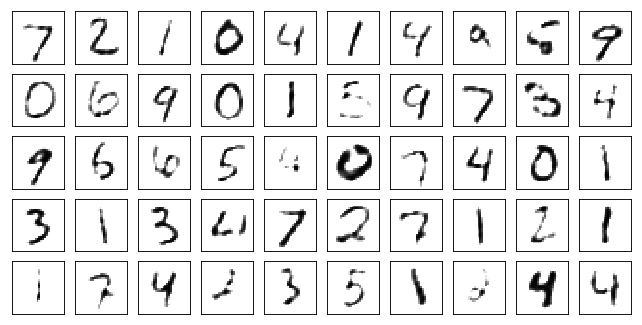

Test set:
64: loss: 0.0386	pho_loss: nan

Train Epoch: 13 [0/50000 (0%)]	Losses 64: 0.037199
Train Epoch: 13 [100/50000 (0%)]	Losses 64: 0.037700
Train Epoch: 13 [150/50000 (0%)]	Losses 64: 0.040837
Train Epoch: 13 [200/50000 (0%)]	Losses 64: 0.038899
Train Epoch: 13 [250/50000 (0%)]	Losses 64: 0.040621
Train Epoch: 13 [300/50000 (1%)]	Losses 64: 0.035126
Train Epoch: 13 [350/50000 (1%)]	Losses 64: 0.040589
Train Epoch: 13 [400/50000 (1%)]	Losses 64: 0.040422
Train Epoch: 13 [450/50000 (1%)]	Losses 64: 0.040035
Train Epoch: 13 [500/50000 (1%)]	Losses 64: 0.039292
Train Epoch: 13 [550/50000 (1%)]	Losses 64: 0.035170
Train Epoch: 13 [600/50000 (1%)]	Losses 64: 0.038245
Train Epoch: 13 [650/50000 (1%)]	Losses 64: 0.039303
Train Epoch: 13 [700/50000 (1%)]	Losses 64: 0.038044
Train Epoch: 13 [750/50000 (2%)]	Losses 64: 0.038897
Train Epoch: 13 [800/50000 (2%)]	Losses 64: 0.038020
Train Epoch: 13 [850/50000 (2%)]	Losses 64: 0.033164
Train Epoch: 13 [900/50000 (2%)]	Losses 64: 0.036328
Train 

Train Epoch: 13 [7900/50000 (16%)]	Losses 64: 0.033899
Train Epoch: 13 [7950/50000 (16%)]	Losses 64: 0.033587
Train Epoch: 13 [8000/50000 (16%)]	Losses 64: 0.036668
Train Epoch: 13 [8050/50000 (16%)]	Losses 64: 0.036840
Train Epoch: 13 [8100/50000 (16%)]	Losses 64: 0.044531
Train Epoch: 13 [8150/50000 (16%)]	Losses 64: 0.037664
Train Epoch: 13 [8200/50000 (16%)]	Losses 64: 0.036611
Train Epoch: 13 [8250/50000 (16%)]	Losses 64: 0.034580
Train Epoch: 13 [8300/50000 (17%)]	Losses 64: 0.038262
Train Epoch: 13 [8350/50000 (17%)]	Losses 64: 0.037480
Train Epoch: 13 [8400/50000 (17%)]	Losses 64: 0.034668
Train Epoch: 13 [8450/50000 (17%)]	Losses 64: 0.033738
Train Epoch: 13 [8500/50000 (17%)]	Losses 64: 0.038986
Train Epoch: 13 [8550/50000 (17%)]	Losses 64: 0.037204
Train Epoch: 13 [8600/50000 (17%)]	Losses 64: 0.039779
Train Epoch: 13 [8650/50000 (17%)]	Losses 64: 0.036958
Train Epoch: 13 [8700/50000 (17%)]	Losses 64: 0.040140
Train Epoch: 13 [8750/50000 (18%)]	Losses 64: 0.041508
Train Epoc

Train Epoch: 13 [15900/50000 (32%)]	Losses 64: 0.038185
Train Epoch: 13 [15950/50000 (32%)]	Losses 64: 0.037213
Train Epoch: 13 [16000/50000 (32%)]	Losses 64: 0.037703
Train Epoch: 13 [16050/50000 (32%)]	Losses 64: 0.041150
Train Epoch: 13 [16100/50000 (32%)]	Losses 64: 0.039312
Train Epoch: 13 [16150/50000 (32%)]	Losses 64: 0.040317
Train Epoch: 13 [16200/50000 (32%)]	Losses 64: 0.036061
Train Epoch: 13 [16250/50000 (32%)]	Losses 64: 0.043428
Train Epoch: 13 [16300/50000 (33%)]	Losses 64: 0.038765
Train Epoch: 13 [16350/50000 (33%)]	Losses 64: 0.039069
Train Epoch: 13 [16400/50000 (33%)]	Losses 64: 0.038935
Train Epoch: 13 [16450/50000 (33%)]	Losses 64: 0.037815
Train Epoch: 13 [16500/50000 (33%)]	Losses 64: 0.038977
Train Epoch: 13 [16550/50000 (33%)]	Losses 64: 0.032585
Train Epoch: 13 [16600/50000 (33%)]	Losses 64: 0.040402
Train Epoch: 13 [16650/50000 (33%)]	Losses 64: 0.036968
Train Epoch: 13 [16700/50000 (33%)]	Losses 64: 0.035455
Train Epoch: 13 [16750/50000 (34%)]	Losses 64: 0

Train Epoch: 13 [23500/50000 (47%)]	Losses 64: 0.035010
Train Epoch: 13 [23550/50000 (47%)]	Losses 64: 0.033709
Train Epoch: 13 [23600/50000 (47%)]	Losses 64: 0.039953
Train Epoch: 13 [23650/50000 (47%)]	Losses 64: 0.038210
Train Epoch: 13 [23700/50000 (47%)]	Losses 64: 0.034147
Train Epoch: 13 [23750/50000 (48%)]	Losses 64: 0.033958
Train Epoch: 13 [23800/50000 (48%)]	Losses 64: 0.039137
Train Epoch: 13 [23850/50000 (48%)]	Losses 64: 0.034556
Train Epoch: 13 [23900/50000 (48%)]	Losses 64: 0.036082
Train Epoch: 13 [23950/50000 (48%)]	Losses 64: 0.036780
Train Epoch: 13 [24000/50000 (48%)]	Losses 64: 0.036219
Train Epoch: 13 [24050/50000 (48%)]	Losses 64: 0.037678
Train Epoch: 13 [24100/50000 (48%)]	Losses 64: 0.038459
Train Epoch: 13 [24150/50000 (48%)]	Losses 64: 0.039084
Train Epoch: 13 [24200/50000 (48%)]	Losses 64: 0.038172
Train Epoch: 13 [24250/50000 (48%)]	Losses 64: 0.043065
Train Epoch: 13 [24300/50000 (49%)]	Losses 64: 0.039366
Train Epoch: 13 [24350/50000 (49%)]	Losses 64: 0

Train Epoch: 13 [31850/50000 (64%)]	Losses 64: 0.035196
Train Epoch: 13 [31900/50000 (64%)]	Losses 64: 0.035564
Train Epoch: 13 [31950/50000 (64%)]	Losses 64: 0.034742
Train Epoch: 13 [32000/50000 (64%)]	Losses 64: 0.038634
Train Epoch: 13 [32050/50000 (64%)]	Losses 64: 0.035755
Train Epoch: 13 [32100/50000 (64%)]	Losses 64: 0.036444
Train Epoch: 13 [32150/50000 (64%)]	Losses 64: 0.042148
Train Epoch: 13 [32200/50000 (64%)]	Losses 64: 0.033601
Train Epoch: 13 [32250/50000 (64%)]	Losses 64: 0.035783
Train Epoch: 13 [32300/50000 (65%)]	Losses 64: 0.032355
Train Epoch: 13 [32350/50000 (65%)]	Losses 64: 0.037552
Train Epoch: 13 [32400/50000 (65%)]	Losses 64: 0.041846
Train Epoch: 13 [32450/50000 (65%)]	Losses 64: 0.039305
Train Epoch: 13 [32500/50000 (65%)]	Losses 64: 0.037032
Train Epoch: 13 [32550/50000 (65%)]	Losses 64: 0.035943
Train Epoch: 13 [32600/50000 (65%)]	Losses 64: 0.031547
Train Epoch: 13 [32650/50000 (65%)]	Losses 64: 0.038705
Train Epoch: 13 [32700/50000 (65%)]	Losses 64: 0

Train Epoch: 13 [39300/50000 (79%)]	Losses 64: 0.033066
Train Epoch: 13 [39350/50000 (79%)]	Losses 64: 0.034364
Train Epoch: 13 [39400/50000 (79%)]	Losses 64: 0.029703
Train Epoch: 13 [39450/50000 (79%)]	Losses 64: 0.039577
Train Epoch: 13 [39500/50000 (79%)]	Losses 64: 0.034940
Train Epoch: 13 [39550/50000 (79%)]	Losses 64: 0.032322
Train Epoch: 13 [39600/50000 (79%)]	Losses 64: 0.038012
Train Epoch: 13 [39650/50000 (79%)]	Losses 64: 0.040502
Train Epoch: 13 [39700/50000 (79%)]	Losses 64: 0.034320
Train Epoch: 13 [39750/50000 (80%)]	Losses 64: 0.036199
Train Epoch: 13 [39800/50000 (80%)]	Losses 64: 0.038632
Train Epoch: 13 [39850/50000 (80%)]	Losses 64: 0.036664
Train Epoch: 13 [39900/50000 (80%)]	Losses 64: 0.035910
Train Epoch: 13 [39950/50000 (80%)]	Losses 64: 0.034309
Train Epoch: 13 [40000/50000 (80%)]	Losses 64: 0.035803
Train Epoch: 13 [40000/50000 (80%)]	Losses 64: 0.036332
Train Epoch: 13 [40100/50000 (80%)]	Losses 64: 0.034409
Train Epoch: 13 [40150/50000 (80%)]	Losses 64: 0

Train Epoch: 13 [47100/50000 (94%)]	Losses 64: 0.035016
Train Epoch: 13 [47150/50000 (94%)]	Losses 64: 0.037015
Train Epoch: 13 [47200/50000 (94%)]	Losses 64: 0.037910
Train Epoch: 13 [47250/50000 (94%)]	Losses 64: 0.038328
Train Epoch: 13 [47300/50000 (95%)]	Losses 64: 0.041424
Train Epoch: 13 [47350/50000 (95%)]	Losses 64: 0.034008
Train Epoch: 13 [47400/50000 (95%)]	Losses 64: 0.033709
Train Epoch: 13 [47450/50000 (95%)]	Losses 64: 0.030437
Train Epoch: 13 [47500/50000 (95%)]	Losses 64: 0.034110
Train Epoch: 13 [47550/50000 (95%)]	Losses 64: 0.040130
Train Epoch: 13 [47600/50000 (95%)]	Losses 64: 0.034160
Train Epoch: 13 [47650/50000 (95%)]	Losses 64: 0.033169
Train Epoch: 13 [47700/50000 (95%)]	Losses 64: 0.032644
Train Epoch: 13 [47750/50000 (96%)]	Losses 64: 0.030117
Train Epoch: 13 [47800/50000 (96%)]	Losses 64: 0.034827
Train Epoch: 13 [47850/50000 (96%)]	Losses 64: 0.039351
Train Epoch: 13 [47900/50000 (96%)]	Losses 64: 0.037296
Train Epoch: 13 [47950/50000 (96%)]	Losses 64: 0

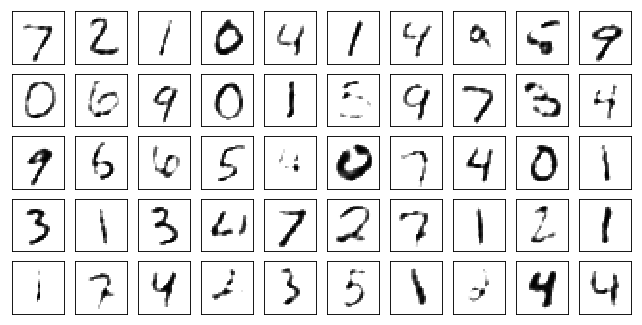

Test set:
64: loss: 0.0366	pho_loss: nan

Train Epoch: 14 [0/50000 (0%)]	Losses 64: 0.036680
Train Epoch: 14 [100/50000 (0%)]	Losses 64: 0.042445
Train Epoch: 14 [150/50000 (0%)]	Losses 64: 0.032668
Train Epoch: 14 [200/50000 (0%)]	Losses 64: 0.038444
Train Epoch: 14 [250/50000 (0%)]	Losses 64: 0.032177
Train Epoch: 14 [300/50000 (1%)]	Losses 64: 0.040357
Train Epoch: 14 [350/50000 (1%)]	Losses 64: 0.039331
Train Epoch: 14 [400/50000 (1%)]	Losses 64: 0.035954
Train Epoch: 14 [450/50000 (1%)]	Losses 64: 0.042195
Train Epoch: 14 [500/50000 (1%)]	Losses 64: 0.032107
Train Epoch: 14 [550/50000 (1%)]	Losses 64: 0.035286
Train Epoch: 14 [600/50000 (1%)]	Losses 64: 0.033422
Train Epoch: 14 [650/50000 (1%)]	Losses 64: 0.036582
Train Epoch: 14 [700/50000 (1%)]	Losses 64: 0.036304
Train Epoch: 14 [750/50000 (2%)]	Losses 64: 0.029419
Train Epoch: 14 [800/50000 (2%)]	Losses 64: 0.036574
Train Epoch: 14 [850/50000 (2%)]	Losses 64: 0.033768
Train Epoch: 14 [900/50000 (2%)]	Losses 64: 0.038948
Train 

Train Epoch: 14 [7950/50000 (16%)]	Losses 64: 0.033771
Train Epoch: 14 [8000/50000 (16%)]	Losses 64: 0.035310
Train Epoch: 14 [8050/50000 (16%)]	Losses 64: 0.038972
Train Epoch: 14 [8100/50000 (16%)]	Losses 64: 0.034282
Train Epoch: 14 [8150/50000 (16%)]	Losses 64: 0.034000
Train Epoch: 14 [8200/50000 (16%)]	Losses 64: 0.035508
Train Epoch: 14 [8250/50000 (16%)]	Losses 64: 0.033531
Train Epoch: 14 [8300/50000 (17%)]	Losses 64: 0.035922
Train Epoch: 14 [8350/50000 (17%)]	Losses 64: 0.032861
Train Epoch: 14 [8400/50000 (17%)]	Losses 64: 0.035462
Train Epoch: 14 [8450/50000 (17%)]	Losses 64: 0.033943
Train Epoch: 14 [8500/50000 (17%)]	Losses 64: 0.040160
Train Epoch: 14 [8550/50000 (17%)]	Losses 64: 0.037895
Train Epoch: 14 [8600/50000 (17%)]	Losses 64: 0.035227
Train Epoch: 14 [8650/50000 (17%)]	Losses 64: 0.039134
Train Epoch: 14 [8700/50000 (17%)]	Losses 64: 0.035495
Train Epoch: 14 [8750/50000 (18%)]	Losses 64: 0.038798
Train Epoch: 14 [8800/50000 (18%)]	Losses 64: 0.037216
Train Epoc

Train Epoch: 14 [15600/50000 (31%)]	Losses 64: 0.034765
Train Epoch: 14 [15650/50000 (31%)]	Losses 64: 0.031095
Train Epoch: 14 [15700/50000 (31%)]	Losses 64: 0.033861
Train Epoch: 14 [15750/50000 (32%)]	Losses 64: 0.034560
Train Epoch: 14 [15800/50000 (32%)]	Losses 64: 0.034071
Train Epoch: 14 [15850/50000 (32%)]	Losses 64: 0.031777
Train Epoch: 14 [15900/50000 (32%)]	Losses 64: 0.029631
Train Epoch: 14 [15950/50000 (32%)]	Losses 64: 0.031331
Train Epoch: 14 [16000/50000 (32%)]	Losses 64: 0.037214
Train Epoch: 14 [16050/50000 (32%)]	Losses 64: 0.034334
Train Epoch: 14 [16100/50000 (32%)]	Losses 64: 0.035970
Train Epoch: 14 [16150/50000 (32%)]	Losses 64: 0.035695
Train Epoch: 14 [16200/50000 (32%)]	Losses 64: 0.039910
Train Epoch: 14 [16250/50000 (32%)]	Losses 64: 0.036048
Train Epoch: 14 [16300/50000 (33%)]	Losses 64: 0.036725
Train Epoch: 14 [16350/50000 (33%)]	Losses 64: 0.037689
Train Epoch: 14 [16400/50000 (33%)]	Losses 64: 0.038815
Train Epoch: 14 [16450/50000 (33%)]	Losses 64: 0

Train Epoch: 14 [23650/50000 (47%)]	Losses 64: 0.033124
Train Epoch: 14 [23700/50000 (47%)]	Losses 64: 0.030945
Train Epoch: 14 [23750/50000 (48%)]	Losses 64: 0.038702
Train Epoch: 14 [23800/50000 (48%)]	Losses 64: 0.033776
Train Epoch: 14 [23850/50000 (48%)]	Losses 64: 0.037082
Train Epoch: 14 [23900/50000 (48%)]	Losses 64: 0.038080
Train Epoch: 14 [23950/50000 (48%)]	Losses 64: 0.036808
Train Epoch: 14 [24000/50000 (48%)]	Losses 64: 0.040669
Train Epoch: 14 [24050/50000 (48%)]	Losses 64: 0.031780
Train Epoch: 14 [24100/50000 (48%)]	Losses 64: 0.031615
Train Epoch: 14 [24150/50000 (48%)]	Losses 64: 0.035433
Train Epoch: 14 [24200/50000 (48%)]	Losses 64: 0.036612
Train Epoch: 14 [24250/50000 (48%)]	Losses 64: 0.035868
Train Epoch: 14 [24300/50000 (49%)]	Losses 64: 0.035173
Train Epoch: 14 [24350/50000 (49%)]	Losses 64: 0.034301
Train Epoch: 14 [24400/50000 (49%)]	Losses 64: 0.037209
Train Epoch: 14 [24450/50000 (49%)]	Losses 64: 0.031208
Train Epoch: 14 [24500/50000 (49%)]	Losses 64: 0

Train Epoch: 14 [31600/50000 (63%)]	Losses 64: 0.036341
Train Epoch: 14 [31650/50000 (63%)]	Losses 64: 0.036616
Train Epoch: 14 [31700/50000 (63%)]	Losses 64: 0.034536
Train Epoch: 14 [31750/50000 (64%)]	Losses 64: 0.038302
Train Epoch: 14 [31800/50000 (64%)]	Losses 64: 0.035737
Train Epoch: 14 [31850/50000 (64%)]	Losses 64: 0.033967
Train Epoch: 14 [31900/50000 (64%)]	Losses 64: 0.038172
Train Epoch: 14 [31950/50000 (64%)]	Losses 64: 0.033876
Train Epoch: 14 [32000/50000 (64%)]	Losses 64: 0.030266
Train Epoch: 14 [32050/50000 (64%)]	Losses 64: 0.031629
Train Epoch: 14 [32100/50000 (64%)]	Losses 64: 0.035577
Train Epoch: 14 [32150/50000 (64%)]	Losses 64: 0.035538
Train Epoch: 14 [32200/50000 (64%)]	Losses 64: 0.034356
Train Epoch: 14 [32250/50000 (64%)]	Losses 64: 0.035932
Train Epoch: 14 [32300/50000 (65%)]	Losses 64: 0.036118
Train Epoch: 14 [32350/50000 (65%)]	Losses 64: 0.035796
Train Epoch: 14 [32400/50000 (65%)]	Losses 64: 0.033741
Train Epoch: 14 [32450/50000 (65%)]	Losses 64: 0

Train Epoch: 14 [39900/50000 (80%)]	Losses 64: 0.035749
Train Epoch: 14 [39950/50000 (80%)]	Losses 64: 0.032281
Train Epoch: 14 [40000/50000 (80%)]	Losses 64: 0.031942
Train Epoch: 14 [40000/50000 (80%)]	Losses 64: 0.034637
Train Epoch: 14 [40100/50000 (80%)]	Losses 64: 0.036437
Train Epoch: 14 [40150/50000 (80%)]	Losses 64: 0.034876
Train Epoch: 14 [40200/50000 (80%)]	Losses 64: 0.035341
Train Epoch: 14 [40250/50000 (80%)]	Losses 64: 0.034079
Train Epoch: 14 [40300/50000 (81%)]	Losses 64: 0.032674
Train Epoch: 14 [40350/50000 (81%)]	Losses 64: 0.035608
Train Epoch: 14 [40400/50000 (81%)]	Losses 64: 0.031211
Train Epoch: 14 [40450/50000 (81%)]	Losses 64: 0.035885
Train Epoch: 14 [40500/50000 (81%)]	Losses 64: 0.034800
Train Epoch: 14 [40550/50000 (81%)]	Losses 64: 0.030574
Train Epoch: 14 [40600/50000 (81%)]	Losses 64: 0.041695
Train Epoch: 14 [40650/50000 (81%)]	Losses 64: 0.032335
Train Epoch: 14 [40700/50000 (81%)]	Losses 64: 0.035800
Train Epoch: 14 [40750/50000 (82%)]	Losses 64: 0

Train Epoch: 14 [48050/50000 (96%)]	Losses 64: 0.038385
Train Epoch: 14 [48100/50000 (96%)]	Losses 64: 0.035753
Train Epoch: 14 [48150/50000 (96%)]	Losses 64: 0.035156
Train Epoch: 14 [48200/50000 (96%)]	Losses 64: 0.035766
Train Epoch: 14 [48250/50000 (96%)]	Losses 64: 0.032332
Train Epoch: 14 [48300/50000 (97%)]	Losses 64: 0.037369
Train Epoch: 14 [48350/50000 (97%)]	Losses 64: 0.036960
Train Epoch: 14 [48400/50000 (97%)]	Losses 64: 0.030717
Train Epoch: 14 [48450/50000 (97%)]	Losses 64: 0.033964
Train Epoch: 14 [48500/50000 (97%)]	Losses 64: 0.035948
Train Epoch: 14 [48550/50000 (97%)]	Losses 64: 0.031078
Train Epoch: 14 [48600/50000 (97%)]	Losses 64: 0.038757
Train Epoch: 14 [48650/50000 (97%)]	Losses 64: 0.033371
Train Epoch: 14 [48700/50000 (97%)]	Losses 64: 0.032686
Train Epoch: 14 [48750/50000 (98%)]	Losses 64: 0.035856
Train Epoch: 14 [48800/50000 (98%)]	Losses 64: 0.036337
Train Epoch: 14 [48850/50000 (98%)]	Losses 64: 0.034529
Train Epoch: 14 [48900/50000 (98%)]	Losses 64: 0

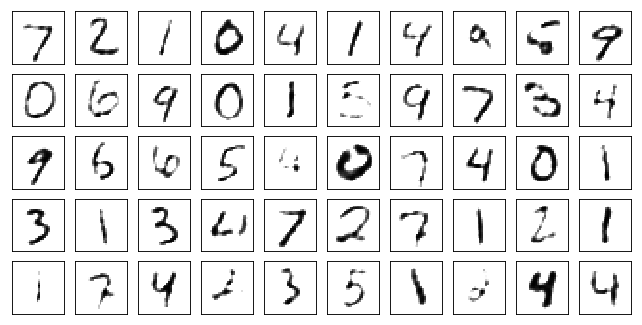

Test set:
64: loss: 0.0349	pho_loss: nan

Train Epoch: 15 [0/50000 (0%)]	Losses 64: 0.034520
Train Epoch: 15 [100/50000 (0%)]	Losses 64: 0.037413
Train Epoch: 15 [150/50000 (0%)]	Losses 64: 0.029995
Train Epoch: 15 [200/50000 (0%)]	Losses 64: 0.037243
Train Epoch: 15 [250/50000 (0%)]	Losses 64: 0.034488
Train Epoch: 15 [300/50000 (1%)]	Losses 64: 0.035725
Train Epoch: 15 [350/50000 (1%)]	Losses 64: 0.034920
Train Epoch: 15 [400/50000 (1%)]	Losses 64: 0.033997
Train Epoch: 15 [450/50000 (1%)]	Losses 64: 0.033414
Train Epoch: 15 [500/50000 (1%)]	Losses 64: 0.039500
Train Epoch: 15 [550/50000 (1%)]	Losses 64: 0.037494
Train Epoch: 15 [600/50000 (1%)]	Losses 64: 0.035233
Train Epoch: 15 [650/50000 (1%)]	Losses 64: 0.033769
Train Epoch: 15 [700/50000 (1%)]	Losses 64: 0.036619
Train Epoch: 15 [750/50000 (2%)]	Losses 64: 0.033611
Train Epoch: 15 [800/50000 (2%)]	Losses 64: 0.035266
Train Epoch: 15 [850/50000 (2%)]	Losses 64: 0.035114
Train Epoch: 15 [900/50000 (2%)]	Losses 64: 0.035353
Train 

Train Epoch: 15 [7700/50000 (15%)]	Losses 64: 0.033804
Train Epoch: 15 [7750/50000 (16%)]	Losses 64: 0.032142
Train Epoch: 15 [7800/50000 (16%)]	Losses 64: 0.029719
Train Epoch: 15 [7850/50000 (16%)]	Losses 64: 0.031899
Train Epoch: 15 [7900/50000 (16%)]	Losses 64: 0.031295
Train Epoch: 15 [7950/50000 (16%)]	Losses 64: 0.034777
Train Epoch: 15 [8000/50000 (16%)]	Losses 64: 0.031913
Train Epoch: 15 [8050/50000 (16%)]	Losses 64: 0.030671
Train Epoch: 15 [8100/50000 (16%)]	Losses 64: 0.031741
Train Epoch: 15 [8150/50000 (16%)]	Losses 64: 0.028516
Train Epoch: 15 [8200/50000 (16%)]	Losses 64: 0.031475
Train Epoch: 15 [8250/50000 (16%)]	Losses 64: 0.034609
Train Epoch: 15 [8300/50000 (17%)]	Losses 64: 0.035070
Train Epoch: 15 [8350/50000 (17%)]	Losses 64: 0.033569
Train Epoch: 15 [8400/50000 (17%)]	Losses 64: 0.032447
Train Epoch: 15 [8450/50000 (17%)]	Losses 64: 0.035306
Train Epoch: 15 [8500/50000 (17%)]	Losses 64: 0.039182
Train Epoch: 15 [8550/50000 (17%)]	Losses 64: 0.034675
Train Epoc

Train Epoch: 15 [15350/50000 (31%)]	Losses 64: 0.034598
Train Epoch: 15 [15400/50000 (31%)]	Losses 64: 0.031316
Train Epoch: 15 [15450/50000 (31%)]	Losses 64: 0.034803
Train Epoch: 15 [15500/50000 (31%)]	Losses 64: 0.033172
Train Epoch: 15 [15550/50000 (31%)]	Losses 64: 0.032685
Train Epoch: 15 [15600/50000 (31%)]	Losses 64: 0.035955
Train Epoch: 15 [15650/50000 (31%)]	Losses 64: 0.035415
Train Epoch: 15 [15700/50000 (31%)]	Losses 64: 0.036648
Train Epoch: 15 [15750/50000 (32%)]	Losses 64: 0.036000
Train Epoch: 15 [15800/50000 (32%)]	Losses 64: 0.037191
Train Epoch: 15 [15850/50000 (32%)]	Losses 64: 0.033644
Train Epoch: 15 [15900/50000 (32%)]	Losses 64: 0.031019
Train Epoch: 15 [15950/50000 (32%)]	Losses 64: 0.033197
Train Epoch: 15 [16000/50000 (32%)]	Losses 64: 0.033180
Train Epoch: 15 [16050/50000 (32%)]	Losses 64: 0.031361
Train Epoch: 15 [16100/50000 (32%)]	Losses 64: 0.036490
Train Epoch: 15 [16150/50000 (32%)]	Losses 64: 0.036545
Train Epoch: 15 [16200/50000 (32%)]	Losses 64: 0

Train Epoch: 15 [23050/50000 (46%)]	Losses 64: 0.030858
Train Epoch: 15 [23100/50000 (46%)]	Losses 64: 0.036459
Train Epoch: 15 [23150/50000 (46%)]	Losses 64: 0.032701
Train Epoch: 15 [23200/50000 (46%)]	Losses 64: 0.033405
Train Epoch: 15 [23250/50000 (46%)]	Losses 64: 0.028762
Train Epoch: 15 [23300/50000 (47%)]	Losses 64: 0.031142
Train Epoch: 15 [23350/50000 (47%)]	Losses 64: 0.034007
Train Epoch: 15 [23400/50000 (47%)]	Losses 64: 0.035572
Train Epoch: 15 [23450/50000 (47%)]	Losses 64: 0.037803
Train Epoch: 15 [23500/50000 (47%)]	Losses 64: 0.036444
Train Epoch: 15 [23550/50000 (47%)]	Losses 64: 0.033675
Train Epoch: 15 [23600/50000 (47%)]	Losses 64: 0.037590
Train Epoch: 15 [23650/50000 (47%)]	Losses 64: 0.035719
Train Epoch: 15 [23700/50000 (47%)]	Losses 64: 0.035089
Train Epoch: 15 [23750/50000 (48%)]	Losses 64: 0.033541
Train Epoch: 15 [23800/50000 (48%)]	Losses 64: 0.034280
Train Epoch: 15 [23850/50000 (48%)]	Losses 64: 0.034818
Train Epoch: 15 [23900/50000 (48%)]	Losses 64: 0

Train Epoch: 15 [30550/50000 (61%)]	Losses 64: 0.033406
Train Epoch: 15 [30600/50000 (61%)]	Losses 64: 0.031066
Train Epoch: 15 [30650/50000 (61%)]	Losses 64: 0.032922
Train Epoch: 15 [30700/50000 (61%)]	Losses 64: 0.030695
Train Epoch: 15 [30750/50000 (62%)]	Losses 64: 0.032869
Train Epoch: 15 [30800/50000 (62%)]	Losses 64: 0.037066
Train Epoch: 15 [30850/50000 (62%)]	Losses 64: 0.030720
Train Epoch: 15 [30900/50000 (62%)]	Losses 64: 0.033683
Train Epoch: 15 [30950/50000 (62%)]	Losses 64: 0.029058
Train Epoch: 15 [31000/50000 (62%)]	Losses 64: 0.036476
Train Epoch: 15 [31050/50000 (62%)]	Losses 64: 0.032448
Train Epoch: 15 [31100/50000 (62%)]	Losses 64: 0.031107
Train Epoch: 15 [31150/50000 (62%)]	Losses 64: 0.030709
Train Epoch: 15 [31200/50000 (62%)]	Losses 64: 0.039324
Train Epoch: 15 [31250/50000 (62%)]	Losses 64: 0.032583
Train Epoch: 15 [31300/50000 (63%)]	Losses 64: 0.031155
Train Epoch: 15 [31350/50000 (63%)]	Losses 64: 0.033139
Train Epoch: 15 [31400/50000 (63%)]	Losses 64: 0

Train Epoch: 15 [38850/50000 (78%)]	Losses 64: 0.033656
Train Epoch: 15 [38900/50000 (78%)]	Losses 64: 0.032117
Train Epoch: 15 [38950/50000 (78%)]	Losses 64: 0.037213
Train Epoch: 15 [39000/50000 (78%)]	Losses 64: 0.030635
Train Epoch: 15 [39050/50000 (78%)]	Losses 64: 0.034482
Train Epoch: 15 [39100/50000 (78%)]	Losses 64: 0.034394
Train Epoch: 15 [39150/50000 (78%)]	Losses 64: 0.029229
Train Epoch: 15 [39200/50000 (78%)]	Losses 64: 0.035247
Train Epoch: 15 [39250/50000 (78%)]	Losses 64: 0.032655
Train Epoch: 15 [39300/50000 (79%)]	Losses 64: 0.033607
Train Epoch: 15 [39350/50000 (79%)]	Losses 64: 0.031516
Train Epoch: 15 [39400/50000 (79%)]	Losses 64: 0.034566
Train Epoch: 15 [39450/50000 (79%)]	Losses 64: 0.033742
Train Epoch: 15 [39500/50000 (79%)]	Losses 64: 0.031957
Train Epoch: 15 [39550/50000 (79%)]	Losses 64: 0.037022
Train Epoch: 15 [39600/50000 (79%)]	Losses 64: 0.031552
Train Epoch: 15 [39650/50000 (79%)]	Losses 64: 0.035950
Train Epoch: 15 [39700/50000 (79%)]	Losses 64: 0

Train Epoch: 15 [47100/50000 (94%)]	Losses 64: 0.030021
Train Epoch: 15 [47150/50000 (94%)]	Losses 64: 0.030302
Train Epoch: 15 [47200/50000 (94%)]	Losses 64: 0.032388
Train Epoch: 15 [47250/50000 (94%)]	Losses 64: 0.031124
Train Epoch: 15 [47300/50000 (95%)]	Losses 64: 0.030212
Train Epoch: 15 [47350/50000 (95%)]	Losses 64: 0.033327
Train Epoch: 15 [47400/50000 (95%)]	Losses 64: 0.032444
Train Epoch: 15 [47450/50000 (95%)]	Losses 64: 0.036417
Train Epoch: 15 [47500/50000 (95%)]	Losses 64: 0.036073
Train Epoch: 15 [47550/50000 (95%)]	Losses 64: 0.033935
Train Epoch: 15 [47600/50000 (95%)]	Losses 64: 0.039285
Train Epoch: 15 [47650/50000 (95%)]	Losses 64: 0.031410
Train Epoch: 15 [47700/50000 (95%)]	Losses 64: 0.029917
Train Epoch: 15 [47750/50000 (96%)]	Losses 64: 0.032579
Train Epoch: 15 [47800/50000 (96%)]	Losses 64: 0.030497
Train Epoch: 15 [47850/50000 (96%)]	Losses 64: 0.031852
Train Epoch: 15 [47900/50000 (96%)]	Losses 64: 0.034221
Train Epoch: 15 [47950/50000 (96%)]	Losses 64: 0

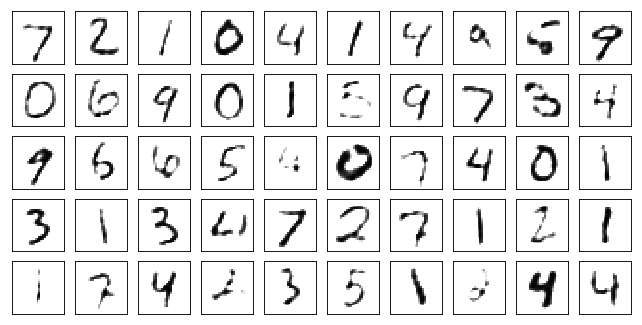

Test set:
64: loss: 0.0333	pho_loss: nan

Train Epoch: 16 [0/50000 (0%)]	Losses 64: 0.032650
Train Epoch: 16 [100/50000 (0%)]	Losses 64: 0.035305
Train Epoch: 16 [150/50000 (0%)]	Losses 64: 0.030886
Train Epoch: 16 [200/50000 (0%)]	Losses 64: 0.030341
Train Epoch: 16 [250/50000 (0%)]	Losses 64: 0.029394
Train Epoch: 16 [300/50000 (1%)]	Losses 64: 0.034311
Train Epoch: 16 [350/50000 (1%)]	Losses 64: 0.030814
Train Epoch: 16 [400/50000 (1%)]	Losses 64: 0.035290
Train Epoch: 16 [450/50000 (1%)]	Losses 64: 0.032621
Train Epoch: 16 [500/50000 (1%)]	Losses 64: 0.030840
Train Epoch: 16 [550/50000 (1%)]	Losses 64: 0.033137
Train Epoch: 16 [600/50000 (1%)]	Losses 64: 0.036033
Train Epoch: 16 [650/50000 (1%)]	Losses 64: 0.033123
Train Epoch: 16 [700/50000 (1%)]	Losses 64: 0.031452
Train Epoch: 16 [750/50000 (2%)]	Losses 64: 0.030331
Train Epoch: 16 [800/50000 (2%)]	Losses 64: 0.031120
Train Epoch: 16 [850/50000 (2%)]	Losses 64: 0.035075
Train Epoch: 16 [900/50000 (2%)]	Losses 64: 0.028947
Train 

Train Epoch: 16 [7750/50000 (16%)]	Losses 64: 0.033078
Train Epoch: 16 [7800/50000 (16%)]	Losses 64: 0.029963
Train Epoch: 16 [7850/50000 (16%)]	Losses 64: 0.032939
Train Epoch: 16 [7900/50000 (16%)]	Losses 64: 0.032424
Train Epoch: 16 [7950/50000 (16%)]	Losses 64: 0.036175
Train Epoch: 16 [8000/50000 (16%)]	Losses 64: 0.033318
Train Epoch: 16 [8050/50000 (16%)]	Losses 64: 0.029157
Train Epoch: 16 [8100/50000 (16%)]	Losses 64: 0.031954
Train Epoch: 16 [8150/50000 (16%)]	Losses 64: 0.032501
Train Epoch: 16 [8200/50000 (16%)]	Losses 64: 0.033910
Train Epoch: 16 [8250/50000 (16%)]	Losses 64: 0.031529
Train Epoch: 16 [8300/50000 (17%)]	Losses 64: 0.033905
Train Epoch: 16 [8350/50000 (17%)]	Losses 64: 0.032322
Train Epoch: 16 [8400/50000 (17%)]	Losses 64: 0.030955
Train Epoch: 16 [8450/50000 (17%)]	Losses 64: 0.026878
Train Epoch: 16 [8500/50000 (17%)]	Losses 64: 0.032091
Train Epoch: 16 [8550/50000 (17%)]	Losses 64: 0.033407
Train Epoch: 16 [8600/50000 (17%)]	Losses 64: 0.036121
Train Epoc

Train Epoch: 16 [15400/50000 (31%)]	Losses 64: 0.036285
Train Epoch: 16 [15450/50000 (31%)]	Losses 64: 0.033338
Train Epoch: 16 [15500/50000 (31%)]	Losses 64: 0.029854
Train Epoch: 16 [15550/50000 (31%)]	Losses 64: 0.032126
Train Epoch: 16 [15600/50000 (31%)]	Losses 64: 0.028192
Train Epoch: 16 [15650/50000 (31%)]	Losses 64: 0.030814
Train Epoch: 16 [15700/50000 (31%)]	Losses 64: 0.034950
Train Epoch: 16 [15750/50000 (32%)]	Losses 64: 0.034480
Train Epoch: 16 [15800/50000 (32%)]	Losses 64: 0.033892
Train Epoch: 16 [15850/50000 (32%)]	Losses 64: 0.029910
Train Epoch: 16 [15900/50000 (32%)]	Losses 64: 0.029835
Train Epoch: 16 [15950/50000 (32%)]	Losses 64: 0.032187
Train Epoch: 16 [16000/50000 (32%)]	Losses 64: 0.032714
Train Epoch: 16 [16050/50000 (32%)]	Losses 64: 0.033311
Train Epoch: 16 [16100/50000 (32%)]	Losses 64: 0.032734
Train Epoch: 16 [16150/50000 (32%)]	Losses 64: 0.028714
Train Epoch: 16 [16200/50000 (32%)]	Losses 64: 0.035652
Train Epoch: 16 [16250/50000 (32%)]	Losses 64: 0

Train Epoch: 16 [23050/50000 (46%)]	Losses 64: 0.030424
Train Epoch: 16 [23100/50000 (46%)]	Losses 64: 0.037774
Train Epoch: 16 [23150/50000 (46%)]	Losses 64: 0.036632
Train Epoch: 16 [23200/50000 (46%)]	Losses 64: 0.037041
Train Epoch: 16 [23250/50000 (46%)]	Losses 64: 0.030285
Train Epoch: 16 [23300/50000 (47%)]	Losses 64: 0.029657
Train Epoch: 16 [23350/50000 (47%)]	Losses 64: 0.031041
Train Epoch: 16 [23400/50000 (47%)]	Losses 64: 0.033593
Train Epoch: 16 [23450/50000 (47%)]	Losses 64: 0.033467
Train Epoch: 16 [23500/50000 (47%)]	Losses 64: 0.030912
Train Epoch: 16 [23550/50000 (47%)]	Losses 64: 0.031228
Train Epoch: 16 [23600/50000 (47%)]	Losses 64: 0.033030
Train Epoch: 16 [23650/50000 (47%)]	Losses 64: 0.036328
Train Epoch: 16 [23700/50000 (47%)]	Losses 64: 0.033315
Train Epoch: 16 [23750/50000 (48%)]	Losses 64: 0.032052
Train Epoch: 16 [23800/50000 (48%)]	Losses 64: 0.032159
Train Epoch: 16 [23850/50000 (48%)]	Losses 64: 0.029980
Train Epoch: 16 [23900/50000 (48%)]	Losses 64: 0

Train Epoch: 16 [30450/50000 (61%)]	Losses 64: 0.034661
Train Epoch: 16 [30500/50000 (61%)]	Losses 64: 0.032202
Train Epoch: 16 [30550/50000 (61%)]	Losses 64: 0.030496
Train Epoch: 16 [30600/50000 (61%)]	Losses 64: 0.034946
Train Epoch: 16 [30650/50000 (61%)]	Losses 64: 0.030993
Train Epoch: 16 [30700/50000 (61%)]	Losses 64: 0.031770
Train Epoch: 16 [30750/50000 (62%)]	Losses 64: 0.033095
Train Epoch: 16 [30800/50000 (62%)]	Losses 64: 0.031660
Train Epoch: 16 [30850/50000 (62%)]	Losses 64: 0.029293
Train Epoch: 16 [30900/50000 (62%)]	Losses 64: 0.032059
Train Epoch: 16 [30950/50000 (62%)]	Losses 64: 0.035910
Train Epoch: 16 [31000/50000 (62%)]	Losses 64: 0.032387
Train Epoch: 16 [31050/50000 (62%)]	Losses 64: 0.032053
Train Epoch: 16 [31100/50000 (62%)]	Losses 64: 0.029508
Train Epoch: 16 [31150/50000 (62%)]	Losses 64: 0.032443
Train Epoch: 16 [31200/50000 (62%)]	Losses 64: 0.031348
Train Epoch: 16 [31250/50000 (62%)]	Losses 64: 0.033505
Train Epoch: 16 [31300/50000 (63%)]	Losses 64: 0

Train Epoch: 16 [38800/50000 (78%)]	Losses 64: 0.031277
Train Epoch: 16 [38850/50000 (78%)]	Losses 64: 0.029487
Train Epoch: 16 [38900/50000 (78%)]	Losses 64: 0.032830
Train Epoch: 16 [38950/50000 (78%)]	Losses 64: 0.031010
Train Epoch: 16 [39000/50000 (78%)]	Losses 64: 0.032701
Train Epoch: 16 [39050/50000 (78%)]	Losses 64: 0.032814
Train Epoch: 16 [39100/50000 (78%)]	Losses 64: 0.031656
Train Epoch: 16 [39150/50000 (78%)]	Losses 64: 0.029383
Train Epoch: 16 [39200/50000 (78%)]	Losses 64: 0.031287
Train Epoch: 16 [39250/50000 (78%)]	Losses 64: 0.033353
Train Epoch: 16 [39300/50000 (79%)]	Losses 64: 0.026515
Train Epoch: 16 [39350/50000 (79%)]	Losses 64: 0.030532
Train Epoch: 16 [39400/50000 (79%)]	Losses 64: 0.031025
Train Epoch: 16 [39450/50000 (79%)]	Losses 64: 0.028747
Train Epoch: 16 [39500/50000 (79%)]	Losses 64: 0.030225
Train Epoch: 16 [39550/50000 (79%)]	Losses 64: 0.034209
Train Epoch: 16 [39600/50000 (79%)]	Losses 64: 0.029350
Train Epoch: 16 [39650/50000 (79%)]	Losses 64: 0

Train Epoch: 16 [47100/50000 (94%)]	Losses 64: 0.033775
Train Epoch: 16 [47150/50000 (94%)]	Losses 64: 0.031511
Train Epoch: 16 [47200/50000 (94%)]	Losses 64: 0.033182
Train Epoch: 16 [47250/50000 (94%)]	Losses 64: 0.033008
Train Epoch: 16 [47300/50000 (95%)]	Losses 64: 0.030322
Train Epoch: 16 [47350/50000 (95%)]	Losses 64: 0.033425
Train Epoch: 16 [47400/50000 (95%)]	Losses 64: 0.033185
Train Epoch: 16 [47450/50000 (95%)]	Losses 64: 0.032333
Train Epoch: 16 [47500/50000 (95%)]	Losses 64: 0.034830
Train Epoch: 16 [47550/50000 (95%)]	Losses 64: 0.033760
Train Epoch: 16 [47600/50000 (95%)]	Losses 64: 0.032168
Train Epoch: 16 [47650/50000 (95%)]	Losses 64: 0.030155
Train Epoch: 16 [47700/50000 (95%)]	Losses 64: 0.030850
Train Epoch: 16 [47750/50000 (96%)]	Losses 64: 0.034294
Train Epoch: 16 [47800/50000 (96%)]	Losses 64: 0.037094
Train Epoch: 16 [47850/50000 (96%)]	Losses 64: 0.030171
Train Epoch: 16 [47900/50000 (96%)]	Losses 64: 0.026484
Train Epoch: 16 [47950/50000 (96%)]	Losses 64: 0

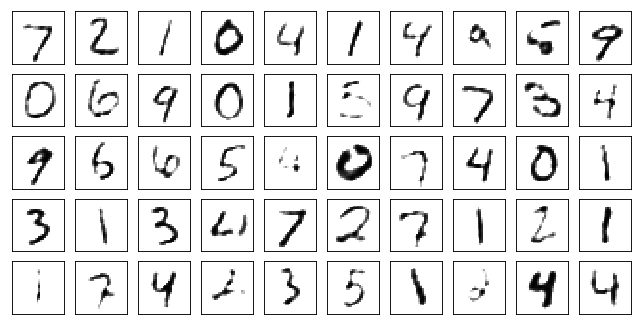

Test set:
64: loss: 0.0321	pho_loss: nan

Train Epoch: 17 [0/50000 (0%)]	Losses 64: 0.033564
Train Epoch: 17 [100/50000 (0%)]	Losses 64: 0.034480
Train Epoch: 17 [150/50000 (0%)]	Losses 64: 0.030549
Train Epoch: 17 [200/50000 (0%)]	Losses 64: 0.029842
Train Epoch: 17 [250/50000 (0%)]	Losses 64: 0.029450
Train Epoch: 17 [300/50000 (1%)]	Losses 64: 0.030190
Train Epoch: 17 [350/50000 (1%)]	Losses 64: 0.031976
Train Epoch: 17 [400/50000 (1%)]	Losses 64: 0.031467
Train Epoch: 17 [450/50000 (1%)]	Losses 64: 0.034782
Train Epoch: 17 [500/50000 (1%)]	Losses 64: 0.028019
Train Epoch: 17 [550/50000 (1%)]	Losses 64: 0.031509
Train Epoch: 17 [600/50000 (1%)]	Losses 64: 0.032018
Train Epoch: 17 [650/50000 (1%)]	Losses 64: 0.029903
Train Epoch: 17 [700/50000 (1%)]	Losses 64: 0.030241
Train Epoch: 17 [750/50000 (2%)]	Losses 64: 0.030808
Train Epoch: 17 [800/50000 (2%)]	Losses 64: 0.032550
Train Epoch: 17 [850/50000 (2%)]	Losses 64: 0.030763
Train Epoch: 17 [900/50000 (2%)]	Losses 64: 0.030265
Train 

Train Epoch: 17 [7600/50000 (15%)]	Losses 64: 0.029128
Train Epoch: 17 [7650/50000 (15%)]	Losses 64: 0.029910
Train Epoch: 17 [7700/50000 (15%)]	Losses 64: 0.034478
Train Epoch: 17 [7750/50000 (16%)]	Losses 64: 0.027909
Train Epoch: 17 [7800/50000 (16%)]	Losses 64: 0.029568
Train Epoch: 17 [7850/50000 (16%)]	Losses 64: 0.034654
Train Epoch: 17 [7900/50000 (16%)]	Losses 64: 0.030184
Train Epoch: 17 [7950/50000 (16%)]	Losses 64: 0.028217
Train Epoch: 17 [8000/50000 (16%)]	Losses 64: 0.027259
Train Epoch: 17 [8050/50000 (16%)]	Losses 64: 0.029904
Train Epoch: 17 [8100/50000 (16%)]	Losses 64: 0.031888
Train Epoch: 17 [8150/50000 (16%)]	Losses 64: 0.033363
Train Epoch: 17 [8200/50000 (16%)]	Losses 64: 0.035127
Train Epoch: 17 [8250/50000 (16%)]	Losses 64: 0.033057
Train Epoch: 17 [8300/50000 (17%)]	Losses 64: 0.031501
Train Epoch: 17 [8350/50000 (17%)]	Losses 64: 0.033576
Train Epoch: 17 [8400/50000 (17%)]	Losses 64: 0.030710
Train Epoch: 17 [8450/50000 (17%)]	Losses 64: 0.031136
Train Epoc

Train Epoch: 17 [15200/50000 (30%)]	Losses 64: 0.032600
Train Epoch: 17 [15250/50000 (30%)]	Losses 64: 0.030689
Train Epoch: 17 [15300/50000 (31%)]	Losses 64: 0.033053
Train Epoch: 17 [15350/50000 (31%)]	Losses 64: 0.032730
Train Epoch: 17 [15400/50000 (31%)]	Losses 64: 0.033272
Train Epoch: 17 [15450/50000 (31%)]	Losses 64: 0.029665
Train Epoch: 17 [15500/50000 (31%)]	Losses 64: 0.028667
Train Epoch: 17 [15550/50000 (31%)]	Losses 64: 0.029676
Train Epoch: 17 [15600/50000 (31%)]	Losses 64: 0.030342
Train Epoch: 17 [15650/50000 (31%)]	Losses 64: 0.030664
Train Epoch: 17 [15700/50000 (31%)]	Losses 64: 0.033001
Train Epoch: 17 [15750/50000 (32%)]	Losses 64: 0.027914
Train Epoch: 17 [15800/50000 (32%)]	Losses 64: 0.029558
Train Epoch: 17 [15850/50000 (32%)]	Losses 64: 0.034004
Train Epoch: 17 [15900/50000 (32%)]	Losses 64: 0.031959
Train Epoch: 17 [15950/50000 (32%)]	Losses 64: 0.035531
Train Epoch: 17 [16000/50000 (32%)]	Losses 64: 0.031714
Train Epoch: 17 [16050/50000 (32%)]	Losses 64: 0

Train Epoch: 17 [22550/50000 (45%)]	Losses 64: 0.030112
Train Epoch: 17 [22600/50000 (45%)]	Losses 64: 0.031724
Train Epoch: 17 [22650/50000 (45%)]	Losses 64: 0.028353
Train Epoch: 17 [22700/50000 (45%)]	Losses 64: 0.032267
Train Epoch: 17 [22750/50000 (46%)]	Losses 64: 0.027385
Train Epoch: 17 [22800/50000 (46%)]	Losses 64: 0.030835
Train Epoch: 17 [22850/50000 (46%)]	Losses 64: 0.030846
Train Epoch: 17 [22900/50000 (46%)]	Losses 64: 0.031261
Train Epoch: 17 [22950/50000 (46%)]	Losses 64: 0.029039
Train Epoch: 17 [23000/50000 (46%)]	Losses 64: 0.030939
Train Epoch: 17 [23050/50000 (46%)]	Losses 64: 0.031324
Train Epoch: 17 [23100/50000 (46%)]	Losses 64: 0.030061
Train Epoch: 17 [23150/50000 (46%)]	Losses 64: 0.033535
Train Epoch: 17 [23200/50000 (46%)]	Losses 64: 0.028269
Train Epoch: 17 [23250/50000 (46%)]	Losses 64: 0.032481
Train Epoch: 17 [23300/50000 (47%)]	Losses 64: 0.030948
Train Epoch: 17 [23350/50000 (47%)]	Losses 64: 0.033440
Train Epoch: 17 [23400/50000 (47%)]	Losses 64: 0

Train Epoch: 17 [30000/50000 (60%)]	Losses 64: 0.034496
Train Epoch: 17 [30100/50000 (60%)]	Losses 64: 0.035397
Train Epoch: 17 [30150/50000 (60%)]	Losses 64: 0.034121
Train Epoch: 17 [30200/50000 (60%)]	Losses 64: 0.029100
Train Epoch: 17 [30250/50000 (60%)]	Losses 64: 0.031685
Train Epoch: 17 [30300/50000 (61%)]	Losses 64: 0.035766
Train Epoch: 17 [30350/50000 (61%)]	Losses 64: 0.036658
Train Epoch: 17 [30400/50000 (61%)]	Losses 64: 0.026525
Train Epoch: 17 [30450/50000 (61%)]	Losses 64: 0.030749
Train Epoch: 17 [30500/50000 (61%)]	Losses 64: 0.034223
Train Epoch: 17 [30550/50000 (61%)]	Losses 64: 0.033681
Train Epoch: 17 [30600/50000 (61%)]	Losses 64: 0.030277
Train Epoch: 17 [30650/50000 (61%)]	Losses 64: 0.026323
Train Epoch: 17 [30700/50000 (61%)]	Losses 64: 0.034223
Train Epoch: 17 [30750/50000 (62%)]	Losses 64: 0.033068
Train Epoch: 17 [30800/50000 (62%)]	Losses 64: 0.029728
Train Epoch: 17 [30850/50000 (62%)]	Losses 64: 0.032604
Train Epoch: 17 [30900/50000 (62%)]	Losses 64: 0

Train Epoch: 17 [38250/50000 (76%)]	Losses 64: 0.030038
Train Epoch: 17 [38300/50000 (77%)]	Losses 64: 0.029344
Train Epoch: 17 [38350/50000 (77%)]	Losses 64: 0.032326
Train Epoch: 17 [38400/50000 (77%)]	Losses 64: 0.028456
Train Epoch: 17 [38450/50000 (77%)]	Losses 64: 0.029402
Train Epoch: 17 [38500/50000 (77%)]	Losses 64: 0.029785
Train Epoch: 17 [38550/50000 (77%)]	Losses 64: 0.030186
Train Epoch: 17 [38600/50000 (77%)]	Losses 64: 0.030093
Train Epoch: 17 [38650/50000 (77%)]	Losses 64: 0.032360
Train Epoch: 17 [38700/50000 (77%)]	Losses 64: 0.029519
Train Epoch: 17 [38750/50000 (78%)]	Losses 64: 0.029303
Train Epoch: 17 [38800/50000 (78%)]	Losses 64: 0.031026
Train Epoch: 17 [38850/50000 (78%)]	Losses 64: 0.028724
Train Epoch: 17 [38900/50000 (78%)]	Losses 64: 0.030662
Train Epoch: 17 [38950/50000 (78%)]	Losses 64: 0.029339
Train Epoch: 17 [39000/50000 (78%)]	Losses 64: 0.032184
Train Epoch: 17 [39050/50000 (78%)]	Losses 64: 0.030226
Train Epoch: 17 [39100/50000 (78%)]	Losses 64: 0

Train Epoch: 17 [46450/50000 (93%)]	Losses 64: 0.029287
Train Epoch: 17 [46500/50000 (93%)]	Losses 64: 0.030868
Train Epoch: 17 [46550/50000 (93%)]	Losses 64: 0.029691
Train Epoch: 17 [46600/50000 (93%)]	Losses 64: 0.033313
Train Epoch: 17 [46650/50000 (93%)]	Losses 64: 0.030643
Train Epoch: 17 [46700/50000 (93%)]	Losses 64: 0.026745
Train Epoch: 17 [46750/50000 (94%)]	Losses 64: 0.034305
Train Epoch: 17 [46800/50000 (94%)]	Losses 64: 0.028423
Train Epoch: 17 [46850/50000 (94%)]	Losses 64: 0.028198
Train Epoch: 17 [46900/50000 (94%)]	Losses 64: 0.028900
Train Epoch: 17 [46950/50000 (94%)]	Losses 64: 0.030127
Train Epoch: 17 [47000/50000 (94%)]	Losses 64: 0.030079
Train Epoch: 17 [47050/50000 (94%)]	Losses 64: 0.033385
Train Epoch: 17 [47100/50000 (94%)]	Losses 64: 0.027647
Train Epoch: 17 [47150/50000 (94%)]	Losses 64: 0.033774
Train Epoch: 17 [47200/50000 (94%)]	Losses 64: 0.030765
Train Epoch: 17 [47250/50000 (94%)]	Losses 64: 0.030908
Train Epoch: 17 [47300/50000 (95%)]	Losses 64: 0

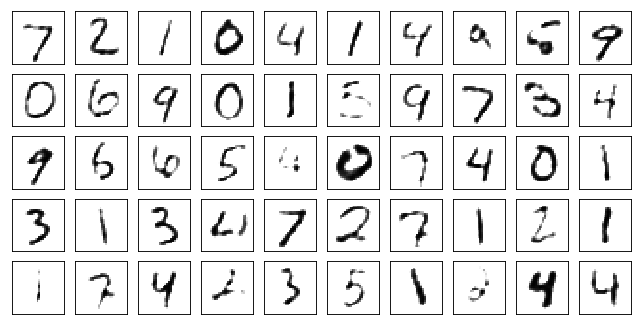

Test set:
64: loss: 0.0309	pho_loss: nan

Train Epoch: 18 [0/50000 (0%)]	Losses 64: 0.032258
Train Epoch: 18 [100/50000 (0%)]	Losses 64: 0.031191
Train Epoch: 18 [150/50000 (0%)]	Losses 64: 0.027953
Train Epoch: 18 [200/50000 (0%)]	Losses 64: 0.029074
Train Epoch: 18 [250/50000 (0%)]	Losses 64: 0.030710
Train Epoch: 18 [300/50000 (1%)]	Losses 64: 0.031656
Train Epoch: 18 [350/50000 (1%)]	Losses 64: 0.031875
Train Epoch: 18 [400/50000 (1%)]	Losses 64: 0.032943
Train Epoch: 18 [450/50000 (1%)]	Losses 64: 0.024360
Train Epoch: 18 [500/50000 (1%)]	Losses 64: 0.030973
Train Epoch: 18 [550/50000 (1%)]	Losses 64: 0.032384
Train Epoch: 18 [600/50000 (1%)]	Losses 64: 0.030298
Train Epoch: 18 [650/50000 (1%)]	Losses 64: 0.032391
Train Epoch: 18 [700/50000 (1%)]	Losses 64: 0.028438
Train Epoch: 18 [750/50000 (2%)]	Losses 64: 0.027467
Train Epoch: 18 [800/50000 (2%)]	Losses 64: 0.033251
Train Epoch: 18 [850/50000 (2%)]	Losses 64: 0.032284
Train Epoch: 18 [900/50000 (2%)]	Losses 64: 0.028311
Train 

Train Epoch: 18 [7700/50000 (15%)]	Losses 64: 0.031049
Train Epoch: 18 [7750/50000 (16%)]	Losses 64: 0.030298
Train Epoch: 18 [7800/50000 (16%)]	Losses 64: 0.030914
Train Epoch: 18 [7850/50000 (16%)]	Losses 64: 0.029650
Train Epoch: 18 [7900/50000 (16%)]	Losses 64: 0.034305
Train Epoch: 18 [7950/50000 (16%)]	Losses 64: 0.029411
Train Epoch: 18 [8000/50000 (16%)]	Losses 64: 0.031804
Train Epoch: 18 [8050/50000 (16%)]	Losses 64: 0.031381
Train Epoch: 18 [8100/50000 (16%)]	Losses 64: 0.029561
Train Epoch: 18 [8150/50000 (16%)]	Losses 64: 0.027427
Train Epoch: 18 [8200/50000 (16%)]	Losses 64: 0.027317
Train Epoch: 18 [8250/50000 (16%)]	Losses 64: 0.028080
Train Epoch: 18 [8300/50000 (17%)]	Losses 64: 0.033461
Train Epoch: 18 [8350/50000 (17%)]	Losses 64: 0.028343
Train Epoch: 18 [8400/50000 (17%)]	Losses 64: 0.027671
Train Epoch: 18 [8450/50000 (17%)]	Losses 64: 0.029120
Train Epoch: 18 [8500/50000 (17%)]	Losses 64: 0.028765
Train Epoch: 18 [8550/50000 (17%)]	Losses 64: 0.026081
Train Epoc

Train Epoch: 18 [15400/50000 (31%)]	Losses 64: 0.030883
Train Epoch: 18 [15450/50000 (31%)]	Losses 64: 0.028901
Train Epoch: 18 [15500/50000 (31%)]	Losses 64: 0.025677
Train Epoch: 18 [15550/50000 (31%)]	Losses 64: 0.031841
Train Epoch: 18 [15600/50000 (31%)]	Losses 64: 0.030041
Train Epoch: 18 [15650/50000 (31%)]	Losses 64: 0.026325
Train Epoch: 18 [15700/50000 (31%)]	Losses 64: 0.034299
Train Epoch: 18 [15750/50000 (32%)]	Losses 64: 0.033590
Train Epoch: 18 [15800/50000 (32%)]	Losses 64: 0.027476
Train Epoch: 18 [15850/50000 (32%)]	Losses 64: 0.030881
Train Epoch: 18 [15900/50000 (32%)]	Losses 64: 0.025379
Train Epoch: 18 [15950/50000 (32%)]	Losses 64: 0.031066
Train Epoch: 18 [16000/50000 (32%)]	Losses 64: 0.027915
Train Epoch: 18 [16050/50000 (32%)]	Losses 64: 0.029697
Train Epoch: 18 [16100/50000 (32%)]	Losses 64: 0.028620
Train Epoch: 18 [16150/50000 (32%)]	Losses 64: 0.030672
Train Epoch: 18 [16200/50000 (32%)]	Losses 64: 0.029201
Train Epoch: 18 [16250/50000 (32%)]	Losses 64: 0

Train Epoch: 18 [23100/50000 (46%)]	Losses 64: 0.028183
Train Epoch: 18 [23150/50000 (46%)]	Losses 64: 0.030529
Train Epoch: 18 [23200/50000 (46%)]	Losses 64: 0.031057
Train Epoch: 18 [23250/50000 (46%)]	Losses 64: 0.031957
Train Epoch: 18 [23300/50000 (47%)]	Losses 64: 0.032362
Train Epoch: 18 [23350/50000 (47%)]	Losses 64: 0.028888
Train Epoch: 18 [23400/50000 (47%)]	Losses 64: 0.031783
Train Epoch: 18 [23450/50000 (47%)]	Losses 64: 0.031243
Train Epoch: 18 [23500/50000 (47%)]	Losses 64: 0.035269
Train Epoch: 18 [23550/50000 (47%)]	Losses 64: 0.027472
Train Epoch: 18 [23600/50000 (47%)]	Losses 64: 0.035531
Train Epoch: 18 [23650/50000 (47%)]	Losses 64: 0.033554
Train Epoch: 18 [23700/50000 (47%)]	Losses 64: 0.029241
Train Epoch: 18 [23750/50000 (48%)]	Losses 64: 0.031271
Train Epoch: 18 [23800/50000 (48%)]	Losses 64: 0.030349
Train Epoch: 18 [23850/50000 (48%)]	Losses 64: 0.028560
Train Epoch: 18 [23900/50000 (48%)]	Losses 64: 0.027650
Train Epoch: 18 [23950/50000 (48%)]	Losses 64: 0

Train Epoch: 18 [31400/50000 (63%)]	Losses 64: 0.027414
Train Epoch: 18 [31450/50000 (63%)]	Losses 64: 0.024498
Train Epoch: 18 [31500/50000 (63%)]	Losses 64: 0.035399
Train Epoch: 18 [31550/50000 (63%)]	Losses 64: 0.030553
Train Epoch: 18 [31600/50000 (63%)]	Losses 64: 0.033306
Train Epoch: 18 [31650/50000 (63%)]	Losses 64: 0.028914
Train Epoch: 18 [31700/50000 (63%)]	Losses 64: 0.027653
Train Epoch: 18 [31750/50000 (64%)]	Losses 64: 0.031238
Train Epoch: 18 [31800/50000 (64%)]	Losses 64: 0.025550
Train Epoch: 18 [31850/50000 (64%)]	Losses 64: 0.030043
Train Epoch: 18 [31900/50000 (64%)]	Losses 64: 0.026059
Train Epoch: 18 [31950/50000 (64%)]	Losses 64: 0.028616
Train Epoch: 18 [32000/50000 (64%)]	Losses 64: 0.027529
Train Epoch: 18 [32050/50000 (64%)]	Losses 64: 0.032621
Train Epoch: 18 [32100/50000 (64%)]	Losses 64: 0.030193
Train Epoch: 18 [32150/50000 (64%)]	Losses 64: 0.027288
Train Epoch: 18 [32200/50000 (64%)]	Losses 64: 0.027376
Train Epoch: 18 [32250/50000 (64%)]	Losses 64: 0

Train Epoch: 18 [39650/50000 (79%)]	Losses 64: 0.028462
Train Epoch: 18 [39700/50000 (79%)]	Losses 64: 0.027205
Train Epoch: 18 [39750/50000 (80%)]	Losses 64: 0.028605
Train Epoch: 18 [39800/50000 (80%)]	Losses 64: 0.028962
Train Epoch: 18 [39850/50000 (80%)]	Losses 64: 0.031032
Train Epoch: 18 [39900/50000 (80%)]	Losses 64: 0.031920
Train Epoch: 18 [39950/50000 (80%)]	Losses 64: 0.030871
Train Epoch: 18 [40000/50000 (80%)]	Losses 64: 0.030355
Train Epoch: 18 [40000/50000 (80%)]	Losses 64: 0.029678
Train Epoch: 18 [40100/50000 (80%)]	Losses 64: 0.031674
Train Epoch: 18 [40150/50000 (80%)]	Losses 64: 0.030962
Train Epoch: 18 [40200/50000 (80%)]	Losses 64: 0.032985
Train Epoch: 18 [40250/50000 (80%)]	Losses 64: 0.028887
Train Epoch: 18 [40300/50000 (81%)]	Losses 64: 0.030504
Train Epoch: 18 [40350/50000 (81%)]	Losses 64: 0.033044
Train Epoch: 18 [40400/50000 (81%)]	Losses 64: 0.031655
Train Epoch: 18 [40450/50000 (81%)]	Losses 64: 0.025114
Train Epoch: 18 [40500/50000 (81%)]	Losses 64: 0

Train Epoch: 18 [47950/50000 (96%)]	Losses 64: 0.030693
Train Epoch: 18 [48000/50000 (96%)]	Losses 64: 0.030731
Train Epoch: 18 [48050/50000 (96%)]	Losses 64: 0.029902
Train Epoch: 18 [48100/50000 (96%)]	Losses 64: 0.026835
Train Epoch: 18 [48150/50000 (96%)]	Losses 64: 0.031272
Train Epoch: 18 [48200/50000 (96%)]	Losses 64: 0.029362
Train Epoch: 18 [48250/50000 (96%)]	Losses 64: 0.030136
Train Epoch: 18 [48300/50000 (97%)]	Losses 64: 0.034488
Train Epoch: 18 [48350/50000 (97%)]	Losses 64: 0.028008
Train Epoch: 18 [48400/50000 (97%)]	Losses 64: 0.028634
Train Epoch: 18 [48450/50000 (97%)]	Losses 64: 0.031623
Train Epoch: 18 [48500/50000 (97%)]	Losses 64: 0.029358
Train Epoch: 18 [48550/50000 (97%)]	Losses 64: 0.026645
Train Epoch: 18 [48600/50000 (97%)]	Losses 64: 0.030790
Train Epoch: 18 [48650/50000 (97%)]	Losses 64: 0.027215
Train Epoch: 18 [48700/50000 (97%)]	Losses 64: 0.026810
Train Epoch: 18 [48750/50000 (98%)]	Losses 64: 0.032375
Train Epoch: 18 [48800/50000 (98%)]	Losses 64: 0

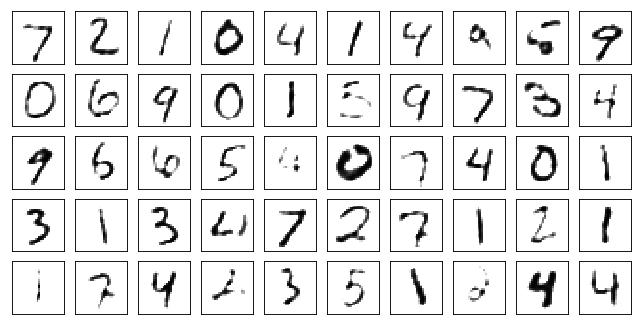

Test set:
64: loss: 0.0298	pho_loss: nan

Train Epoch: 19 [0/50000 (0%)]	Losses 64: 0.028384
Train Epoch: 19 [100/50000 (0%)]	Losses 64: 0.030938
Train Epoch: 19 [150/50000 (0%)]	Losses 64: 0.028798
Train Epoch: 19 [200/50000 (0%)]	Losses 64: 0.028046
Train Epoch: 19 [250/50000 (0%)]	Losses 64: 0.028455
Train Epoch: 19 [300/50000 (1%)]	Losses 64: 0.031230
Train Epoch: 19 [350/50000 (1%)]	Losses 64: 0.030509
Train Epoch: 19 [400/50000 (1%)]	Losses 64: 0.032824
Train Epoch: 19 [450/50000 (1%)]	Losses 64: 0.027266
Train Epoch: 19 [500/50000 (1%)]	Losses 64: 0.030033
Train Epoch: 19 [550/50000 (1%)]	Losses 64: 0.029844
Train Epoch: 19 [600/50000 (1%)]	Losses 64: 0.033732
Train Epoch: 19 [650/50000 (1%)]	Losses 64: 0.031788
Train Epoch: 19 [700/50000 (1%)]	Losses 64: 0.027968
Train Epoch: 19 [750/50000 (2%)]	Losses 64: 0.026911
Train Epoch: 19 [800/50000 (2%)]	Losses 64: 0.023142
Train Epoch: 19 [850/50000 (2%)]	Losses 64: 0.029569
Train Epoch: 19 [900/50000 (2%)]	Losses 64: 0.028455
Train 

Train Epoch: 19 [7700/50000 (15%)]	Losses 64: 0.027233
Train Epoch: 19 [7750/50000 (16%)]	Losses 64: 0.027066
Train Epoch: 19 [7800/50000 (16%)]	Losses 64: 0.028787
Train Epoch: 19 [7850/50000 (16%)]	Losses 64: 0.031543
Train Epoch: 19 [7900/50000 (16%)]	Losses 64: 0.029451
Train Epoch: 19 [7950/50000 (16%)]	Losses 64: 0.027971
Train Epoch: 19 [8000/50000 (16%)]	Losses 64: 0.027510
Train Epoch: 19 [8050/50000 (16%)]	Losses 64: 0.029273
Train Epoch: 19 [8100/50000 (16%)]	Losses 64: 0.031640
Train Epoch: 19 [8150/50000 (16%)]	Losses 64: 0.030659
Train Epoch: 19 [8200/50000 (16%)]	Losses 64: 0.028363
Train Epoch: 19 [8250/50000 (16%)]	Losses 64: 0.026110
Train Epoch: 19 [8300/50000 (17%)]	Losses 64: 0.031836
Train Epoch: 19 [8350/50000 (17%)]	Losses 64: 0.029596
Train Epoch: 19 [8400/50000 (17%)]	Losses 64: 0.029205
Train Epoch: 19 [8450/50000 (17%)]	Losses 64: 0.030955
Train Epoch: 19 [8500/50000 (17%)]	Losses 64: 0.028915
Train Epoch: 19 [8550/50000 (17%)]	Losses 64: 0.029087
Train Epoc

Train Epoch: 19 [15350/50000 (31%)]	Losses 64: 0.027578
Train Epoch: 19 [15400/50000 (31%)]	Losses 64: 0.031120
Train Epoch: 19 [15450/50000 (31%)]	Losses 64: 0.030647
Train Epoch: 19 [15500/50000 (31%)]	Losses 64: 0.026747
Train Epoch: 19 [15550/50000 (31%)]	Losses 64: 0.027377
Train Epoch: 19 [15600/50000 (31%)]	Losses 64: 0.027372
Train Epoch: 19 [15650/50000 (31%)]	Losses 64: 0.026284
Train Epoch: 19 [15700/50000 (31%)]	Losses 64: 0.029102
Train Epoch: 19 [15750/50000 (32%)]	Losses 64: 0.032454
Train Epoch: 19 [15800/50000 (32%)]	Losses 64: 0.030072
Train Epoch: 19 [15850/50000 (32%)]	Losses 64: 0.027208
Train Epoch: 19 [15900/50000 (32%)]	Losses 64: 0.027110
Train Epoch: 19 [15950/50000 (32%)]	Losses 64: 0.030028
Train Epoch: 19 [16000/50000 (32%)]	Losses 64: 0.026801
Train Epoch: 19 [16050/50000 (32%)]	Losses 64: 0.027239
Train Epoch: 19 [16100/50000 (32%)]	Losses 64: 0.027357
Train Epoch: 19 [16150/50000 (32%)]	Losses 64: 0.025752
Train Epoch: 19 [16200/50000 (32%)]	Losses 64: 0

Train Epoch: 19 [22950/50000 (46%)]	Losses 64: 0.027694
Train Epoch: 19 [23000/50000 (46%)]	Losses 64: 0.025179
Train Epoch: 19 [23050/50000 (46%)]	Losses 64: 0.029643
Train Epoch: 19 [23100/50000 (46%)]	Losses 64: 0.027850
Train Epoch: 19 [23150/50000 (46%)]	Losses 64: 0.030103
Train Epoch: 19 [23200/50000 (46%)]	Losses 64: 0.027949
Train Epoch: 19 [23250/50000 (46%)]	Losses 64: 0.027836
Train Epoch: 19 [23300/50000 (47%)]	Losses 64: 0.029581
Train Epoch: 19 [23350/50000 (47%)]	Losses 64: 0.031743
Train Epoch: 19 [23400/50000 (47%)]	Losses 64: 0.030467
Train Epoch: 19 [23450/50000 (47%)]	Losses 64: 0.029016
Train Epoch: 19 [23500/50000 (47%)]	Losses 64: 0.029520
Train Epoch: 19 [23550/50000 (47%)]	Losses 64: 0.031359
Train Epoch: 19 [23600/50000 (47%)]	Losses 64: 0.026349
Train Epoch: 19 [23650/50000 (47%)]	Losses 64: 0.030386
Train Epoch: 19 [23700/50000 (47%)]	Losses 64: 0.033033
Train Epoch: 19 [23750/50000 (48%)]	Losses 64: 0.027404
Train Epoch: 19 [23800/50000 (48%)]	Losses 64: 0

Train Epoch: 19 [30400/50000 (61%)]	Losses 64: 0.030354
Train Epoch: 19 [30450/50000 (61%)]	Losses 64: 0.025260
Train Epoch: 19 [30500/50000 (61%)]	Losses 64: 0.032216
Train Epoch: 19 [30550/50000 (61%)]	Losses 64: 0.027659
Train Epoch: 19 [30600/50000 (61%)]	Losses 64: 0.028146
Train Epoch: 19 [30650/50000 (61%)]	Losses 64: 0.027509
Train Epoch: 19 [30700/50000 (61%)]	Losses 64: 0.032221
Train Epoch: 19 [30750/50000 (62%)]	Losses 64: 0.027726
Train Epoch: 19 [30800/50000 (62%)]	Losses 64: 0.026698
Train Epoch: 19 [30850/50000 (62%)]	Losses 64: 0.027936
Train Epoch: 19 [30900/50000 (62%)]	Losses 64: 0.030870
Train Epoch: 19 [30950/50000 (62%)]	Losses 64: 0.030989
Train Epoch: 19 [31000/50000 (62%)]	Losses 64: 0.026787
Train Epoch: 19 [31050/50000 (62%)]	Losses 64: 0.028682
Train Epoch: 19 [31100/50000 (62%)]	Losses 64: 0.029841
Train Epoch: 19 [31150/50000 (62%)]	Losses 64: 0.032469
Train Epoch: 19 [31200/50000 (62%)]	Losses 64: 0.024760
Train Epoch: 19 [31250/50000 (62%)]	Losses 64: 0

Train Epoch: 19 [38700/50000 (77%)]	Losses 64: 0.028165
Train Epoch: 19 [38750/50000 (78%)]	Losses 64: 0.026478
Train Epoch: 19 [38800/50000 (78%)]	Losses 64: 0.030497
Train Epoch: 19 [38850/50000 (78%)]	Losses 64: 0.027330
Train Epoch: 19 [38900/50000 (78%)]	Losses 64: 0.027779
Train Epoch: 19 [38950/50000 (78%)]	Losses 64: 0.025279
Train Epoch: 19 [39000/50000 (78%)]	Losses 64: 0.028868
Train Epoch: 19 [39050/50000 (78%)]	Losses 64: 0.030897
Train Epoch: 19 [39100/50000 (78%)]	Losses 64: 0.031723
Train Epoch: 19 [39150/50000 (78%)]	Losses 64: 0.026961
Train Epoch: 19 [39200/50000 (78%)]	Losses 64: 0.027461
Train Epoch: 19 [39250/50000 (78%)]	Losses 64: 0.027441
Train Epoch: 19 [39300/50000 (79%)]	Losses 64: 0.026821
Train Epoch: 19 [39350/50000 (79%)]	Losses 64: 0.028230
Train Epoch: 19 [39400/50000 (79%)]	Losses 64: 0.026893
Train Epoch: 19 [39450/50000 (79%)]	Losses 64: 0.026436
Train Epoch: 19 [39500/50000 (79%)]	Losses 64: 0.030498
Train Epoch: 19 [39550/50000 (79%)]	Losses 64: 0

Train Epoch: 19 [47050/50000 (94%)]	Losses 64: 0.024591
Train Epoch: 19 [47100/50000 (94%)]	Losses 64: 0.030062
Train Epoch: 19 [47150/50000 (94%)]	Losses 64: 0.030754
Train Epoch: 19 [47200/50000 (94%)]	Losses 64: 0.028950
Train Epoch: 19 [47250/50000 (94%)]	Losses 64: 0.025386
Train Epoch: 19 [47300/50000 (95%)]	Losses 64: 0.030394
Train Epoch: 19 [47350/50000 (95%)]	Losses 64: 0.031251
Train Epoch: 19 [47400/50000 (95%)]	Losses 64: 0.029931
Train Epoch: 19 [47450/50000 (95%)]	Losses 64: 0.025659
Train Epoch: 19 [47500/50000 (95%)]	Losses 64: 0.033598
Train Epoch: 19 [47550/50000 (95%)]	Losses 64: 0.027135
Train Epoch: 19 [47600/50000 (95%)]	Losses 64: 0.028657
Train Epoch: 19 [47650/50000 (95%)]	Losses 64: 0.028284
Train Epoch: 19 [47700/50000 (95%)]	Losses 64: 0.027892
Train Epoch: 19 [47750/50000 (96%)]	Losses 64: 0.023206
Train Epoch: 19 [47800/50000 (96%)]	Losses 64: 0.031510
Train Epoch: 19 [47850/50000 (96%)]	Losses 64: 0.026188
Train Epoch: 19 [47900/50000 (96%)]	Losses 64: 0

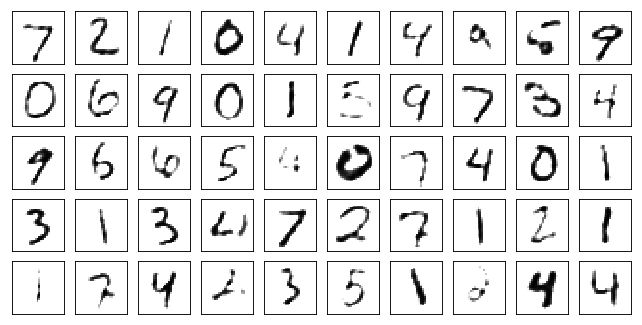

Test set:
64: loss: 0.0289	pho_loss: nan

Train Epoch: 20 [0/50000 (0%)]	Losses 64: 0.031580
Train Epoch: 20 [100/50000 (0%)]	Losses 64: 0.029288
Train Epoch: 20 [150/50000 (0%)]	Losses 64: 0.032194
Train Epoch: 20 [200/50000 (0%)]	Losses 64: 0.032233
Train Epoch: 20 [250/50000 (0%)]	Losses 64: 0.029408
Train Epoch: 20 [300/50000 (1%)]	Losses 64: 0.028496
Train Epoch: 20 [350/50000 (1%)]	Losses 64: 0.025617
Train Epoch: 20 [400/50000 (1%)]	Losses 64: 0.029631
Train Epoch: 20 [450/50000 (1%)]	Losses 64: 0.031682
Train Epoch: 20 [500/50000 (1%)]	Losses 64: 0.029550
Train Epoch: 20 [550/50000 (1%)]	Losses 64: 0.027142
Train Epoch: 20 [600/50000 (1%)]	Losses 64: 0.025852
Train Epoch: 20 [650/50000 (1%)]	Losses 64: 0.028951
Train Epoch: 20 [700/50000 (1%)]	Losses 64: 0.032974
Train Epoch: 20 [750/50000 (2%)]	Losses 64: 0.027153
Train Epoch: 20 [800/50000 (2%)]	Losses 64: 0.028722
Train Epoch: 20 [850/50000 (2%)]	Losses 64: 0.031399
Train Epoch: 20 [900/50000 (2%)]	Losses 64: 0.026233
Train 

Train Epoch: 20 [7700/50000 (15%)]	Losses 64: 0.031670
Train Epoch: 20 [7750/50000 (16%)]	Losses 64: 0.030540
Train Epoch: 20 [7800/50000 (16%)]	Losses 64: 0.032594
Train Epoch: 20 [7850/50000 (16%)]	Losses 64: 0.032664
Train Epoch: 20 [7900/50000 (16%)]	Losses 64: 0.030363
Train Epoch: 20 [7950/50000 (16%)]	Losses 64: 0.028376
Train Epoch: 20 [8000/50000 (16%)]	Losses 64: 0.029054
Train Epoch: 20 [8050/50000 (16%)]	Losses 64: 0.026409
Train Epoch: 20 [8100/50000 (16%)]	Losses 64: 0.030847
Train Epoch: 20 [8150/50000 (16%)]	Losses 64: 0.023690
Train Epoch: 20 [8200/50000 (16%)]	Losses 64: 0.027422
Train Epoch: 20 [8250/50000 (16%)]	Losses 64: 0.026104
Train Epoch: 20 [8300/50000 (17%)]	Losses 64: 0.028099
Train Epoch: 20 [8350/50000 (17%)]	Losses 64: 0.027450
Train Epoch: 20 [8400/50000 (17%)]	Losses 64: 0.028049
Train Epoch: 20 [8450/50000 (17%)]	Losses 64: 0.030568
Train Epoch: 20 [8500/50000 (17%)]	Losses 64: 0.028462
Train Epoch: 20 [8550/50000 (17%)]	Losses 64: 0.027463
Train Epoc

Train Epoch: 20 [15300/50000 (31%)]	Losses 64: 0.027433
Train Epoch: 20 [15350/50000 (31%)]	Losses 64: 0.027045
Train Epoch: 20 [15400/50000 (31%)]	Losses 64: 0.026953
Train Epoch: 20 [15450/50000 (31%)]	Losses 64: 0.030129
Train Epoch: 20 [15500/50000 (31%)]	Losses 64: 0.028370
Train Epoch: 20 [15550/50000 (31%)]	Losses 64: 0.027357
Train Epoch: 20 [15600/50000 (31%)]	Losses 64: 0.027043
Train Epoch: 20 [15650/50000 (31%)]	Losses 64: 0.029559
Train Epoch: 20 [15700/50000 (31%)]	Losses 64: 0.030759
Train Epoch: 20 [15750/50000 (32%)]	Losses 64: 0.027236
Train Epoch: 20 [15800/50000 (32%)]	Losses 64: 0.028265
Train Epoch: 20 [15850/50000 (32%)]	Losses 64: 0.025448
Train Epoch: 20 [15900/50000 (32%)]	Losses 64: 0.028945
Train Epoch: 20 [15950/50000 (32%)]	Losses 64: 0.029823
Train Epoch: 20 [16000/50000 (32%)]	Losses 64: 0.027497
Train Epoch: 20 [16050/50000 (32%)]	Losses 64: 0.029324
Train Epoch: 20 [16100/50000 (32%)]	Losses 64: 0.024650
Train Epoch: 20 [16150/50000 (32%)]	Losses 64: 0

Train Epoch: 20 [23000/50000 (46%)]	Losses 64: 0.033616
Train Epoch: 20 [23050/50000 (46%)]	Losses 64: 0.028833
Train Epoch: 20 [23100/50000 (46%)]	Losses 64: 0.029804
Train Epoch: 20 [23150/50000 (46%)]	Losses 64: 0.022878
Train Epoch: 20 [23200/50000 (46%)]	Losses 64: 0.027425
Train Epoch: 20 [23250/50000 (46%)]	Losses 64: 0.028426
Train Epoch: 20 [23300/50000 (47%)]	Losses 64: 0.029804
Train Epoch: 20 [23350/50000 (47%)]	Losses 64: 0.027416
Train Epoch: 20 [23400/50000 (47%)]	Losses 64: 0.030736
Train Epoch: 20 [23450/50000 (47%)]	Losses 64: 0.027051
Train Epoch: 20 [23500/50000 (47%)]	Losses 64: 0.024813
Train Epoch: 20 [23550/50000 (47%)]	Losses 64: 0.027793
Train Epoch: 20 [23600/50000 (47%)]	Losses 64: 0.025826
Train Epoch: 20 [23650/50000 (47%)]	Losses 64: 0.030912
Train Epoch: 20 [23700/50000 (47%)]	Losses 64: 0.024557
Train Epoch: 20 [23750/50000 (48%)]	Losses 64: 0.030634
Train Epoch: 20 [23800/50000 (48%)]	Losses 64: 0.023794
Train Epoch: 20 [23850/50000 (48%)]	Losses 64: 0

Train Epoch: 20 [31250/50000 (62%)]	Losses 64: 0.028698
Train Epoch: 20 [31300/50000 (63%)]	Losses 64: 0.028092
Train Epoch: 20 [31350/50000 (63%)]	Losses 64: 0.024216
Train Epoch: 20 [31400/50000 (63%)]	Losses 64: 0.028993
Train Epoch: 20 [31450/50000 (63%)]	Losses 64: 0.023416
Train Epoch: 20 [31500/50000 (63%)]	Losses 64: 0.029912
Train Epoch: 20 [31550/50000 (63%)]	Losses 64: 0.026411
Train Epoch: 20 [31600/50000 (63%)]	Losses 64: 0.026052
Train Epoch: 20 [31650/50000 (63%)]	Losses 64: 0.027210
Train Epoch: 20 [31700/50000 (63%)]	Losses 64: 0.027682
Train Epoch: 20 [31750/50000 (64%)]	Losses 64: 0.026314
Train Epoch: 20 [31800/50000 (64%)]	Losses 64: 0.027864
Train Epoch: 20 [31850/50000 (64%)]	Losses 64: 0.028382
Train Epoch: 20 [31900/50000 (64%)]	Losses 64: 0.027422
Train Epoch: 20 [31950/50000 (64%)]	Losses 64: 0.022538
Train Epoch: 20 [32000/50000 (64%)]	Losses 64: 0.028848
Train Epoch: 20 [32050/50000 (64%)]	Losses 64: 0.027742
Train Epoch: 20 [32100/50000 (64%)]	Losses 64: 0

Train Epoch: 20 [39550/50000 (79%)]	Losses 64: 0.027321
Train Epoch: 20 [39600/50000 (79%)]	Losses 64: 0.031070
Train Epoch: 20 [39650/50000 (79%)]	Losses 64: 0.030955
Train Epoch: 20 [39700/50000 (79%)]	Losses 64: 0.023461
Train Epoch: 20 [39750/50000 (80%)]	Losses 64: 0.029747
Train Epoch: 20 [39800/50000 (80%)]	Losses 64: 0.025509
Train Epoch: 20 [39850/50000 (80%)]	Losses 64: 0.027952
Train Epoch: 20 [39900/50000 (80%)]	Losses 64: 0.033514
Train Epoch: 20 [39950/50000 (80%)]	Losses 64: 0.030425
Train Epoch: 20 [40000/50000 (80%)]	Losses 64: 0.028611
Train Epoch: 20 [40000/50000 (80%)]	Losses 64: 0.024934
Train Epoch: 20 [40100/50000 (80%)]	Losses 64: 0.026138
Train Epoch: 20 [40150/50000 (80%)]	Losses 64: 0.025946
Train Epoch: 20 [40200/50000 (80%)]	Losses 64: 0.024792
Train Epoch: 20 [40250/50000 (80%)]	Losses 64: 0.027699
Train Epoch: 20 [40300/50000 (81%)]	Losses 64: 0.028005
Train Epoch: 20 [40350/50000 (81%)]	Losses 64: 0.025560
Train Epoch: 20 [40400/50000 (81%)]	Losses 64: 0

Train Epoch: 20 [46900/50000 (94%)]	Losses 64: 0.024285
Train Epoch: 20 [46950/50000 (94%)]	Losses 64: 0.028724
Train Epoch: 20 [47000/50000 (94%)]	Losses 64: 0.030015
Train Epoch: 20 [47050/50000 (94%)]	Losses 64: 0.026543
Train Epoch: 20 [47100/50000 (94%)]	Losses 64: 0.025405
Train Epoch: 20 [47150/50000 (94%)]	Losses 64: 0.028106
Train Epoch: 20 [47200/50000 (94%)]	Losses 64: 0.025730
Train Epoch: 20 [47250/50000 (94%)]	Losses 64: 0.028319
Train Epoch: 20 [47300/50000 (95%)]	Losses 64: 0.025835
Train Epoch: 20 [47350/50000 (95%)]	Losses 64: 0.031089
Train Epoch: 20 [47400/50000 (95%)]	Losses 64: 0.026145
Train Epoch: 20 [47450/50000 (95%)]	Losses 64: 0.025877
Train Epoch: 20 [47500/50000 (95%)]	Losses 64: 0.025307
Train Epoch: 20 [47550/50000 (95%)]	Losses 64: 0.027432
Train Epoch: 20 [47600/50000 (95%)]	Losses 64: 0.026399
Train Epoch: 20 [47650/50000 (95%)]	Losses 64: 0.028333
Train Epoch: 20 [47700/50000 (95%)]	Losses 64: 0.024972
Train Epoch: 20 [47750/50000 (96%)]	Losses 64: 0

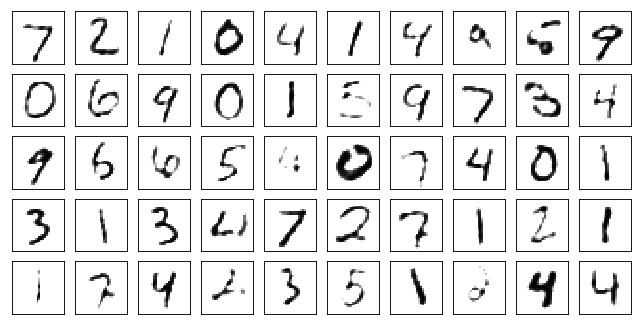

Test set:
64: loss: 0.0282	pho_loss: nan



In [6]:
"""
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)
"""

In [7]:
weights_file_AE = os.path.join(weights_dir, 'AE/weights.h5')

# torch.save(models['64'].state_dict(), weights_file_AE)

Сгенерируем свою рукописную цифру

In [8]:
models['64'].load_state_dict(torch.load(weights_file_AE))

<All keys matched successfully>

In [9]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([15, 21, 16, 15, 20, 19, 18, 17, 29, 15, 21, 14, 12, 13, 21, 21, 18, 19,
        26, 15, 10, 19, 19, 17, 12, 16, 20, 18, 15, 26, 20, 22, 21, 18, 22, 18,
        17, 21, 20, 20, 21, 14, 21, 20, 24, 17, 20, 19, 19, 20])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


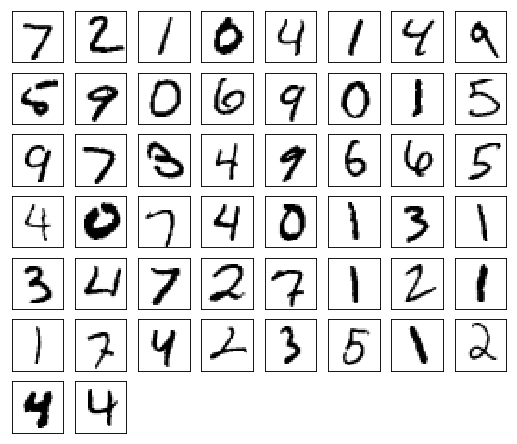

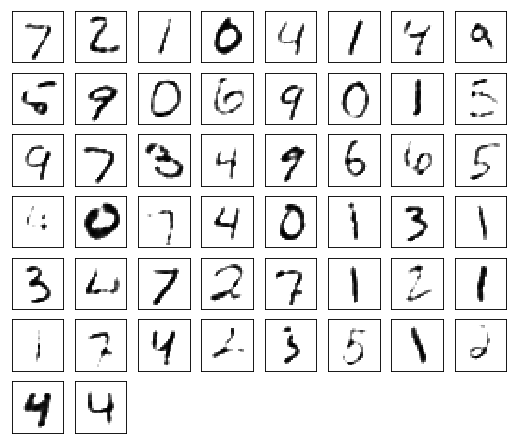

In [10]:
plot_mnist_2(data.data.numpy(), (8, 8))
plot_mnist_2(to_plot, (8, 8))

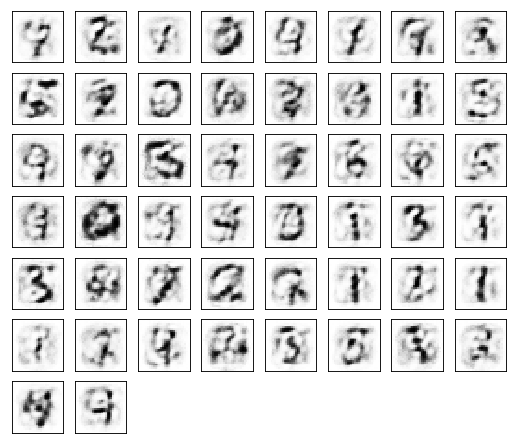

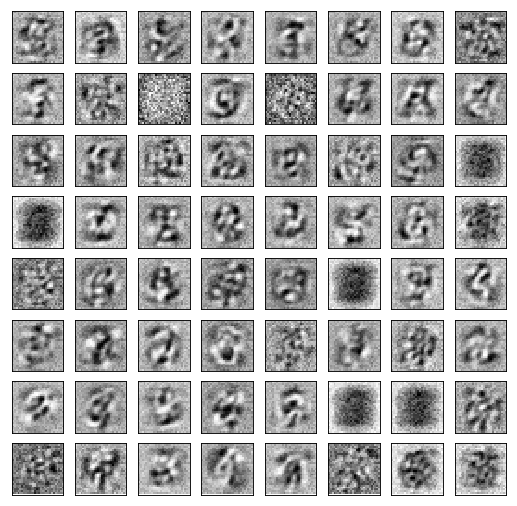

In [11]:
plot_mnist_2(f_to_plot, (8, 8))
plot_mnist_2(dec_to_plot, (8, 8))

#### Visualization

In [12]:
import imageio
import os

path = '/Users/a18157079/Desktop/Experiments/AE_log_results/AE_results/'

image_folder = os.fsencode(path)

filenames = []

for file in os.listdir(image_folder):
    filename = os.fsdecode(file)
    if filename.endswith( ('.jpeg', '.png', '.gif') ):
        filenames.append(os.path.join(path, filename))

filenames.sort() # this iteration technique has no built in order, so sort the frames

images = [imageio.imread(f) for f in filenames]

imageio.mimsave(os.path.join('epochs_AE.gif'), images, duration = 0.3) # modify duration as needed

### VAE

VAE представляет собой генеративную модель — она оценивает плотность вероятности (PDF) обучающих данных.

Можем представить процесс рисования человеком цифры в два шага. Сначала человек определяет — сознательно или нет — все атрибуты цифры, которую собирается выевсти. Далее эти решения трансформируются в штрихи на бумаге.

VAE пытается смоделировать этот процесс: при заданном изображении x мы хотим найти хотя бы один скрытый вектор, способный его описать; один вектор, содержащий инструкции для генерации x.

#### Root settings

In [13]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
VAE_folder = root_folder + '/VAE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(VAE_folder)

mnist_tanh = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 2))
fixed_data, fixed_target = next(iter(test_loader))

#### Model

In [14]:
from models.VAE import VAE

models = {'VAE10': VAE(2, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

Обучим полученную нейросеть:

In [15]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()

        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)

        else:
            batch_idx += 1
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            if log is not None:
                for k in models:
                    log[k].append((models[k]._loss,))
            print(line + losses)


In [16]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()

    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k,
                                                                    test_reconstruction_loss[k],
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data).data.numpy()
            fixed_gen = models[k].decode(fixed_z).data.numpy()
            plot_mnist_4(ae_data, (5, 10), True, VAE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist_4(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)


#### Train

In [17]:

for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)


'\nfor epoch in range(1, 31):\n    for model in models.values():\n        model.train()\n    train(epoch, models, train_log)\n    for model in models.values():\n        model.eval()\n    test(models, valid_loader, epoch, test_log)\n'

#### Save weights

In [18]:
weights_file = os.path.join(weights_dir, 'VAE/weights.h5')

# torch.save(models['VAE10'].state_dict(), weights_file)

#### Load model

In [19]:
models['VAE10'].load_state_dict(torch.load(weights_file))

RuntimeError: Error(s) in loading state_dict for VAE:
	Missing key(s) in state_dict: "_conv1.model.0.weight", "_conv1.model.0.bias", "_conv2.model.0.weight", "_conv2.model.0.bias", "_conv3.model.0.weight", "_conv3.model.0.bias", "fce.model.0.weight", "fce.model.0.bias", "fcd.model.0.weight", "fcd.model.0.bias", "_deconv1.model.0.weight", "_deconv1.model.0.bias", "_deconv2.model.0.weight", "_deconv2.model.0.bias", "_deconv3.model.0.weight", "_deconv3.model.0.bias". 
	Unexpected key(s) in state_dict: "model.0.weight", "model.0.bias", "model.2.weight", "model.2.bias", "model.4.weight", "model.4.bias", "model.6.weight", "model.6.bias". 

In [ ]:
d0 = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
batch = d0.sample(sample_shape=torch.Size([100]))

In [ ]:
with torch.no_grad():
    fixed_gen = models['VAE10'].decode(batch.sort(dim=0)[0]).data.numpy()
    plot_mnist_4(fixed_gen, (10, 10), True, "./123.png")

#### Visualization

In [ ]:
import imageio
import os

path = '/Users/a18157079/Desktop/Experiments/Conv_VAE_log_results_1/Fixed_results/'

image_folder = os.fsencode(path)

filenames = []

for file in os.listdir(image_folder):
    filename = os.fsdecode(file)
    if filename.endswith( ('.jpeg', '.png', '.gif') ):
        filenames.append(os.path.join(path, filename))

filenames.sort() # this iteration technique has no built in order, so sort the frames

images = [imageio.imread(f) for f in filenames]

imageio.mimsave(os.path.join('epochs_VAE.gif'), images, duration = 0.3) # modify duration as needed

### GAN

In [ ]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [ ]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [ ]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
count_class = 10
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((batch_size, 100))

In [ ]:
from models.GAN import FullyConnected

G = FullyConnected([prior_size+count_class, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28+count_class, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [ ]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [ ]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [ ]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z, target), target)
        true_pred = D(data, target)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z, target), target)
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())


In [ ]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, target in loader:
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(G(z, target), target)
            true_pred = D(data, target)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fixed_gen = G(fixed_z, target).data.numpy().reshape(batch_size, 1, 28, 28)
    plot_mnist_4(fixed_gen, (10, 25), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)


#### Train

In [ ]:
for epoch in range(1, 31):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)

In [ ]:
weights_file_G = os.path.join(weights_dir, 'GAN/weights_G.h5')

torch.save(G.state_dict(), weights_file_G)

In [ ]:
G.load_state_dict(torch.load(weights_file_G))

#### Visualization

In [ ]:
import imageio
import os

path = '/Users/a18157079/Desktop/Experiments/FC_GAN_results/Fixed_results/'

image_folder = os.fsencode(path)

filenames = []

for file in os.listdir(image_folder):
    filename = os.fsdecode(file)
    if filename.endswith( ('.jpeg', '.png', '.gif') ):
        filenames.append(os.path.join(path, filename))

filenames.sort() # this iteration technique has no built in order, so sort the frames

images = [imageio.imread(f) for f in filenames]

imageio.mimsave(os.path.join('epochs_GAN.gif'), images, duration = 0.3) # modify duration as needed

### CAAE

In [ ]:
root_folder = 'FC_CAAE_results_'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [ ]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

In [ ]:
data, label = next(iter(train_loader))

In [ ]:
from models.CAAE import FullyConnected

Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size+10, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [ ]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [ ]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [ ]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10, device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)

        fake_pred = Disc(Enc(data), label)
        true_pred = Disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10)
        
        latent = Enc(data)
        reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
        fake_pred = Disc(latent, label)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [ ]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
            latent = Enc(data)
            reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
            fake_pred = Disc(latent, label)
            true_pred = Disc(z, z_label)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size

        fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

In [ ]:
for epoch in range(1, 21):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)

In [ ]:
Enc.eval()
Dec.eval()
Disc.eval()
test(Enc, Dec, Disc, valid_loader, epoch, test_log)

In [ ]:
weights_file_Enc = os.path.join(weights_dir, 'CAAE/weights.h5')

torch.save(Enc.state_dict(), weights_file_Enc)

In [ ]:
Enc.load_state_dict(torch.load(weights_file_Enc))

## Results

## Conclusion